# Hvorfor sank Vasaskipet?
Gruppemedlemmer: 10047, 10095,10100

Den 10. august 1628 var det mange svensker i Stockholm som fikk seg et dramatisk syn. Kun 20 minutter hadde passert før orlogsskipet Vasa sank til bunns i hovedstadens fjord på sin første tur noensinne. Det var den daværende svenske Kong Gustav II Adolf som trosset advarsler om at Vasa ikke var stabil nok til å seile, og dermed sendte det til sin død. Konklusjonen er krystallklar: hør nøye etter når fysikerne snakker.

Det er lett å være etterpåklok 394 år senere som nordmann - kanskje noe hyklerisk i lys av Helge Ingstad-tragedien - og spesielt med analyse-verktøy som man ikke hadde på den tiden. I dag har vi f.eks. tilgang på Jupyter Notebook, noe til og med kongen ikke hadde den gang, og vi skal derfor ta på oss ansvaret for å se på hva, hvorfor og hvordan det gikk så galt for våre svenske venner. Dette gjør vi ved å simulere en enkel skipsmodell på vann. Da får vi også lagt en rettesnor for fremtidige konger som ønsker et 1200 tonns skip flytende istedenfor sammen med krabbene.

---

**Skipsmodell**

Modellen vår er en halv sylinder med radius $R = 10$ meter og dermed tversnitt $A_S = \frac{1}{2}\pi R^2$. Vi skal se at denne begynner å vugge rundt massesenteret når den blir plassert på vann. Havbruksingeniører bruker ordet metasenter som vil være midtpunktet på dekket - typisk der masten på et skip vil stå. Dette er derimot ikke massesenteret, og høyden mellom disse er gitt som $h = \frac{4R}{3\pi} ≈ 0.42R$. Denne er konstant siden metasenteret og massesenteret alltid har samme avstand fra hverandre. I koden bruker vi ´h_MC´ for å skille denne avstanden fra steglengden som også bruker samme bokstav. Når båten vugger vil det oppstå en vinkel $\theta$ som er den øverste vinkelen i en trekant som dannes av massesenter, metasenter og båtens dypeste punkt. $\omega$ betegner vinkelfarten båten får, og er den deriverte av utslagsvinkelen $\theta$. Halvsirkelen er kompakt med en massetetthet $\sigma = 500kg/m^2$. Etterhvert skal vi også introdusere last på skipets dekk. En kjapp liten symbolforklaring før vi ser på hvilke krefter som virker på modellen:

M: metasenter

CM: massesenter

B: oppdriftsenter (tungdepunktet for fortrengt vann)

D: skipets dypeste punkt

**Kreftene som virker**

Vi kommer ikke til å ta høyde for hver eneste kraft som virket på Vasaskipet den skjebnesvangre dagen i 1928. Den mest åpenbare, og som absolutt må med, heter gravitasjonskraft. Denne virker i CM rett nedover. I tillegg tar vi med skipets oppdrift fra fortrengt vann og friksjon mellom skroget og vannet. Oppdriftskraften (Arkimedes lov) er proporsjonal med den vannnmengden som skipet fortrenger til en hver tid. Vannets massetetthet er definert med konstanten $\sigma_0 = 1000 kg/m^2$, og det fortrengte arealet i likevekt blir da $A_0 = \frac{\sigma\pi R^2}{2\sigma_0}$. Senere vil vi introdusere $\gamma$ som angir sektorvinkelen utspent av to linjer trukket fra der vannkanten møter skroget (to punkter) og til metasenteret (kaller den $\beta$ i likevekt). Dette er hensiktsmessig fordi det fortrengte arealet, og dermed også $\beta$, endrer seg med båtens bevegelse. Oppdriftskraften virker i B rett opp. Vi antar at friksjonen mellom skroget og vannet er proporsjonal med arealet av grenseflaten og dens vinkelhastighet. Denne har horisontal retning og virker i D. Til slutt skal vi også inkludere bidraget fra vind og bølger som en oscillerende kraft som virker horisontalt i vannhøyden. Vi skal ta oppbygningen av hele simulasjonen stegvis, så kreftene som virker vil bli diskutert nøyere når vi introduserer dem i simulasjonen. Aller først må vi importere relevante bibliotek før vi definerer parameterne for modellen vår.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Latex, display
from numpy import pi, sin, cos, arccos, sqrt
from matplotlib import animation

%matplotlib inline
import seaborn as sns
from IPython.display import HTML, clear_output
from matplotlib.animation import FuncAnimation
plt.rcParams['animation.embed_limit'] = 2**128

newparams = {'figure.figsize': (10, 6), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [2]:
# Konstante parametre
g       = 9.81                           # [m/s^2]
R       = 10                             # [m]
sigma0  = 1000                           # [kg/m^2]
sigma    = 500                           # [kg/m^2]
A_s      = 1/2*pi*R**2                   # [m^2]
h_MC     = 4*R/(3*pi)                    # [m]


def parameter(last=0, s_L=0):
    """
    INPUT:
        last:     float,     Lastens andel av skipets masse
        s_L:      float,     Lastens avstand fra metasentrum
    ---
    Definerer enkelte parametere som endres gjennom prosjektet globalt.
    """
    global m
    m        = A_s*sigma                                              # [kg]
    m       += last*m                                                 # [kg]
    global m_L
    m_L = last*m                                                      # [kg]
    global I_C
    I_C      = 1/2*m*R**2*(1-32/(9*pi**2)) + m_L*(s_L**2 + h_MC**2)   # [kg*m^2]
    global A_0
    A_0      = m/sigma0                                               # [m^2]

parameter()

I senere oppgaver når ekstra masse tilføres skipet, vil enkelte parametere endre seg; mer spesifikt total masse, lastens masse, systemets treghetsmoment og areal av fortrengt vann. Vi definerer derfor parametere som forblir konstante én gang, men lager funksjonen `parameter()` som definerer enkelte parametere globalt, slik at funksjonen simpelthen kan kalles når dette er relevant. Vi gjør dette, i motsetning til å ha disse verdiene som funksjonsparametere overalt, for at våre funksjoner for ligningssystemene slipper å ta inn utallige parametere, men heller kan kalle på globale konstanter som omdefineres som nødvendig.

Selv om vi betrakter en relativt enkel modell for et skip ender man opp med en haug med ligninger og differensialligninger som må løses numerisk. Vi velger å definere generelle funksjoner allerede nå som skal brukes gjennom hele prosjektet. Dette inkluderer funksjoner for de numeriske metodene vi bruker, en generell ODL-løser med relevante funksjonaliteter for prosjektet, og en ramme-funksjon som kalles for å utføre en simulering. Vi bruker Newtons metode for å løse ligninger, og Eulers metode, klassisk Runge-Kutta 4 og Bogacki-Shampine med adaptiv steglengde for å løse systemer av ODL.


Vi starter med en generell Newtons metode som kan løse et generisk problem på formen $f(x) = 0$ med en ukjent løsning $r$. Her må vi også legge inn en toleranse som sier noe om et resultat er nærme nok den analytiske løsningen til å være valid. Denne metoden kan oppsummeres slik:

* Gitt en $f$ og startverdi $x_0$
* For $k = 0, 1, 2, 3 ...$
     * $\displaystyle x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$

I tillegg har vi også definert Eulers metode og RK4-metoden fordi de kommer til å bli brukt hyppig om hverandre gjennom simuleringen. Disse to løser ordinære differensialligninger på litt forskjellig måte. Eulers metode kan oppsummeres slik:

* Gitt en funksjon $f(x,y)$ og initialverdi $(x_0, y_0)$
* Velg en steglengde $h$
* For $n=0,1,2,\dotsc$ 
  * $\displaystyle y_{n+1}  = y_{n} + h f(x_n, y_n)$, 
  * $x_{n+1}=x_n+h$,

RK4 slik:

* Gitt en funksjon $f(x,y)$ og initialverdi $(x_0, y_0)$
* Velg steglengde $h$
* For $n=0,1,2,\dotsc$
    * $\displaystyle k_1 = f(x_n, y_n)$,
    * $k_2 = f\left(x_n+\frac{h}{2}, y_n+\frac{h}{2}k_1\right)$,
    * $k_3 = f\left(x_n+\frac{h}{2}, y_n+\frac{h}{2}k_2\right)$,
    * $k_4 = f\left(x_n+h, y_n+hk_3\right)$,
    * $y_{n+1} = y_n + h\left(\frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} + \frac{k_4}{6}\right)$,
    * $x_{n+1} = x_n+h$

og Bogacki-Shampine slik:
* Gitt en funksjon $f(x,y)$ og initialverdi $(x_0, y_0)$
* Du har en steglengde regnet ut fra forrige gjennomgang $h$
* Du har en feiltoleranse $tol$ og en pessimistfaktor $p$
* For $n=0,1,2,\dotsc$
    * $\displaystyle k_1 = k_{4,n-1}$
    * $k_2 = f\left(t+\frac{h_n}{2},w+\frac{h_nk_1}{2}\right)$
    * $k_3 = f\left(t+h_n\frac{3}{4},w+h_nk_2\frac{3}{4}\right)$
    * $y_{n+1} = y_n + h_n\left(\frac{2}{9}k_1 + \frac{k_2}{3} + \frac{4}{9}k_3\right)$
    * $k_4 = f\left(t+h_n,y_{n+1}\right)$
    * $y^{3.ordens}_{n+1} = y_n + h_n(\frac{7}{24}k_1 + \frac14 k_2 + \frac13 k_3 + \frac18 k_4)$
    * $|e_{n+1}| = |y_{n+1} - y^{3.ordens}_{n+1}|$
    
Deretter regnes det ut en ny $h$ uavhengig av om feilen er over eller under toleranse:

*
    * $h_{n+1} = p\left(\frac{tol}{||e_{n+1}||}\right)^{\frac{1}{2+1}}h_n$

$y_{n+1}$ blir så godkjent om $||e_{n+1}|| < tol$.

In [3]:
"""NUMERISKE METODER"""

def Newtons_method(f, f_d, x0, tol = 1e-14):
    """
    INPUT:
        f:     funksjon,     Fikspunktfunksjonen
        f_d:   funksjon,     Den deriverte av f
        x0:    float,        Startverdien til x
        tol:   float,        Feiltoleransen
    ---
    Newtons metode for å numerisk finne røtter av en funksjon
    ---
    OUTPUT:
        xn:    float,        Svaret på fikspunktproblemet
    """
    xn = x0
    while abs(f(xn)) > tol:
        x = xn
        xn = x - f(x)/f_d(x)
    return xn


def Euler_method(f, t, w, h):     # Ett steg av Euler metoden
    """
    INPUT:
        f:        funksjon,     Den deriverte til w
        t:        float,        Tiden
        w:        1D array,     Vinkel og vinkelhastighet
        h:        float,        Steglengde
    ---
    Ett steg av Eulers metode for løsning av ODL
    ---
    OUTPUT:
        t_next:   float,        Tid etter steg
        w_next:   1D array,     Vinkel og vinkelhastighet neste steg
    """

    w_next = w + h*f(t,w)
    t_next = t + h
    return t_next, w_next


def RK4(f, t, w, h):
    """
    INPUT:
        f:         funksjon,     Vektor for ligningssystem på form: w'(t) = f(t, w)
        t:         float,        Foreløpig tidspunkt i utregning
        w:         1D array,     Vektor med verdier for funksjoner som inngår i ligningssystem ved tid t; w'(t) = f(t, w)
        h:         float,        Steglengde
    ---
    Utfører ett steg av den klassiske Runge-Kutta 4 metoden for løsning av ODL.
    ---
    OUTPUT:
        t_next:    float,        Neste tidspunkt i utregning
        w_next:    1D array,     Nye verdier for funksjoner i w
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)

    t_next = t + h
    w_next = w + h*(k1/6 + k2/3 + k3/3 + k4/6)
    return t_next, w_next

def bogshamp(f,t,w,h,k1,tol = 1e-7,p=0.9):
    """
    INPUT:
        f:     funksjon,  Vektor for ligningssystem på form: w'(t) = f(t, w)
        t:     float,     Foreløpig tidspunkt i utregning
        w:     1D array,  Vektor med verdier for funksjoner som inngår i ligningssystem ved tid t; w'(t) = f(t, w)
        h:     float,     Steglengde
        k1:    1D array,  Vektor med k4 fra forrige steg, utnyttelse av FSAL egenskapen til Bogacki-Shampinemetoden
        tol:   float,     Feiltoleransen
        p:     float,     Pessimistfaktoren
    ----
    Utfører ett akseptert steg av Bogacki-Shampinemetoden. Funksjonen vil loope fram til et akseptert steg er utført.
    ----
    OUTPUT:
        tn:    float,     Neste tidsverdi
        w_np1: 1D array,  Ny, godtatt vektor, med feil mindre eller lik feiltoleransen
        h:     float,     Steglengdeforslag til neste iterasjon
        k4:    1D array,  Vektor med verdiene til neste k1, benyttes ved neste iterasjon
    """
    while True: # Whileløkke som looper til en løsning er godtatt
        k2 = f(t+h/2,w+h*k1/2)
        k3 = f(t+h*3/4,w+h*k2*3/4)
        w_np1 = w + h*((2/9)*k1 + k2/3 + (4/9)*k3) # 2. ordens løsning
        k4 = f(t+h,w_np1)
        tn = t + h
        error_est = w + h*(k1*7/24 + k2/4 + k3/3 + k4*(1/8)) - w_np1 # Forskjellen mellom den 2. og 3. ordens løsningen, vårt feilestimat
        h = p*(tol/np.linalg.norm(error_est))**(1/(2+1))*h # Utregningen av neste steglengde
        if np.linalg.norm(error_est) <= tol: # Godkjenningsprosessen
            return tn, w_np1, h, k4

Deretter definerer vi ODL-løseren. Denne må ta inn funksjon for systemet den skal løse, startverdier, tidsintervall, steglengde og løsningsmetode, og vil utføre iterasjoner av metoden for tidspunkt innenfor intervallet. I tillegg til dette må løseren ta inn et par parametere som er relevante for våre simulasjoner, nemlig masse av eventuell last relativt til skipets masse, om båten skal ha gjerder på kantene og om eventuell kantring skal tas høyde for. Dermed utfører løseren diverse tester om skipet har kantret, om lasten har falt av eller om lasten kolliderer med gjerder, alt etter hva som er relevant for den enkelte simuleringen. I tillegg omdefinerer løseren enkelte globale parametere vha. `parameter()` og beregner $\beta$ før simuleringen og når det skulle trenges, siden det vil skje endringer på grunn av lasten.

For at skipet skal kantre må skipets dekk berøre vannoverflaten, og dette vet vi er tilfellet om

$$|\theta| > \frac{\pi-\gamma}{2}$$

Denne betingelsen er oppgitt i prosjektbeskrivelsen. Dersom betingelsen er oppfylt, settes alle verdier i $\vec{w}(t)$ til $0$ unntatt $\theta$, som settes lik $\pm\frac{\pi}{2}$. Fortegn bestemmes ut ifra hvilken side båten kantret på; minus om kantring med klokka og pluss mot klokka.

Lasten på skipet faller av dersom $|s_L| > R$. Om dette skjer, settes massen til lasten og dens fart lik $0$ og lasten flyttes én meter utfor skipets kant. Lasten flyttes lengre ut siden løseren ikke vil stoppe å gjøre beregninger på lastens posisjon, så litt slingringsmonn kreves for at lasten ikke skal "hoppe tilbake på dekk". Etter at lasten har falt av blir $\beta$ kalkulert på nytt og endret globalt siden massen er endret. Det er også lagt inn en mekanisme som passer på at dette kun skjer én gang, da å utføre Newtons metode flere ganger fort vil spise prosessorkraft.

Når vi skal sjekke om lasten har kollidert med gjerdene på skipet, sjekker vi igjen om $|s_L| > R$, og om dette oppfylles, settes lastens fart lik $0$ og dens avstand fra metasentrum lik $\pm R$; alt ettersom på hvilken side lasten kolliderer. Vi velger å sjekke om avstand fra metasentrum er absolutt større enn $R$ fordi betingelsen $s_L \ge R$ ville resultert i at lasten ville blitt fanget ved $s_L = R$, da lastens fart i dette tilfellet kontinuerlig ville blitt satt lik $0$.

Disse ekstra funksjonalitetene vil først være relevante i Oppgave 2.

In [4]:
def ode_solver(f, w0, t_lim, h, method, last = 0, gjerder=False, kantring = True):
    """
    INPUT:
        f:         funksjon,     Vektor for ligningssystem på form: w'(t) = f(t, w)
        w0:        1D array,     w-vektor med startverdier
        t_lim:     liste,        Tidsintervall; [t_i, t_f]
        h:         float,        Steglengde
        method:    funksjon,     Ønsket numerisk løsningsmetode
        last:      float,        Lastens masseandel av skipets masse
        gjerder:   Bool,         Skal gjerder inkluderes; hvis ja, gjerder=True
        kantring:  Bool,         Skal kanting tas høyde for; hvis ja, kantring=True
    ---
    Funksjonen løser numerisk et system av ODL ved en spesifisert metode og
    oppgitte parametere.
    ---
    OUTPUT:
        t_list:    1D array,     Array med tider i løsning
        w_list:    2D array,     Verdier for numerisk løsning av ODL
    """
    # Newtons metode med startverdi t = 1.5 for å finne beta
    def beta_calc():
        global beta
        beta = Newtons_method(f_beta, f_beta_d, 1.5)
    beta_calc()
    
    beta_lock = False                        # Om last faller av, brukes denne for at beta kun oppdateres én gang
    
    # Initialiserer arrays og verdier for w og t
    w_num = np.array([w0])
    wn = w0

    t_list = np.array([t_lim[0]])
    tn = t_lim[0]
    if method == bogshamp:
        k1 = f(t_lim[0],w0)
    # Kjører løkke mens tn er innenfor ønsket intervall
    while tn < t_lim[1]:
        
        # Passer på at man får løsning ved siste t
        if tn + h > t_lim[1]:
            h = t_lim[1] - tn
        if method == bogshamp:
            tn, wn, h, k1 = method(f, tn, wn, h, k1)
        else:
            tn, wn = method(f, tn, wn, h)    # Ett steg med valgt metode
        
        gamma = 2*arccos(cos(beta/2)-4/(3*pi)*(1-cos(wn[0]))+(wn[3] - y_C0)/R)
        
        # Sjekker om skipet har kantret. Dette skjer dersom dekk berører vannet, altså om theta blir for stor
        if abs(wn[0]) > (pi - gamma)/2 and kantring is True:
            wn[0] = np.sign(wn[0])*pi/2                      # Theta settes til +/- 90 grader
            wn[1:5] = 0                                      # Vinkelhastighet, posisjon og hastighet lik 0
            
        # Sjekker om last har falt av
        if abs(wn[6]) > R and gjerder is False:
            last = 0                                         # Fjerner last
            wn[6] = np.sign(wn[6])*(R + 1)
            wn[7] = 0                                        # Setter hastighet til last lik 0
            
        # Sjekker om last har kollidert med gjerde
        elif abs(wn[6]) > R and gjerder is True:
            wn[6] = np.sign(wn[6])*R                         # Plasserer last ytterst på dekk
            wn[7] = 0
        
        parameter(last, wn[6])                               # Oppdaterer parametere
        
        if last == 0 and beta_lock is False:
            beta_calc()                                      # Oppdaterer beta
            beta_lock = True
        
        # Legg til verdier for w og t i arrays
        w_num = np.concatenate((w_num, np.array([wn])))
        t_list = np.append(t_list,tn)

    return t_list, w_num

Til slutt definerer vi en ramme-funksjon `main()` som definerer parametere og utfører simuleringen. Denne funksjonen er hensiktsmessig nettopp fordi parametere vil endre seg fra oppgave til oppgave. Så istedenfor å manuelt måtte passe på at riktige parametere er definert til enhver tid, definerer denne funksjonen det for oss hver gang, og vi slipper å tenke på at det kan gå i kluss. Dette bidrar også til en mer ryddig rapport.

In [5]:
def main(f, w0, t_lim, h = 0.001, method = RK4, last = 0, gjerder = False, kantring = True, fric = 0, W = 0, freq_w = 0):
    """
    INPUT
        f:         funksjon,     Funksjon som definerer system av differensialligninger
        w0:        1D array,     Initiell w-vektor
        t_lim:     1D array,     Array med start- og sluttverdi for t
        h:         float,        Steglengde
        method:    funksjon,     Funksjon med metode for løsning av differensialligning
        last:      float,        Masse til last; m_L
        gjerder:   bool,         True dersom simulering skal kjøres med gjerder
        fric:      float,        Friksjonskoeffisient mellom vann og skrog; k_f
        W:         float,        Amplitude for periodiske ytre påvirkninger; F_0
        freq_w:    float,        Vinkelhastighet for periodiske ytre påvirkninger; omega_w
    ---
    Funksjonen simulerer båten vi studerer ved å definere og beregne relevante parametre og løse et system av
    differensialligninger vha en selvvalgt metode. Visse andre betingelser kan inngå i simuleringen, slik som
    last på dekk, gjerder og ytre påvirkninger som vind og bølger.
    ---
    OUTPUT
        t:         1D array,     Array med t-verdier
        w:         2D array,     Array med verdier for w-vektor ved de forskjellige t-verdier
    """
    # Definer parametre
    global k_f
    k_f = fric
    global F_0
    F_0 = W
    global omega_w
    omega_w = freq_w
    
    parameter(last, w0[6])
    
    # Løs systemet med differensialligninger
    t, w = ode_solver(f, w0, t_lim, h, method, last, gjerder, kantring)
    
    return t, w

## Oppgave 1a

Med disse funksjonene er vi klare for den første beregningen. Vi skal se på hvor stor sektorvinkelen $\beta$ er i likevekt ved å løse ligningen $\beta - \sin(\beta) = \frac{\pi m}{A_s\sigma_0}$. Vi bruker Newtons metode, men må gjøre et raskt flytt-og-bytt for å få på formen $f(x) = 0$ som er en av de to betingelsene for denne metoden. Ligningen blir da $f(\beta) = \beta - \frac{\pi m}{A_s\sigma_0} - \sin(\beta)=0$, men vi trenger også den deriverte av dette som enkelt blir $1-\cos(\beta)$. Grunnen til at vi bruker $\frac{m}{A_s}$ fremfor $\sigma$ er fordi det var lettere å endre systemets masse fremfor massetetthet når last tilføres systemet. Dermed for at $\beta$ skal påvirkes må det avhenge av $m$.

In [6]:
def f_beta(x):             # Funksjon for β
    return x - pi*m/(A_s*sigma0)-sin(x)

def f_beta_d(x):           # Deriverte av funksjon for β
    return 1-cos(x)

beta_rad = Newtons_method(f_beta, f_beta_d, 1.5)     # Bruker Newtons metode med startverdi 1.5 til å finne β ved likevekt [rad]
beta_deg = np.degrees(beta_rad)                      # Omregning fra radianer til grader

display(Latex(rf"$\beta$ = {beta_deg:.3f}${{^\circ}}$"))

<IPython.core.display.Latex object>

Vinkelen som beskriver hvor mye av skipet som er i kontakt med vannet ved likevekt er $\beta = 132.346^{\circ}$. For å presisere; med en gang skipet beveger seg bruker vi $\gamma$ til å beskrive denne vinkelen, men når det står i ro er det $\beta$ som gjelder.

### Oppgave 1b

Det naturlige neste steget vil være å presisere båtens geometri ved å finne avstandene mellom de tidligere diskuterte punktene og vannlinjen som settes til $y=0$. Her får vi bruk for $\beta$ som vi nettopp regnet ut. Høydene fra de ulike punktene til vannlinjen vil være negativ dersom de befinner seg under vann, og positiv dersom de er over vann. Når båten senere skal bevege seg vil disse endre seg, men først er det hensiktsmessig å regne dem ut ved likevekt.

In [7]:
y_M0 = R*cos(beta_rad/2)
y_C0 = y_M0 - h_MC
y_B0 = y_M0 - (4*R*sin(beta_rad/2)**3)/(3*(beta_rad-sin(beta_rad)))
y_D0 = y_M0 - R

display(Latex("Ved likevekt:"))
display(Latex(f"$y_M^0$ = {y_M0:.3f}m - Høyde til metasentrum fra vannoverflate"))
display(Latex(f"$y_C^0$ = {y_C0:.3f}m - Høyde til massesentrum fra vannoverflate"))
display(Latex(f"$y_B^0$ = {y_B0:.3f}m - Høyde til oppdriftssentrum fra vannoverflate"))
display(Latex(f"$y_D^0$ = {y_D0:.3f}m - Høyde til skipets dypeste punkt fra vannoverflate"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

For å gjøre en ekstra dobbeltsjekk kan vi sjekke om avstanden fra det dypeste punktet til vannoverflaten pluss avstanden fra vannoverflaten til metasentrum adderes opp til halvsirkelens radius (dette skal også være sant når båten beveger seg)

In [8]:
display(Latex(f"$|y_D^0|$ + $|y_M^0|$ = {abs(y_D0) + abs(y_M0)} = $R$"))

<IPython.core.display.Latex object>

### Oppgave 1c

Foreløpig vil vi se på et skip som nettopp har blitt plassert på vann innerst i havna, og da er det bare disse kreftene som blir relevante:

 - $F_G = -mg$
 - $F_B = A\sigma g$
 - $\tau_B = -F_Bh\sin(\theta (t))$
 
Newtons andre lov for rotasjon gir ligningen 

$$\sum \tau = \tau_B = I_C \frac{d\omega}{dt}$$

 og ved bruk av formelen for $\tau_B$ kan man skrive

$$\frac{d\omega (t) ()}{dt} = \frac{1}{I_C}\tau_B = -\frac{1}{I_C}F_Bh\sin(\theta(t)) = -\frac{A_0\sigma gh}{I_C}\sin(\theta(t))$$

For å uttrykke dette med $\vec{w}$, skriver vi på vektorform
$$
\vec{w}(t) = \begin{bmatrix} \theta (t) \\ \omega (t) \end{bmatrix}
$$
$$
\frac{d}{dt} \vec{w}(t) = \frac{d}{dt} \begin{bmatrix} \theta (t) \\ \omega (t) \end{bmatrix} = \begin{bmatrix} \frac{d \theta (t)}{dt} \\ \frac{d \omega (tt)}{dt} \end{bmatrix} = \begin{bmatrix} \omega (t) \\ -\frac{A_0 \sigma g h}{I_c} \sin(\theta(t)) \end{bmatrix} = \begin{bmatrix} f_1(t,\vec{w}) \\ f_2(t,\vec{w}) \end{bmatrix} = \vec{f}(t,\vec{w})
$$

Altså 
$$\vec{f}(t,\vec{w}) = \begin{bmatrix} \omega (t)\\ -\frac{A_0 \sigma g h}{I_c} \sin(\theta (t)) \end{bmatrix}$$


## Oppgave 1d

Med vektoren $\vec{w}$ har vi nå verktøyene som må til får å løse $\Sigma\tau = I_C \frac{d\omega}{dt}$ med Eulers metode. Et lite programmeringstriks vi gjør er å definere en funksjon som produserer et array som representerer $\vec{w}(t)$. For at den skal være generell for alle videre oppgaver, tar den inn alle parametere som er relevante for våre simuleringer: $\theta$, $\omega$, $x_C$, $y_C$, $v_C^x$, $v_C^y$, $s_L$ og $v_L$. Disse parametere er mulig å alltid ha med fordi de kan holdes uendret i simuleringer de ikke er relevante ved å tilpasse vektoren for deres differensialligninger; $\vec{f}(t, \vec{w}(t))$. Slike små inngrep kan spare oss for unødig bruk av prosessorkraft. For akkurat dette problemet er det kun $\theta$ og $\omega$ som er av relevans, og det er derfor de andre parameterne er satt til å være null.

Vi starter båten med $\theta (t = 0) = \theta_0 = 20^{\circ}$ og $\omega (t=0) = \omega_0 = 0$ dvs. en liten helning, men uten starthastighet. Målet er å bestemme hvilken steglengde $h$ som gir nøyaktige nok resultater med Eulers metode. Vi skal se på fire forskjellige verdier av denne steglengden over $20$ sekunder.

In [9]:
def w_vec(theta, omega, x_CM = .0, y_CM = y_C0, vx_CM = .0, vy_CM = .0, s_L = .0, v_L = .0):
    return np.array([theta, omega, x_CM, y_CM, vx_CM, vy_CM, s_L, v_L])

In [10]:
def f_1d(t,w):
    """
    INPUT:
    t:        float, tid, ikke i bruk i denne funksjonen, men normert praksis å ta med
    w:        numpy array, vektor med vinkel og vinkelhastighet
    ---
    OUTPUT:
    np.array: numpy array, vektor med den tidsderiverte av vinkel og vinkelhastighet
    """
    return np.array([w[1],
                    -(A_0*sigma0*g*h_MC)*sin(w[0])/(I_C),
                    0,
                    0,
                    0,
                    0,
                    0,
                    0])

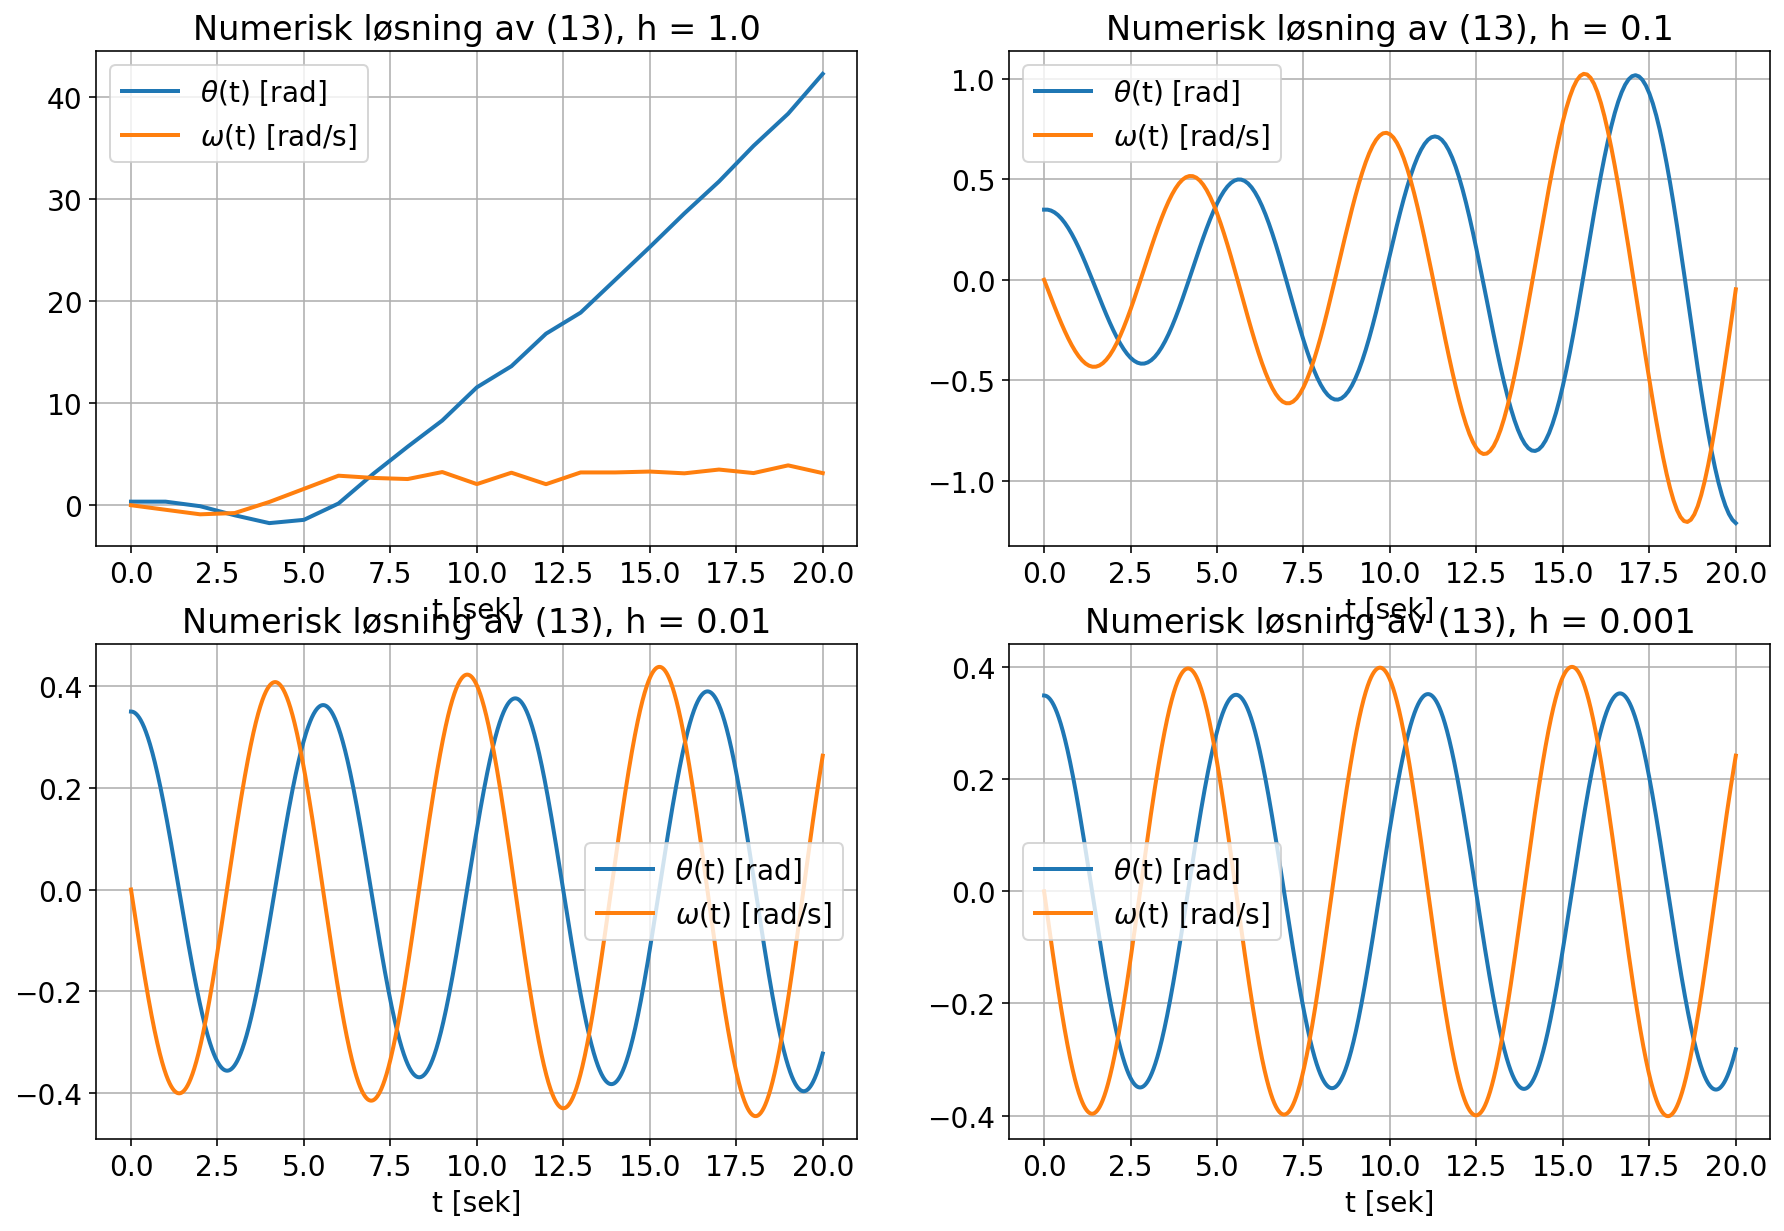

In [11]:
w20 = w_vec(np.radians(20), 0)    # Start-verdier for w(t_0) dvs. theta(t_0) og omega(t_0) i et array
t_lim = np.array([0, 20])         # Start- og slutt-verdi for t i et array

h_list = np.array([1, 0.1, 0.01, 0.001])      # Liste med forskjellige steglengder

fig, axs = plt.subplots(2, 2, figsize=(15,10))
t_num_1, w_num_1 = main(f_1d, w20, t_lim, h_list[0], Euler_method, kantring = False)
axs[0, 0].plot(t_num_1, w_num_1[:, :2])
axs[0, 0].set_title(f"Numerisk løsning av (13), h = {h_list[0]}")
axs[0, 0].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[0, 0].set_xlabel("t [sek]")

t_num_1, w_num_1 = main(f_1d, w20, t_lim, h_list[1], Euler_method, kantring = False)
axs[0, 1].plot(t_num_1, w_num_1[:, :2])
axs[0, 1].set_title(f"Numerisk løsning av (13), h = {h_list[1]}")
axs[0, 1].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[0, 1].set_xlabel("t [sek]")

t_num_1, w_num_1 = main(f_1d, w20, t_lim, h_list[2], Euler_method, kantring = False)
axs[1, 0].plot(t_num_1, w_num_1[:, :2])
axs[1, 0].set_title(f"Numerisk løsning av (13), h = {h_list[2]}")
axs[1, 0].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[1, 0].set_xlabel("t [sek]")

t_num_1, w_num_1 = main(f_1d, w20, t_lim, h_list[3], Euler_method, kantring = False)
axs[1, 1].plot(t_num_1, w_num_1[:, :2])
axs[1, 1].set_title(f"Numerisk løsning av (13), h = {h_list[3]}")
axs[1, 1].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[1, 1].set_xlabel("t [sek]");

Overfor ser vi fire forskjellige grafer som viser vinkelutslaget $\theta$ og vinkelhastigheten $\omega$ til skipet som påvirkes av gravitasjon og oppdriftskraften over $20$ sekunder. Alle har brukt samme startparametere og Eulers metode, men fire minkende steglengder. Man ser tydelig at effekten er nærmest dramatisk. Spesielt dramatisk ville det vært for Vasaskipet dersom steglengden hadde vært $1$. Da hadde vinkelutslaget vært mer enn $40$ radianer etter $20$ sekunder, noe som betyr at skipet hadde tatt flere fulle omdreininger rundt seg selv i løpet av alt for kort tid. For Vasaskipet den dagen var ikke steglengden i Eulers metode noe de trengte å bekymre seg over, men for oss er det kritisk for å lage en god nok modell. Selv om alle grafene beskriver samme system er det altså enorm forskjell på hvilken steglengde man bruker. Vinkelutslaget for de to minste steglengdene ligner mer på det man forventer fra en enkel harmonisk oscillator - amplituden holder seg konstant. For den nest største steglengden derimot divergerer utslaget alt for mye over tid til å kalle det nøyaktig nok. Selv om den nest minste gir divergens i vinkelutslag som er mindre enn sin forgjenger, er det dessverre ikke presist nok om man f.eks. ville se på skipets bevegelse over lengre tid. Derfor velger vi videre en steglengde $h = 0.001$ fordi den gir sinusodiale vinkelutslag som nesten ikke divergerer i amplitude. Hvis denne steglengden holder for Eulers metode, vil man med stor sannsynlighet si at det er også er tilstrekkelig for RK4, da denne er betydelig nøyaktigere enn førstnevnte.

### Oppgave 1e

Når vi først er inne på nøyaktighet av funksjoner, kan vi ta et oppgjør med ingeniørenes fundamentalteorem: $\sin(\theta) ≈ \theta$. Denne småvinkelapproksimasjonen er "pinlig mye" brukt for $\theta << 1$ og vi ønsker å ta en titt på hvor nøyaktig den egentlig er. Dette gjøres ved å oppdatere $\vec{f(t, \vec{w})}$ med $\theta$ istedenfor $\sin(\theta)$, og så se på feilen mellom metodene for to forskjellige startvinkler; $1^{\circ}$ og $20^{\circ}$. Logisk nok forventer vi at feilen mellom metodene er minst for den minste startvinkelen.

In [12]:
def f_approx(t, w):
    return np.array([w[1],
                     -m*g*h_MC/I_C*w[0],
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,])

In [13]:
w20 = w_vec(np.radians(20), 0)     # Startvinkel theta0 = 20°
w01 = w_vec(np.radians(1), 0)      # Startvinkel theta0 = 1°
h = 0.001                     # Valgt steglengde

# Småvinkel, theta0 = 20°
t_approx_20, w_approx_20 = main(f_approx, w20, t_lim, h, Euler_method)

# Småvinkel, theta0 = 1°
t_approx_01, w_approx_01 = main(f_approx, w01, t_lim, h, Euler_method)

# Ikke småvinkel, theta0 = 20°
t_num_20, w_num_20 = main(f_1d, w20, t_lim, h, Euler_method)

# Ikke småvinkel, theta0 = 1°
t_num_01, w_num_01 = main(f_1d, w01, t_lim, h, Euler_method)

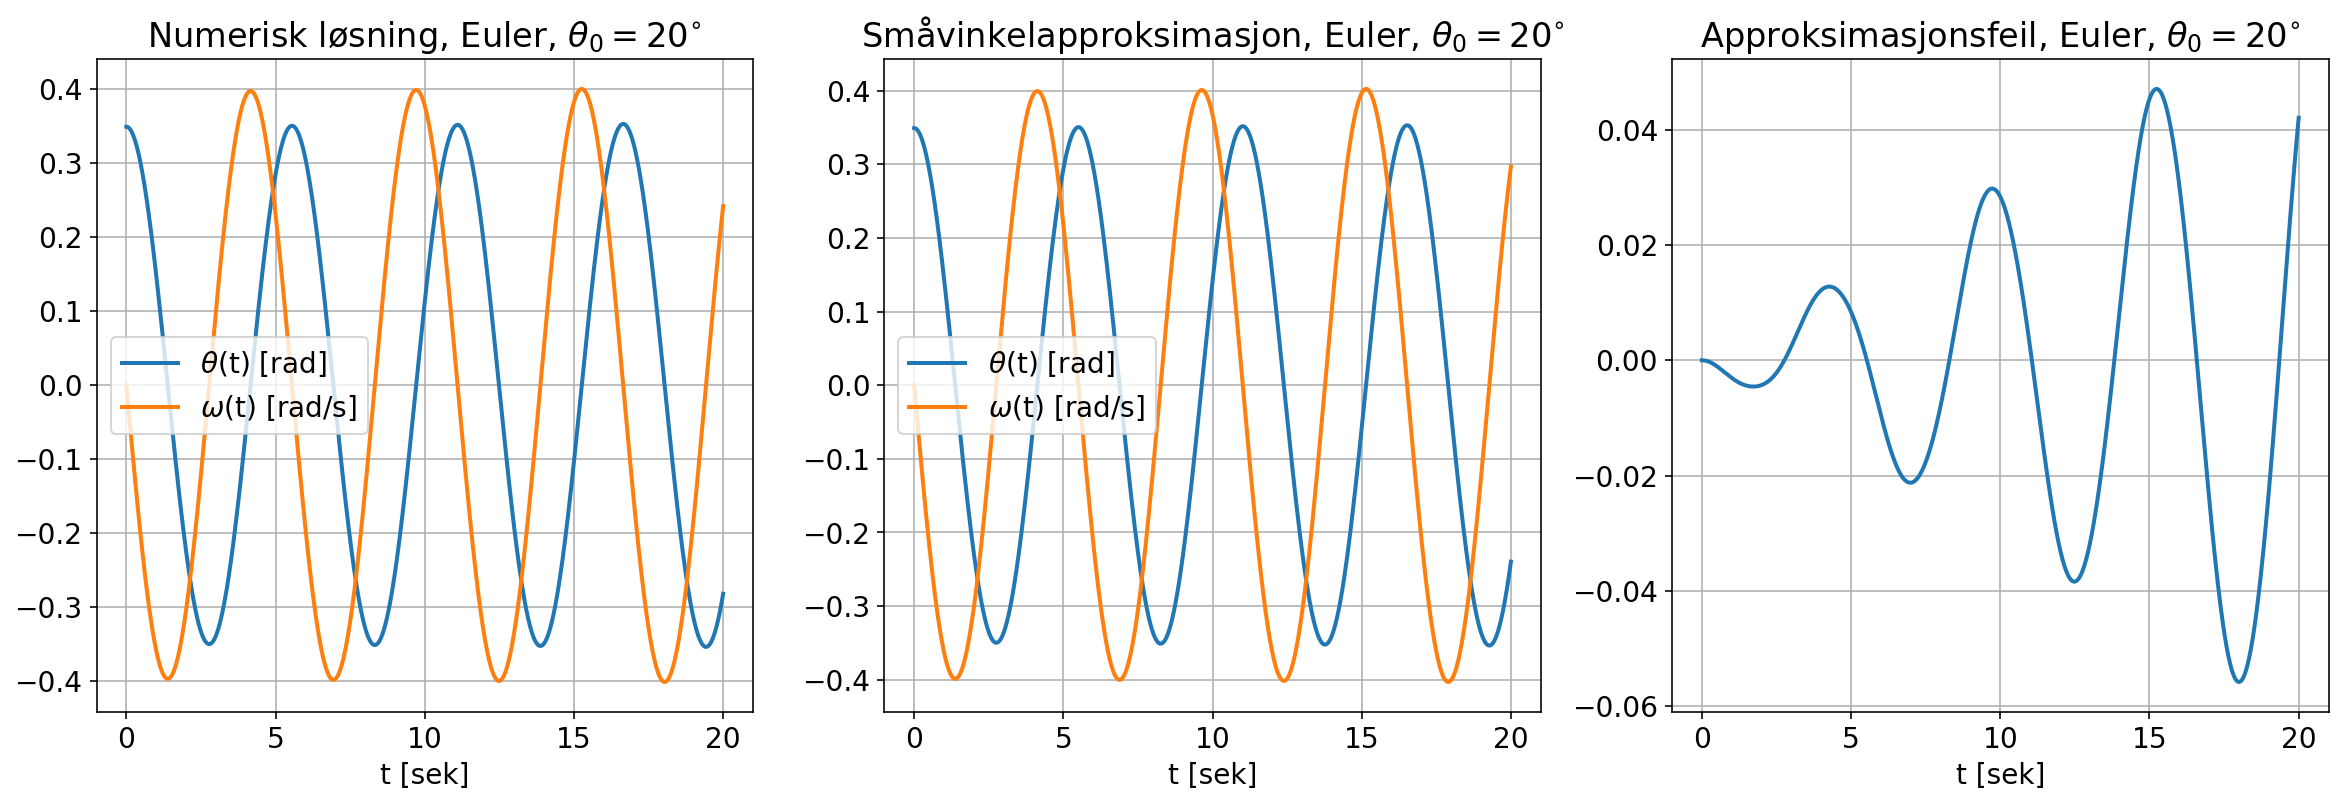

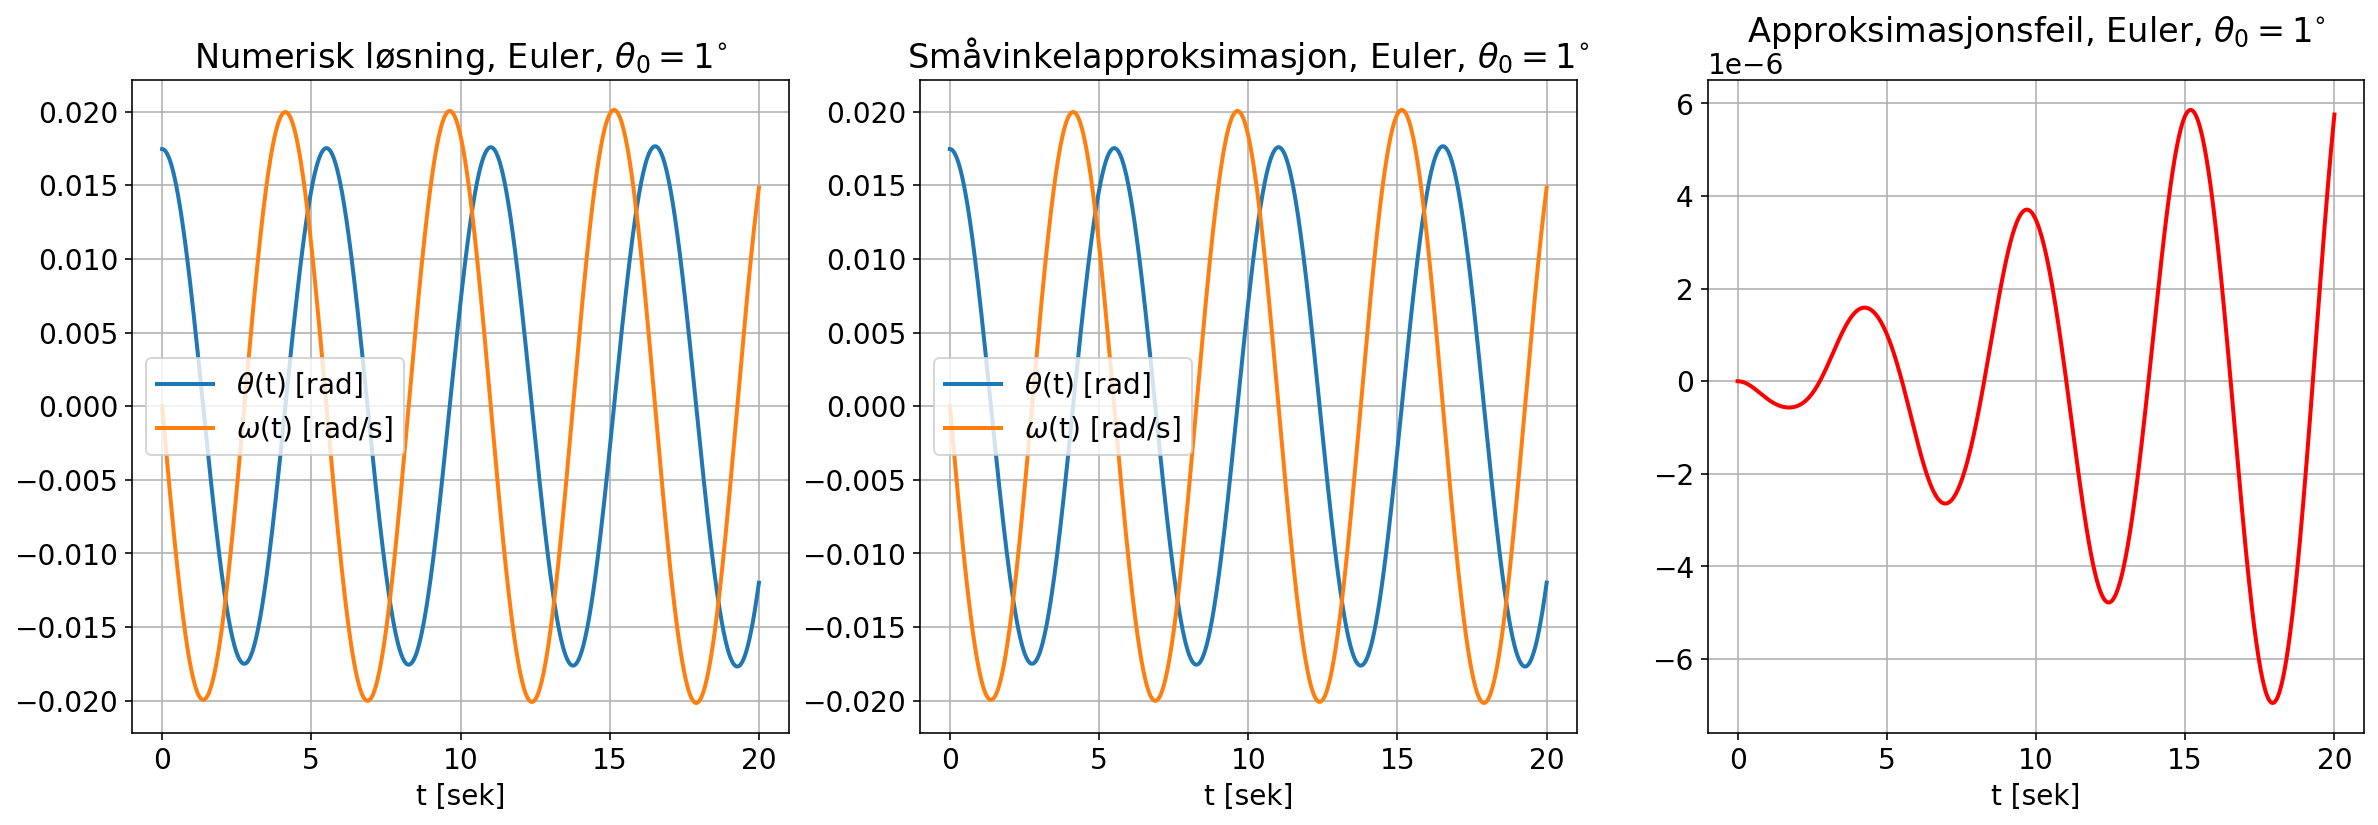

In [14]:
# theta0 = 20°
fig, axs = plt.subplots(1, 3, figsize = (20,6))
axs[0].plot(t_num_20, w_num_20[:, :2])
axs[0].set_title(r'Numerisk løsning, Euler, $\theta_{0} = 20^{\circ}$')
axs[0].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[0].set_xlabel("t [sek]")
axs[1].plot(t_approx_20, w_approx_20[:, :2])
axs[1].set_title(r"Småvinkelapproksimasjon, Euler, $\theta_{0} = 20^{\circ}$")
axs[1].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[1].set_xlabel("t [sek]")
axs[2].plot(t_num_20, w_approx_20[:,0]-w_num_20[:,0])
axs[2].set_title(r'Approksimasjonsfeil, Euler, $\theta_{0} = 20^{\circ}$')
axs[2].set_xlabel("t [sek]")

# theta0 = 1°
fig, axs = plt.subplots(1, 3, figsize = (20,6))
axs[0].plot(t_num_01, w_num_01[:, :2])
axs[0].set_title(r'Numerisk løsning, Euler, $\theta_{0} = 1^{\circ}$')
axs[0].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[0].set_xlabel("t [sek]")
axs[1].plot(t_approx_01, w_approx_01[:, :2])
axs[1].set_title(r'Småvinkelapproksimasjon, Euler, $\theta_{0} = 1^{\circ}$')
axs[1].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
axs[1].set_xlabel("t [sek]")
axs[2].plot(t_num_01, w_approx_01[:,0]-w_num_01[:,0], color="r")
axs[2].set_title(r'Approksimasjonsfeil, Euler, $\theta_{0} = 1^{\circ}$',y = 1.04)
axs[2].set_xlabel("t [sek]");

På øverste rad ser vi $sin(\theta)$-tilnærmingen etterfulgt av $\theta$-approksimasjonen, begge for $\theta_0 = 20^{\circ}$, og til slutt feilen mellom de to metodene. På raden under ser vi det samme, men med en annen startvinkel $\theta_0 = 1^{\circ}$. Approksimasjonsfeilen er som forventet i at den er mye mindre for $\theta_0 = 1^{\circ}$. Det er en helt annen størrelsesorden til og med. For den største startvinkelen er dessverre ikke feilen så liten at den kan neglisjeres. For større vinkler enn dette vil feilen igjen bli enda større - definitivt for stor til å bruke småvinkelapproksimasjonen med god fornuft. Samtidig ser man at feilen for den minste startvinkelen er liten nok til å gi ingeniører en klapp på skulderen. Et annet viktig moment å merke seg er at feilene også oscillerer med divergerende amplitude sfa. tiden. Dette kommer av at amplitudene i begge metoder vil divergere aldri så lite avhengig av steglengden, og oscillasjonen peker på at feilen mellom metodene er minst rundt likevektspunktet, og størst ved størst utsving - slik som forventet.

### Oppgave 1f

Vi har allerede definert RK4, så nå skal vi benytte denne metoden og se at vi får gode resultater.

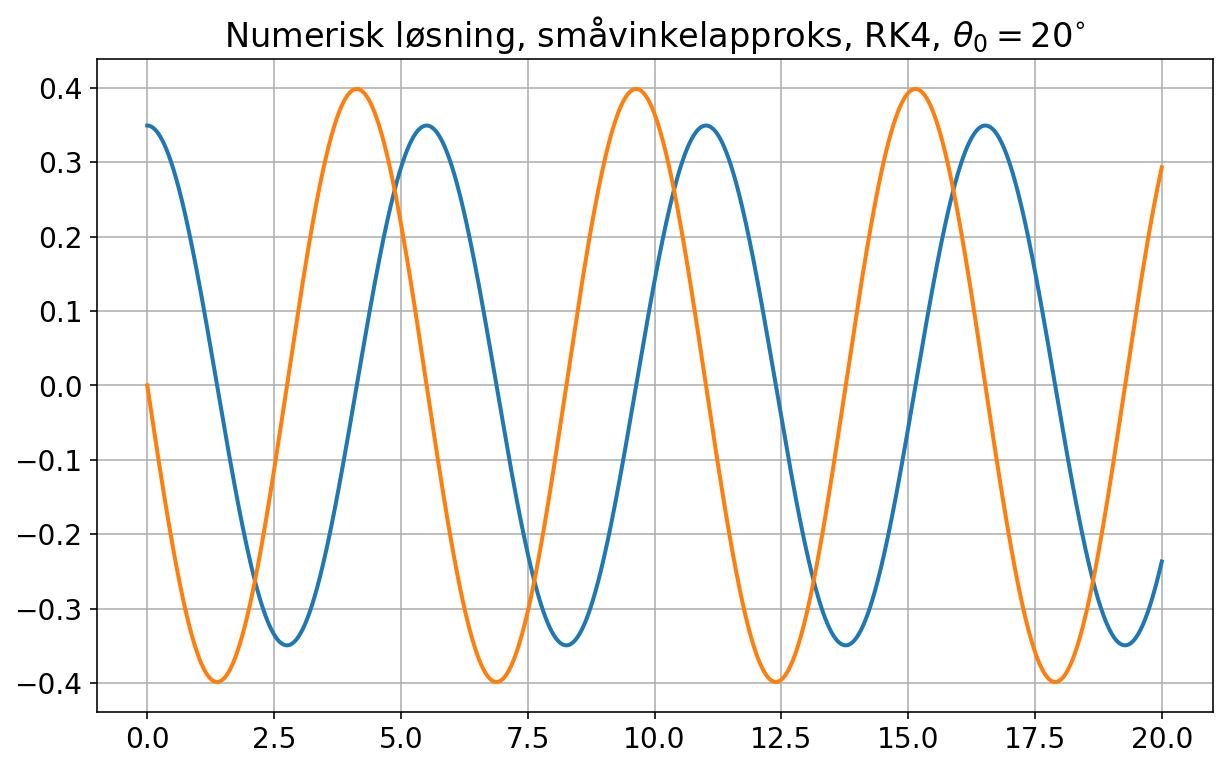

In [15]:
t_RK_20, w_RK_20 = main(f_approx, w20, t_lim)
plt.plot(t_RK_20, w_RK_20[:, :2])
plt.title(r'Numerisk løsning, småvinkelapproks, RK4, $\theta_{0} = 20^{\circ}$');

Dette stemmer godt med grafene fra forrige oppgave, da ved bruk av Euler. Som vi skal se senere er det store fordeler ved å bruke denne metoden.

### Oppgave 1g

Vi ønsker å løse $\sum \tau = \tau_B = I_C \frac{d\omega}{dt}$ analytisk med småvinkelapproksimasjonen, noe som gir ligningen

$$
-mgh\theta(t) = I_c \ddot{\theta}(t) \Rightarrow \ddot{\theta}(t) = -\frac{mgh\theta(t)}{I_c} = -\omega_0^2 \theta(t)
$$

$$
\ddot{\theta}(t) + \omega_0^2 \theta(t) = 0
$$

Gjetter (kvalifisert) at $\theta(t) = e^{rt}$ som gir ligningen $r^2e^{rt} + \omega_0^2e^{rt} = 0$

$$
e^{rt}(r^2 + \omega_0^2) = 0
$$

$$
e^{rt} ≠ 0 \Rightarrow r^2 + \omega_0^2 = 0
$$

$$
r = \sqrt{-\omega_0^2} = i\omega_0
$$

Dermed har man løsning på formen $\theta(t) = e^{rt} = e^{i\omega_0t} = A\sin(\omega_0t) + B\cos(\omega_0t), \;\; A, B \in \R$

Vi har to initialbetingelser: $\theta(0) = \theta_0$ og $ \dot{\theta}(0) = \omega(0) = 0$

$$
\theta(t) = A\sin(\omega_0 t) + B \cos(\omega_0 t)
$$
$$
\dot{\theta}(t) = \omega_0 A \cos(\omega_0t) - \omega_0 B \sin(\omega_0t) 
$$

$$
\dot{\theta}(0) = 0 = \omega_0A \Rightarrow A=0 \space \space(\omega_0 \neq 0)
$$

$$
\theta(t) = B\cos(\omega_0t)
$$
$$
\theta (0) = \theta_0 \Rightarrow B = \theta_0
$$
Dermed har vi en komplett analytisk løsning 
$$
\tilde{\theta} (t) = \theta_0 \cos(\omega_0 t) \space \space \space \space \left(\omega_0^2 = \frac{mgh}{I_c}\right)
$$

### Oppgave 1h

For å gi oss en idé om hvor god Runge-Kutta 4 algoritmen er, i forhold til Euler"-lgoritmen, ønsker vi å se på feilen i $\theta$ i hver av dem sammenliknet med den analytiske løsningen $\tilde{\theta}(t)$
Vi er selvsagt nødt til å bruke små vinkler, da vi i den analytiske utledningen brukte småvinkelapproksimasjon (vi velger $\theta_0 = 0.01$ rad).

Vi er ute etter å se på feilen i ett tidspunkt, og velger dermed tidspunktet $t = 20$.

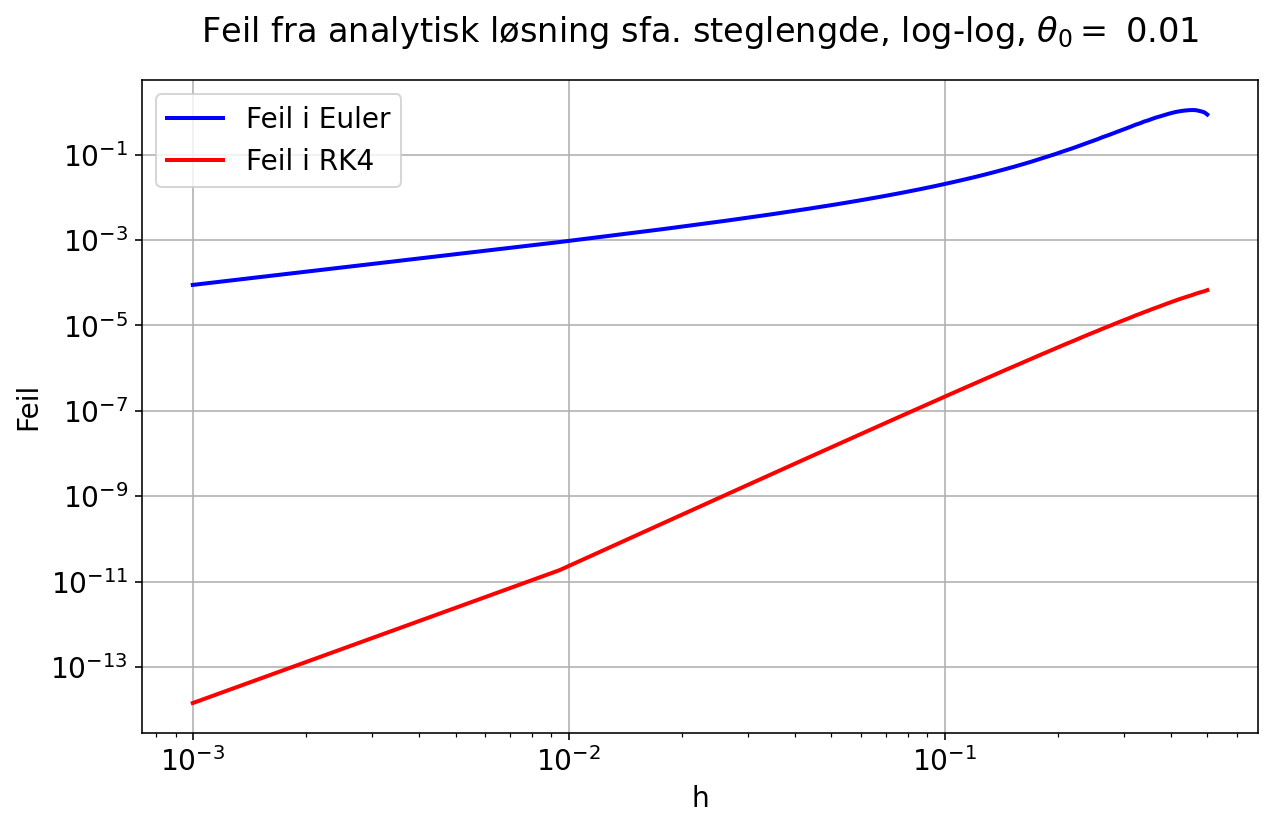

Største og minste feil i Euler: med h = 0.457712: 1.0988329875296419 ved h = 0.001: 8.883330550740493e-05
Største og minste feil i Runge-Kutta 4: med h = 0.5: 6.705904734572408e-05 ved h = 0.001: 1.4583820262537017e-14


In [16]:
omega0 = np.sqrt(m*g*h_MC/I_C)

theta_start_1e = 0.01     # [rad]
omega_start_1e = 0        # [rad/s]

w0_1e = w_vec(theta_start_1e, omega_start_1e)

t_1e_Euler, w_1e_Euler = main(f_approx, w0_1e, t_lim, h, Euler_method)
t_1e_RK4, w_1e_RK4 = main(f_approx, w0_1e, t_lim, h)

t_list_1e = np.linspace(0,20,len(w_1e_Euler[:,0]))
h_list_1h = np.linspace(0.5,0.001,60)               # Lager en array med 40 h-verdier fra 0.5 til 0.001
RK4_1h = np.array([])
Euler_1h = np.array([])
for i, vals in enumerate(h_list_1h):                 # Regner ut verdien til theta med ulike steglengder og tar det siste elementet
    t_1e_Euler, w_1e_Euler = main(f_approx, w0_1e, t_lim, vals, method = Euler_method, kantring = False)
    t_1e_RK4, w_1e_RK4 = main(f_approx, w0_1e, t_lim, vals, method = RK4)
    RK4_1h = np.append(RK4_1h, w_1e_RK4[-1,0])
    Euler_1h = np.append(Euler_1h, w_1e_Euler[-1,0])

plt.figure()
plt.loglog()
plt.title(rf'Feil fra analytisk løsning sfa. steglengde, log-log, $\theta_0 =$ {theta_start_1e}', y= 1.04)
plt.plot(h_list_1h,abs((theta_start_1e)*cos(omega0*20) - Euler_1h), color = 'blue', label = 'Feil i Euler')
plt.plot(h_list_1h,abs((theta_start_1e)*cos(omega0*20) - RK4_1h), color = 'red', label = 'Feil i RK4')
plt.xlabel('h')
plt.ylabel('Feil')
plt.legend()
plt.show()

print(f'Største og minste feil i Euler: med h = {h_list_1h[5]:2f}:',abs((theta_start_1e)*cos(omega0*20) - Euler_1h[5]),'ved h = 0.001:',abs((theta_start_1e)*cos(omega0*20) - Euler_1h[-1]))
print('Største og minste feil i Runge-Kutta 4: med h = 0.5:',abs((theta_start_1e)*cos(omega0*20) - RK4_1h[0]),'ved h = 0.001:',abs((theta_start_1e)*cos(omega0*20) - RK4_1h[-1]))


Her ser vi et tydelig skille! Dette er plottet i et log-log plot, der de minste $x$- og $y$-verdiene blir bedre representert. Vi kan med en gang se et par ting. Euleralgoritmens minste feil er større enn Runge-Kuttas største! Da vil det være omtrent like effektivt å bruke Euleralgoritmen med $h = 0.001$ som Runge-Kutta med $h = 0.5$!

Vi ser i tillegg at Runge-Kuttas feilgraf har en mye brattere hellning enn Eulers. Dette er viktig da det betyr at feilen går mot $0$ raskere enn Euler med samme endring i $h$. Dette er grunnen til at høyere ordens metoder er viktig!

Noen man må ha i bakhodet når man ser særlig på de feilverdiene som korresponderer med de høyeste $h$-verdiene er at de numeriske metodenes feilanalyse kun fungerer på små $h$. Grunnen til dette er at man kan ende med å bruke så store steg at man hopper over viktige detaljer.

Vi vet at $||e_n|| \leq Ch^p$, der $C > 0$ er en konstant og $p$ er metodens orden. Hvis vi nå antar at $C_{Euler} = C_{RK4} = 1$ (for eksempelets skyld) kan vi se at om vi ønsker en feil på maks $10^{-8}$, så vil:
$$
h_{RK4}^4 = 10^{-8} = h_{Euler}
$$
$$
h_{Euler} = 10^{-8}, h_{RK4} = 10^{-2}
$$

Dette sammen med plottet viser tydelig at høyere ordens metoder gir en stor fordel presisjonsmessig, men disse kan være vanskeligere å implementere.

## Oppgave 2a

Nå skal vi innføre $\gamma$ og $A$ i funksjonene som varierer med svingningen. Dette er ikke tatt hensyn til tidligere, og massesenteret vil nå også forflytte seg fordi oppdriftskraften endrer seg med den varierende $A$. Det gjør den fysiske pendel-modellen litt mer komplisert, og dermed også litt mer "ekte". Skipsmodellen vår befinner seg fortsatt i havna, så vi ser på de samme kreftene som tidligere, men noen er avhengige av $A$ eller $\gamma$ og dermed blir dynamikken litt annerledes. Vi tar høyde for massesenterets forflytning ved å utvide $\vec{w}$ til å inneholde $x$- og $y$-koordinatene til massesenteret, og tilhørende hastigheter $v_C^x$ og $v_C^y$, som tidligere var satt til $0$. For enkelthetens skyld setter vi startverdien til farten (i begge retninger) og $x$-komponenten lik $0$.

Foreløpig beveger ikke skipet seg horisontalt siden det kun er tyngdekraft og oppdriftskraft til stede. Dermed blir:

$$\sum F_y=ma_y=F_G+F_B=-mg+A\sigma_0g$$

Altså

$$\frac{d}{dt}v_C^y=a_y=\frac{A\sigma_0g-mg}{m}$$

$$\frac{d}{dt}x_C=v_C^x$$

$$\frac{d}{dt}y_C=v_C^y$$

$$\frac{d}{dt}v_C^x=0$$

i de neste oppgavene.

In [17]:
def f_2a(t, w):
    """
    INPUT:
    t:      float, tidsverdien
    w:      numpy array, alle variablene til systemet
    ---
    ---
    OUTPUT:
    w_diff: numpy array, alle verdiene til den deriverte av w i tidspunktet t
    """
    gamma = 2*arccos(cos(beta/2)-4/(3*pi)*(1-cos(w[0]))+(w[3] - y_C0)/R)
    A = 1/2*R**2*(gamma-sin(gamma))
    return np.array([w[1],
                    -A*sigma0*g*h_MC/I_C*sin(w[0]),
                    w[4],
                    w[5],
                    .0,
                    (A*sigma0*g-m*g)/m,
                    0,
                    0])

## Oppgave 2b

In [18]:
t_lim_2b = [0, 20]
theta_start_2b = np.radians(20)
omega_start_2b = 0

w0_2b = w_vec(theta_start_2b, omega_start_2b)
t_2b, w_2b = main(f_2a, w0_2b, t_lim_2b, h, RK4)

Text(0.5, 1.0, 'Massesenterets høyde sfa. tid')

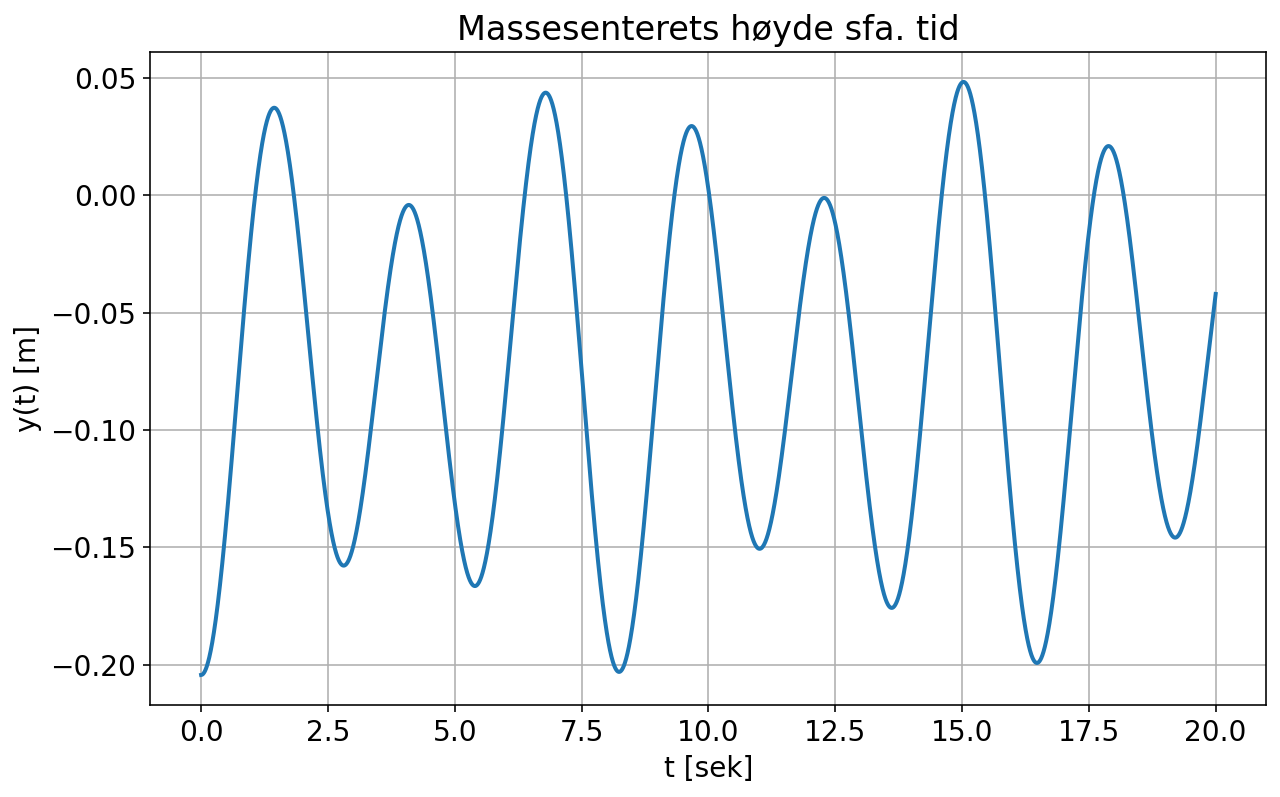

In [19]:
plt.figure()
plt.plot(t_2b, w_2b[:, 3], label=r"$y_C(t)$")
plt.xlabel("t [sek]")
plt.ylabel("y(t) [m]")
plt.title("Massesenterets høyde sfa. tid")

Her ser vi massesenterets bevegelse i $y$-retning som funksjon av tiden. Massesenterets høyde over vann, som vi har regnet ut tidligere med $Y_C^0$, vil ha samme verdi når vi starter båten med en liten helningsvinkel. Derfor ser vi at grafen starter i litt under $-0.2$ meter. Men båten er ikke i likevekt, og siden mer vann er fortreng vil båten få en større oppdriftskraft som bidrar til translasjon ut av likevekt. Tidligere har det fortrengte arealet vært konstant og dermed så man kun bidrag til rotasjon ut av likevekt. Man får dermed en oscillerende effekt også i translasjon-sammenheng da oppdriftskraften kjemper mot gravitasjonen om nytt likevektspunkt. Det øverste punktet på grafen er ved rundt $0.05$ meter som er rett over vannoverflaten. Relativt til skipets radius er ikke translasjonen i $y$-retning stor, men det bidrar til svevning, og vi kan derfor konkludere med at variasjonen av fortrengt vann har betydning for skipets bevegelse. På det meste øker høyden med $25$ centimeter, noe som menneskene på Vasa trolig nok ville merket.

At sveving forekommer innebærer at de to forskjellige periodiske bevegelsene, rotasjon og vertikal translasjon, har forskjellige moder for svingningene sine som interfererer. Disse modene må også ha noe forskjellig naturlig frekvens for at sveving skal forekomme, ellers hadde man observert ren konstruktiv eller destruktiv interferens. Resultatet av sveving ser vi i figuren over: amplituden varierer periodisk. Amplituden vil altså nå svinge med en egen frekvens, som bestemmes av frekvensforskjellen for de forskjellige modene.

### Oppgave 2c

Opp til nå kan man se at utslaget for $\theta$ kan ha vært så stor at båtkanten har duppet under vann uten konsekvenser. Til kongens, og hele Sveriges skuffelse er det ikke nødvendigvis slik båtmekanikk fungerer, og vi skal derfor introdusere et begrep som Vasa-mannskapet dessverre var godt kjent med: kantring.

Betingelsen og resultatet av kantring i våre simuleringer er beskrevet i starten av rapporten, og er allerede implementert i `ode_solver()`. Dermed, ved å sette parameteren `kantring=True` inni `main()`, vil eventuell kantring tas høyde for.

Vi ønsker å finne den minste starthastigheten for rotasjon som gir kanting, og begynner båten uten helningsvinkel. For å bestemme dette fastsatte vi at vi ønsket en nøyaktighet til tredje desimal, for så å utføre diverse intervallhalveringer inntil første verdi som resulterer i kantring ble funnet. Under har vi visualisert grafer med forskjellige initiale vinkelhastigheter omkring minste verdi som gir kantring.

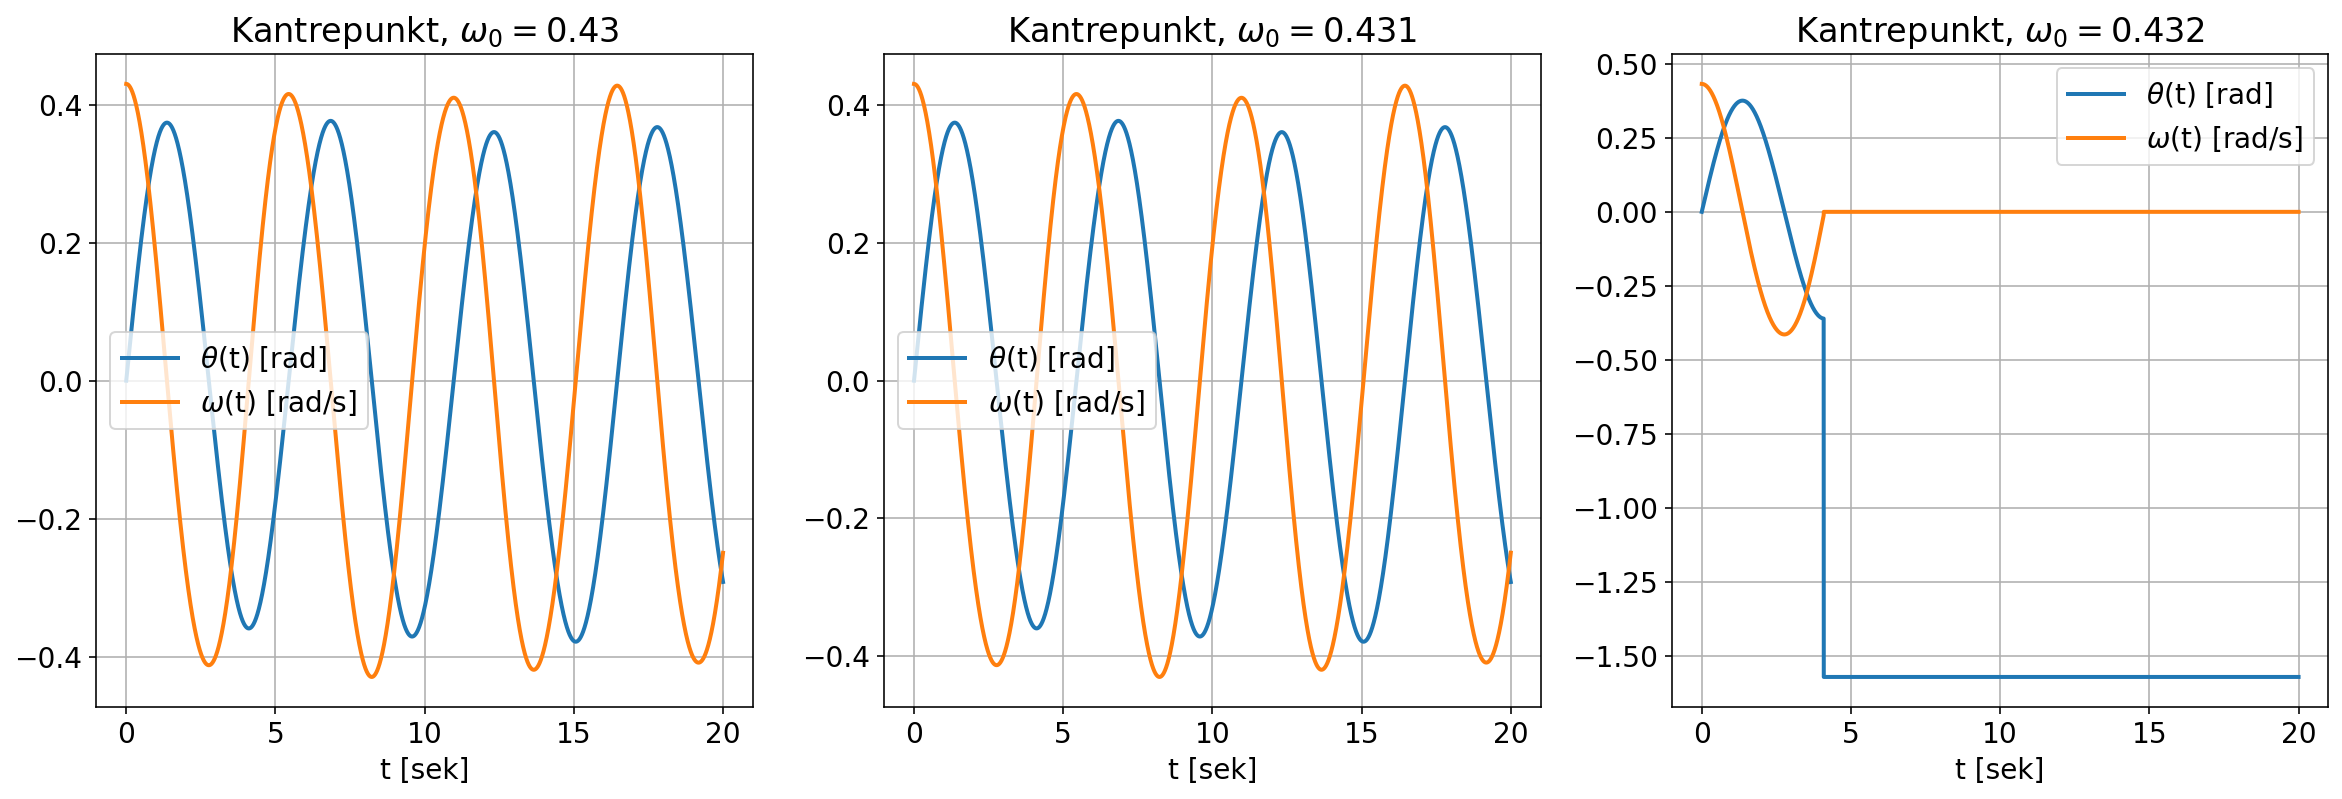

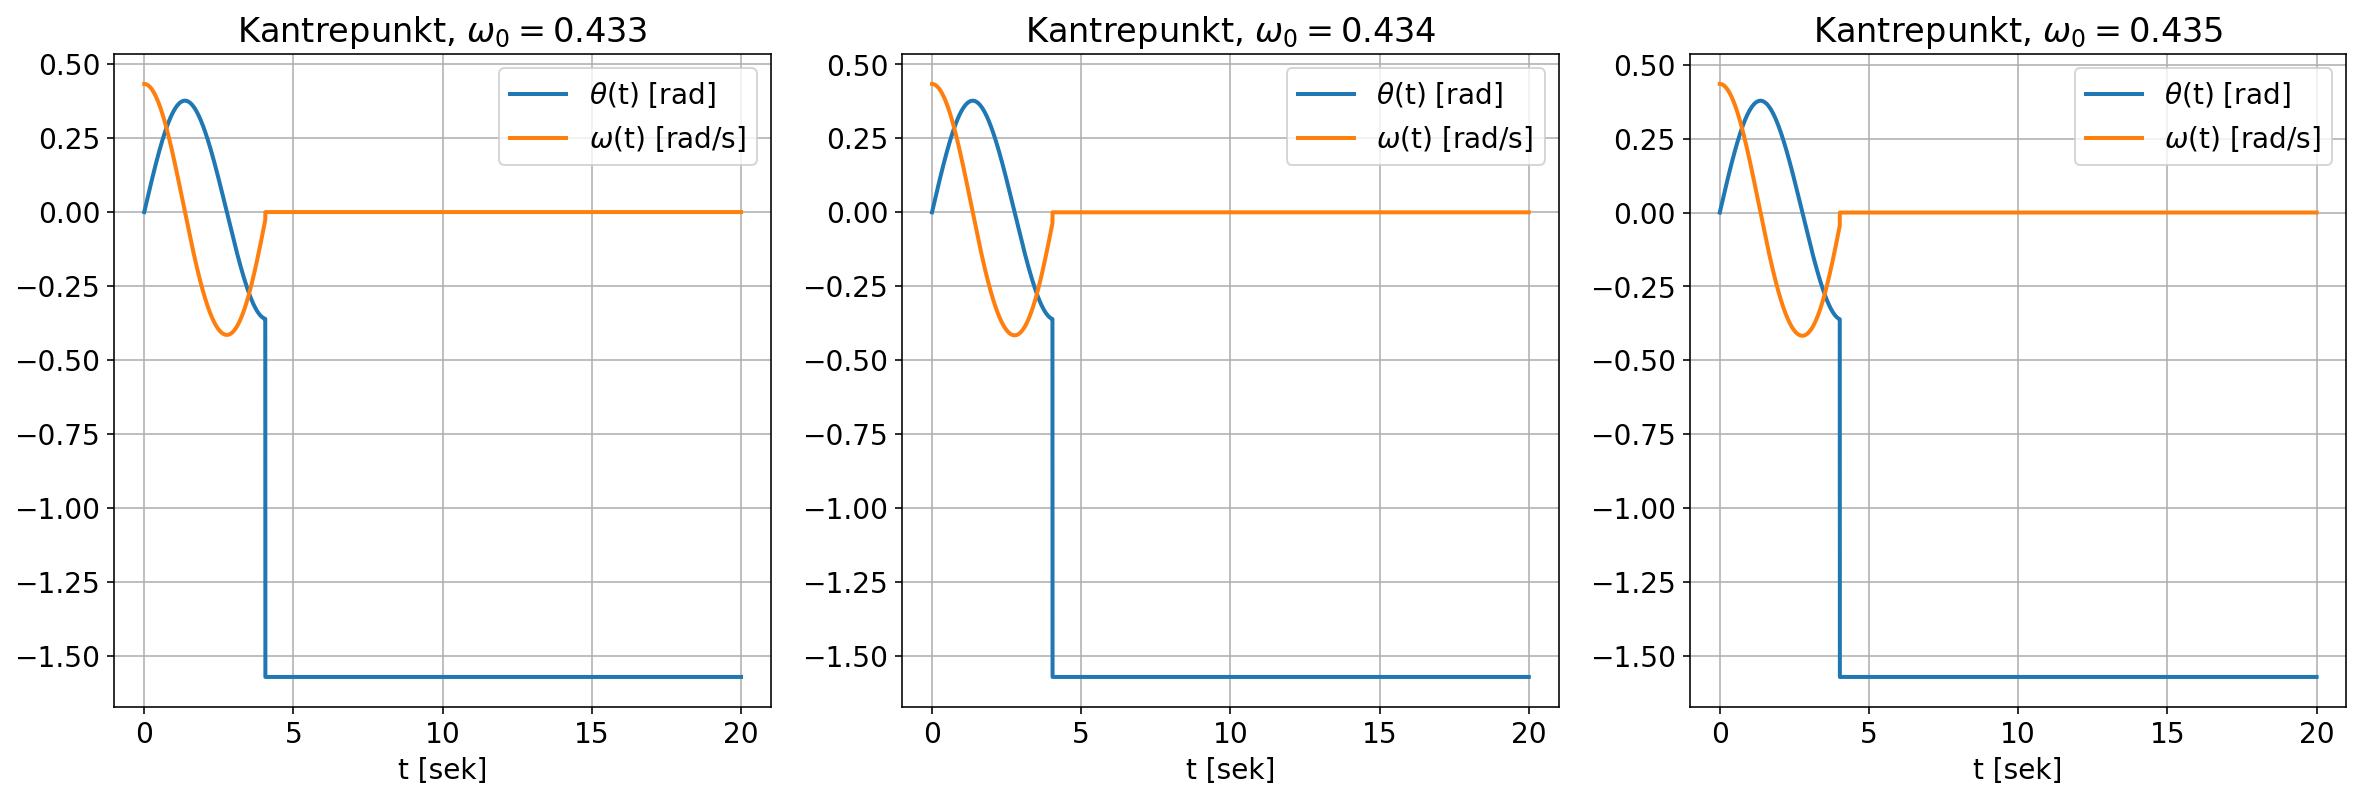

In [20]:
theta_start_2c = np.radians(0)
omega_start_2c = np.linspace(0.43, 0.435, 6)

for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize = (20,6))
    for j in range(3):
        w_2c = w_vec(theta_start_2c, omega_start_2c[i*3+j])
        t_RK_2c, w_RK_2c = main(f_2a, w_2c, t_lim)
        axs[j].plot(t_RK_2c, w_RK_2c[:, :2])
        axs[j].set_title(rf'Kantrepunkt, $\omega_{0} = {omega_start_2c[i*3+j]}$')
        axs[j].legend([r"$\theta$(t) [rad]", r"$\omega$(t) [rad/s]"])
        axs[j].set_xlabel("t [sek]")


I praksis har vi nå satt ut seks båter med bittelitt varierende starthastigheter i rotasjon hvorav fire av båtene har kantret i havna. De to første skipene overlevde i løpet av $20$ sekunder, men når starthastigheten $\omega_0$ blir $0.432$ eller større vil skipet gå under. Et sted mellom $0.431$ og $0.432$ vil være den nøyaktige starthastigheten for kantring, og vi konkluderer derfor at $\omega_0 = 0.4315$ radianer pr. sekund vil være et godt nok estimat for kritiske $\omega_0$. Med $\theta_0 = 0$ radianer vil det ha seg slik at $\omega_0 = -0.4315$ radianer pr. sekund også vil gi kantring, fordi negativt fortegn betyr bare at skipet starter rotasjonen andre veien. 

### Oppgave 2d

Til nå har vi sett på båtmodellen i havna for seg selv. Der er det ikke vind eller bølger, og det er heller ingen folk ombord. Det står ingen kanoner på dekk og heller ingen løse tau eller andre gjenstander. Med andre ord; et veldig lite fungerende skip. Dette må vi gjøre noe med. Vi tenker oss at gjenstandene er samlet i ett punkt med total masse $m_L$. Dette resulterer i at den totale massen av skipet effektivt blir $m\rightarrow m+m_L$. Vi vil referere til total masse med $m$, enten det er last eller ikke på dekk. Grunnet et slapt mannskap er ikke denne lasten festet skikkelig med tau, og den kan derfor skli friksjonsfritt langs dekket. I tillegg til å ha sin egen dynamikk, påvirker den også rotasjonen til skipet. Først skal vi se på et skip uten gjerder - noe som definitivt bryter riktig HMS etikette, men vi skal etterhvert sette opp gjerder på begge sider. Vi velger et koordinatsystem for punktmassen der hvor $y$-aksen alltid står vinkelrett på dekket, mens $x$-aksen går langs dekket. Da ser man at

$$
\sum F_{y} = 0
$$

$$
\sum F_{x} = mgsin(\theta) = ma_{L} \Rightarrow a_{L} = \dot{v_L} = gsin(\theta)
$$

I tillegg utfører lasten kraft og dreiemoment på skipet. Akselerasjon og dreieakselerasjon beregnes altså også her vha. Newtons andre lov.

$$\sum F_x=ma_x=F_L^x=m_Lg\cos(\theta)\sin(\theta)$$

$$\sum F_y=ma_y=F_G+F_B+F_L^y=-mg+A\sigma_0g-m_Lg\cos^2(\theta)$$

$$\sum\tau=I_C\alpha=\tau_B+\tau_L=-A\sigma_0gh\sin(\theta)-m_Lgs_L\cos(\theta)$$

Vi utvider så $\vec{w}$ og deriverer denne for å få på formen $\frac{d}{dt} \vec{w}(t) =  \vec{f}(t,\vec{w})$

$$
\vec{w} = \begin{bmatrix} \theta \\ \omega \\ x_C \\ y_C \\ v_C^x \\ v_C^y \\ s_L \\ v_L \end{bmatrix}
$$

$$
\frac{d}{dt}\vec{w} = \frac{d}{dt}\begin{bmatrix} \theta \\ \omega \\ x_C \\ y_C \\ v_C^x \\ v_C^y \\ s_L \\ v_L \end{bmatrix} =
\begin{bmatrix} \dot{\theta} \\ \dot{\omega} \\ \dot{x_C} \\ \dot{y_C} \\ \dot{v_C^x} \\ \dot{v_C^y} \\ \dot{s_L} \\ \dot{v_L} \end{bmatrix} = \begin{bmatrix} \omega \\ \frac{A\sigma g h\sin(\theta)-m_Lgs_L\cos(\theta)}{I_C} \\ v_C^x \\ v_C^y \\ \frac{m_Lg\cos(\theta)\sin(\theta)}{m} \\ \frac{A\sigma_0g-mg-m_Lg\cos^2(\theta)}{m} \\ v_L \\ g\sin(\theta) \end{bmatrix} = \vec{f}(t,\vec{w})
$$

Skipets masse $m_S$ er samlet som en punktpartikkel i massesenter (CM). Båten vil dermed rotere om aksen som går gjennom massesenter og som står vinkelrett på planet. Problemene oppstår når man introduserer $m_L$. Vi behandler denne også som en punktpartikkel, men da har systemet (skip + last) fått et nytt massesenter. Formelen for hvor dette nye CM ligger i forhold til det gamle er gitt som

$$
\frac{m_Ld}{m_S + m_L},
$$

der $d$ er avstanden mellom punktpartiklene til en hver tid. Lasten beveger seg langs dekket, og $d$ kan dermed uttrykkes som $\sqrt{s_L^2 + h^2}$. Først ønsker vi å se på hvor nytt CM vil ligge, og dermed hvordan treghetsmomentet vil endre seg når man tar hensyn til lasten.

For enkelhetens skyld skriver vi at massen til lasten kan uttrykkes som en andel av massen til skipet, altså at $m_L = \phi m_S$. Uttrykket blir da

$$
\frac{\phi m_S}{m_S + \phi m_S}\sqrt{s_L^2 + h^2}
$$

Vi ønsker å se på hvor mye avstanden fra CM (gammelt) til CM´ (nytt) er som andel av avstanden $d$ mellom punktpartiklene og vi setter opp

$$
\frac{\phi m_S}{m_S + \phi m_S}\sqrt{s_L^2 + h^2} = \xi \sqrt{s_L^2 + h^2}
$$

der $\xi$ på samme måte som $\phi$ er en proporsjonalitetskonstant. ($\xi$: andel av $d$, $\phi$: andel av $m_S$). Vi stryker et par felles faktorer og står igjen med

$$
\frac{\phi }{1 + \phi} = \xi  \space \Leftrightarrow \space \phi = \frac{\xi}{1-\xi}
$$

La oss se på et par verdier av $\xi$ og dermed hvor stor $m_L$ må være for denne avstanden.

$$
\xi =0.1: \space \phi ≈ 0.111 \Rightarrow m_L ≈ 0.111m_S
$$

$$
\xi =0.2: \space \phi = 0.25 \Rightarrow m_L = 0.25m_S
$$

$$
\xi =0.3: \space \phi ≈ 0.429 \Rightarrow m_L ≈ 0.429m_S
$$

$$
\xi =0.4: \space \phi ≈ 0.666 \Rightarrow m_L ≈ 0.666m_S
$$

$$
\xi =0.5: \space \phi = 1 \Rightarrow m_L = m_S
$$

Da ser vi at dersom vi vil at avstanden fra CM til CM´ f.eks. skal være mindre enn $10\%$ av avstanden $d$ mellom punktpartiklene, så må den andre punktpartikkelen, altså lasten, ha en masse som er mindre enn $11.1\%$ av massen til skipet. La oss se på hvordan avstanden fra CM til CM' vil være for de faktiske verdiene for $m_L$ vi skal bruke i oppgaven.

$$
m_L = 0.001m_S \Rightarrow \phi = 0.001: \space \xi ≈ 0.001
$$

$$
m_L = 0.08m_S \Rightarrow \phi = 0.08: \space \xi ≈ 0.074
$$

$10\%$ er for fysikere mye brukt som et slingringsmonn på hvor mye et resultat kan variere fra fasit og fortsatt være et gyldig resultat. Siden dette er et prosjekt i teknisk fysikk konkluderer vi med at dersom avstanden fra CM til CM´ er mindre enn $10\%$ av avstanden mellom punktpartiklene, kan man anse at forflytningen av CM vil være neglisjerbar. Som vist må massen $m_L$ være mindre enn $0.111m_S$ dvs. ca. $11.1\%$ av skipets masse for at denne tilnærmelsen ($\xi < 0.1$) skal være valid. Begge massene vi skal bruke har $\phi$ godt under den kritiske $11.1\%$ og vi kan med god grunn neglisjere forflytningen av masssenteret. Dette sparer oss for unødige komplikasjoner og andre svært inngående beregninger.

Likevel må vi se hvordan skipets treghetsmoment endrer seg når man tar hensyn til last på dekket. Treghetsmomentene er gitt som

$$
I_{CM} = \frac{1}{2}m_SR^2(1-\frac{32}{9 \pi^2})
$$

$$
I_{CM´} = I_{CM} + m_Ld^2
$$

hvor siste kommer fra Steiners sats. Vi vil se på hvor mye $I_{CM´}$ øker og dermed om det er mulig å neglisjere økningen.

$$
\frac{I_{CM´}}{I_{CM}} = \frac{I_{CM}+ m_Ld^2}{I_{CM}} = 1 + \frac{m_Ld^2}{\frac{1}{2}m_SR^2(1-\frac{32}{9 \pi^2})} = 1 + \frac{m_L(s_L^2 + h^2)}{\frac{1}{2}m_SR^2(1-\frac{32}{9 \pi^2})}
$$

Vi studerer ytterpunktet $s_L = \pm R$ og den største massen vi skal ta hensyn til, dvs. $m_L = 0.08m_S$, slik at ligningen blir

$$
1 + \frac{0.08 m_S(R^2 + (0.42R^2)}{\frac{1}{2}m_SR^2(1-\frac{32}{9 \pi^2})} = 1 + \frac{0.08(1 + 0.42^2)}{\frac{1}{2}(1-\frac{32}{9 \pi^2})} = 1.2942
$$

Dvs. at treghetsmomentet øker med $29\%$ når man plasserer en last med masse $0.08m_S$ i ytterpunktene. Dette er for stort til å kunne neglisjere effekten med god samvittighet, så treghetsmomentet må oppdateres sfa. hvor lasten befinner seg.

$$
I = \frac{1}{2}m_SR^2(1-\frac{32}{9 \pi^2}) + m_L(s_L^2 + h ^2)
$$

Med dette sagt, definerer vi vårt system av ODL-er slik nevnt ovenfor. Nok en gang definerer vi $\vec{w}$ på nytt slik at den tar hensyn til lastens dynamikk ved å oppdatere verdier som tidligere var satt til $0$.


In [21]:
def f_2d(t, w):
    gamma = 2*arccos(cos(beta/2)-4/(3*pi)*(1-cos(w[0]))+(w[3] - y_C0)/R)
    A = 1/2*R**2*(gamma-sin(gamma))
    return np.array([w[1],
                    (-A*sigma0*g*h_MC*sin(w[0])-m_L*g*w[6]*cos(w[0]))/I_C,
                    w[4],
                    w[5],
                    m_L*g*cos(w[0])*sin(w[0])/m,
                    (A*sigma0*g-m*g-m_L*g*cos(w[0])**2)/m,
                    w[7],
                    -g*sin(w[0])])

Vi kjører to simuleringer med forskjellige masser for lasten: $m_L=0.001m_S$ og $m_L=0.08m_S$. Vi kjører simuleringene i $40$ sekunder og med startbetingelser $\theta_0=0$ rad, $\omega_0=0.2$ rad/s og $s_L(t=0)=3$ m.

In [22]:
t_lim_2d = [0, 40]
theta0_2d, omega0_2d, s_L0, m_L0 = 0, 0.2, 3, [0.001, 0.08]

w0_2d = w_vec(theta0_2d, omega0_2d, s_L = s_L0)

t1_2d, w1_2d = main(f_2d, w0_2d, t_lim_2d, last = m_L0[0])
t2_2d, w2_2d = main(f_2d, w0_2d, t_lim_2d, last = m_L0[1])

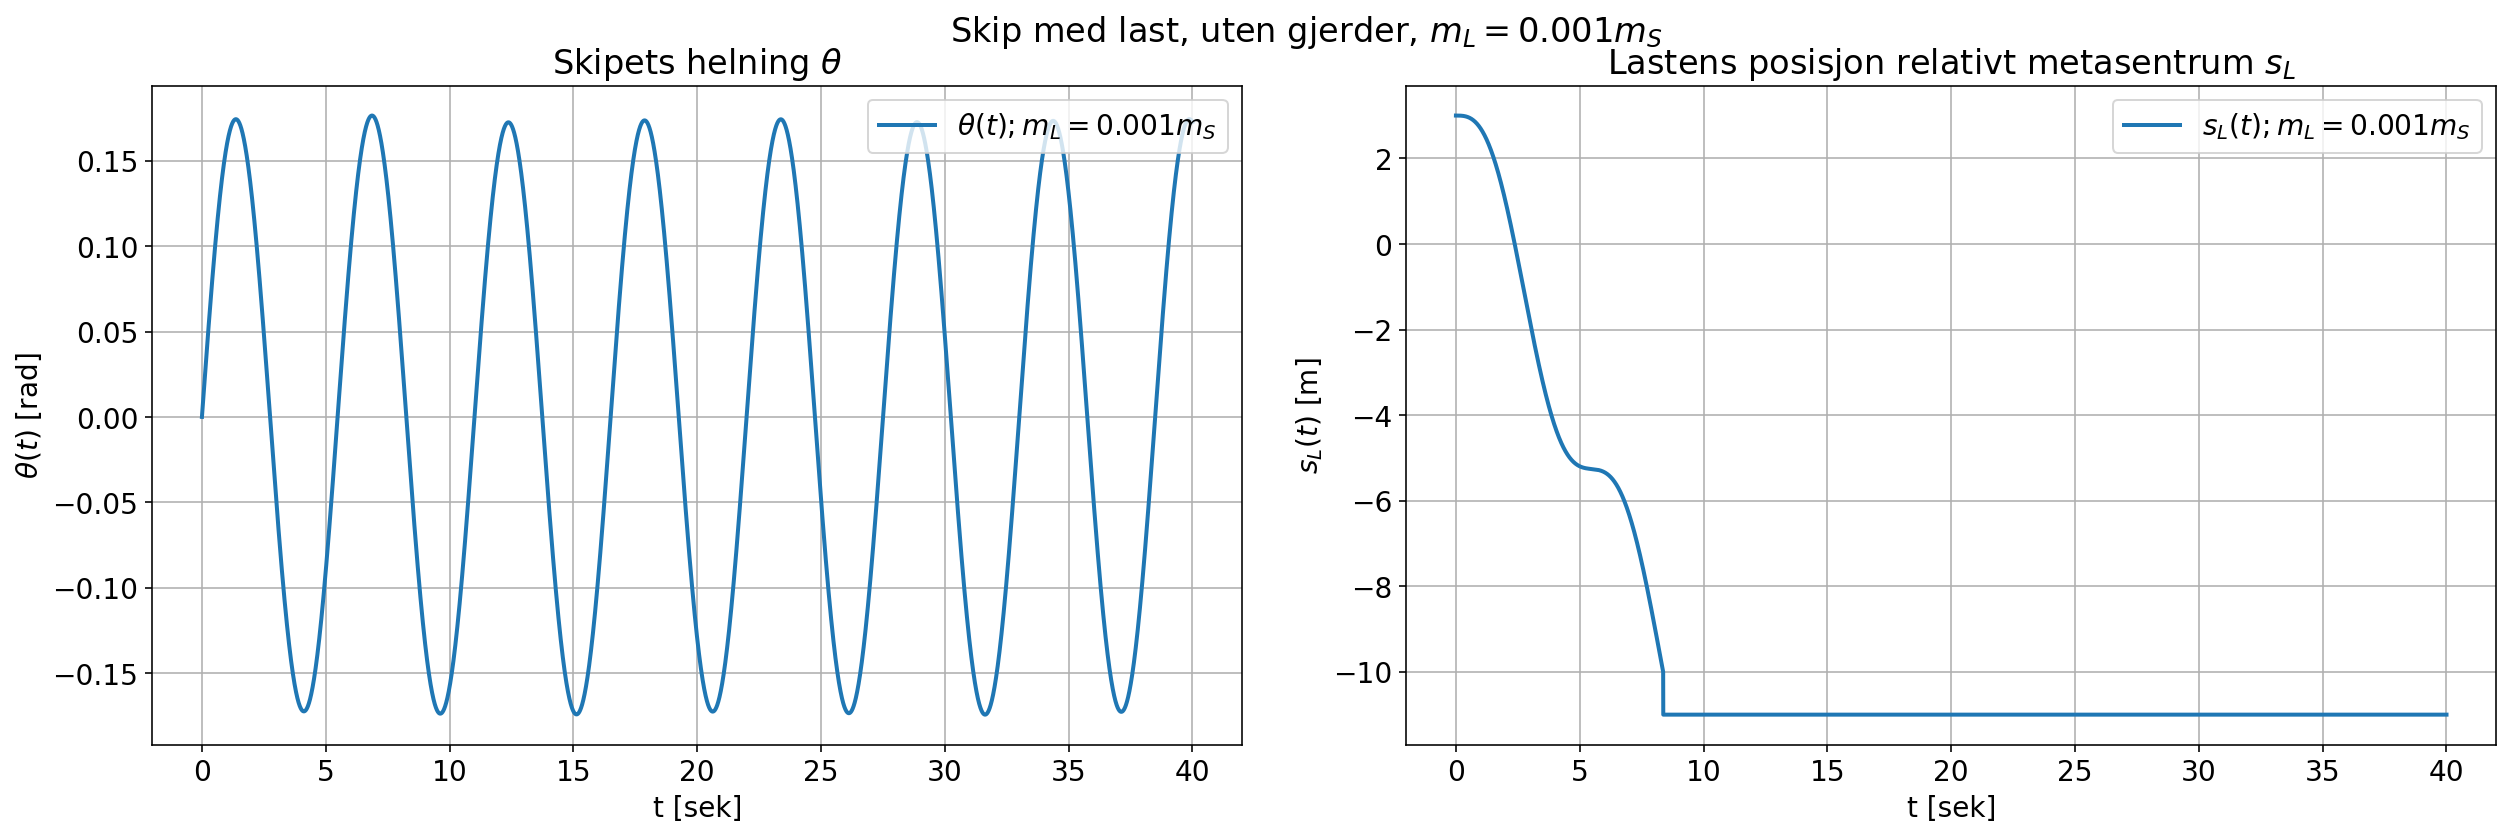

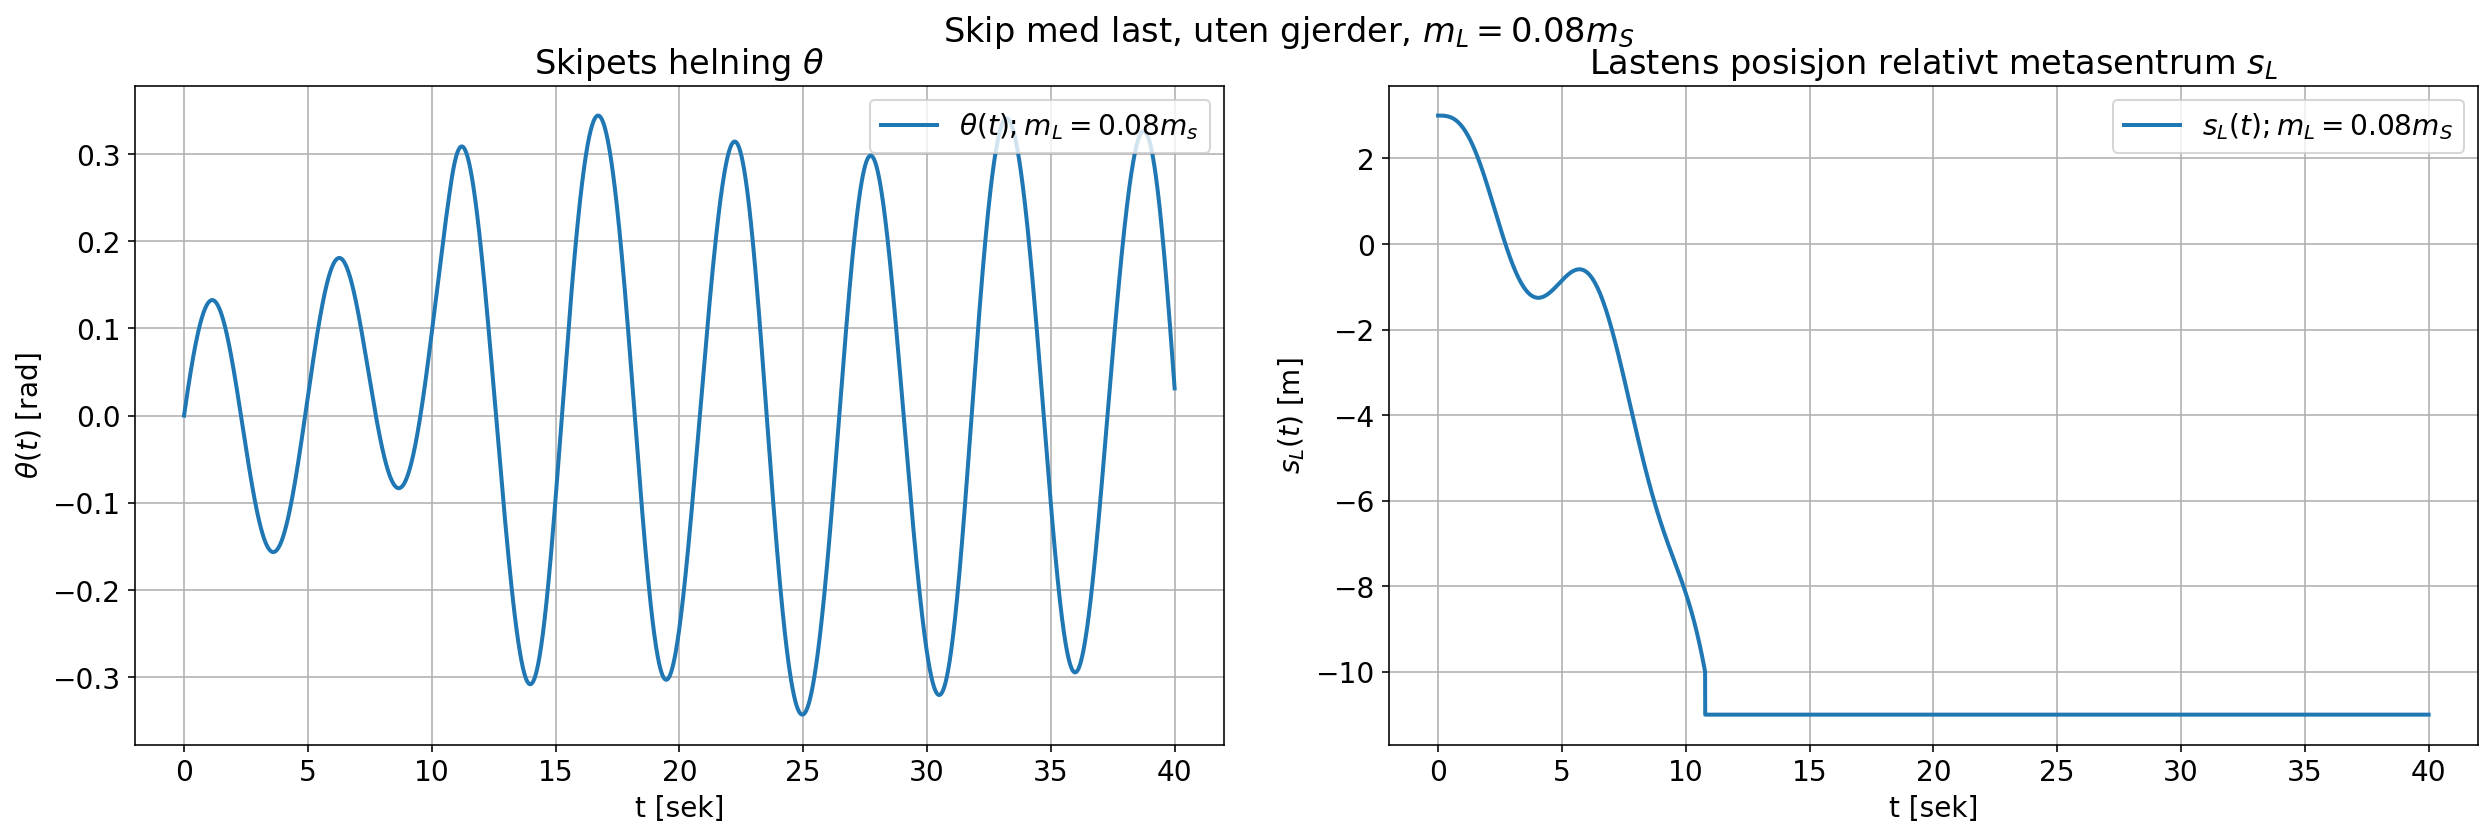

In [23]:
fig, axs = plt.subplots(1,2, figsize=(18, 7))
fig.suptitle(rf"Skip med last, uten gjerder, $m_L = {m_L0[0]}m_S$", y=0.85)
fig.tight_layout(pad=3)

axs[0].plot(t1_2d, w1_2d[:, 0], label=rf"$\theta(t); m_L={m_L0[0]}m_S$")
axs[0].set_title(r"Skipets helning $\theta$")
axs[0].set_xlabel("t [sek]")
axs[0].set_ylabel(r"$\theta(t)$ [rad]")
axs[0].legend(loc=1)

axs[1].plot(t1_2d, w1_2d[:, 6], label=rf"$s_L(t); m_L={m_L0[0]}m_S$")
axs[1].set_title(r"Lastens posisjon relativt metasentrum $s_L$")
axs[1].set_xlabel("t [sek]")
axs[1].set_ylabel(r"$s_L(t)$ [m]")
axs[1].legend()

fig, axs = plt.subplots(1,2, figsize=(18, 7))
fig.suptitle(rf"Skip med last, uten gjerder, $m_L = {m_L0[1]}m_S$", y=0.85)
fig.tight_layout(pad=3)

axs[0].plot(t2_2d, w2_2d[:, 0], label=rf"$\theta(t); m_L={m_L0[1]}m_s$")
axs[0].set_title(r"Skipets helning $\theta$")
axs[0].set_xlabel("t [sek]")
axs[0].set_ylabel(r"$\theta(t)$ [rad]")
axs[0].legend(loc=1)

axs[1].plot(t2_2d, w2_2d[:, 6], label=rf"$s_L(t); m_L={m_L0[1]}m_S$")
axs[1].set_title(r"Lastens posisjon relativt metasentrum $s_L$")
axs[1].set_xlabel("t [sek]")
axs[1].set_ylabel(r"$s_L(t)$ [m]")
axs[1].legend();

Fra figurene ser vi at vinkelutslaget nærmest ikke blir påvirket av lasten når $m_L = 0.001m_S$, men at utslaget påvirkes i stor grad med $m_L = 0.08m_S$. Dette er forventet, da både dreiemomentet og endringen i treghetsmoment er større ved tyngre last.

Det er også verd å legge merke til hvordan skipet med lastmassen $m_L = 0.08m_S$ oppfører seg etter lasten har falt av (ca. $t=6$ sek). Da ser vi at skipet begynner å svinge harmonisk om et tilsynelatende varierende likevektspunkt. Dette forekommer av at båtens massesenter starter i $y_C^0$, men på grunn av vekten lasten tilfører systemet vil ikke dette være det reelle likevektspunktet. Dette gjør at skipet begynner å vugge. Når lasten faller av vil $y_C^0$ være det reelle likevektspunktet igjen, men vugging er iverksatt. Denne vuggingen vil så påvirke rotasjonssvingningene. Om man ser nøye etter ser dette ut til å forekomme også i tilfellet med lettere last, men i betydelig mindre grad enn for tyngre last.

Da det ikke er gjerder kan lasten falle av skipet om lastens distanse fra metasenteret $|s_L| > R$. Kodemessig løser vi dette ved å sette massen lik 0, og for å visualisere det setter vi da posisjonen til lasten til å være $s_L = sgn(s_L)(R+1)$ (kommentert allerede i starten?)

Det viser seg at lasten i begge simuleringene vil falle av dekk; den lettere lasten etter ca. $8$ sekunder og den tyngre lasten etter ca. $11$ sekunder. Denne merkbare forskjellen kommer av at skipets initiale vinkelhastighet fører til at lasten begynner å akselerere i negativ s-retning. Siden den lettere lasten ikke påvirker skipet på noen dramatisk måte, vil skipet nå et stort utslag $\theta$ og dermed akselererer lasten fort i negativ retning. Den tyngre lasten påvirker derimot skipets dynamikk betydelig, som gjør at skipet vil nå et mindre utslag $\theta$ enn i situasjonen med lettere last. Dermed vil ikke den tyngre lasten akselerere like fort i negativ retning som den lettere lasten, og vil dermed falle av ved et senere tidspunkt.

Videre ønsker vi å studere hvordan skipets dynamikk påvirkes dersom lasten holdes på dekk vha. gjerder ytterst på dekk. Vi tar i disse simuleringene ikke høyde for eventuelle effekter av impuls og energioverføring ved kollisjon mellom gjerder og last, dette for simpelhetens skyld. Om lasten treffer gjerdet settes lastens fart lik $0$ og den har ikke mulighet til å bevege seg lenger ut. Også her kjører vi to simuleringer på $40$ sekunder med samme verdier for lastens masse og startbetingelser som i simuleringene uten gjerder.

In [24]:
t_lim_2e = [0, 40]
theta0_2e, omega0_2e, s_L0_2e, m_L0_2e = 0, 0.2, 3, [0.001, 0.08]

w0_2e = w_vec(theta0_2e, omega0_2e, s_L = s_L0_2e)
t1_2e, w1_2e = main(f_2d, w0_2e, t_lim_2e, last = m_L0_2e[0], gjerder = True)
t2_2e, w2_2e = main(f_2d, w0_2e, t_lim_2e, last = m_L0_2e[1], gjerder = True)

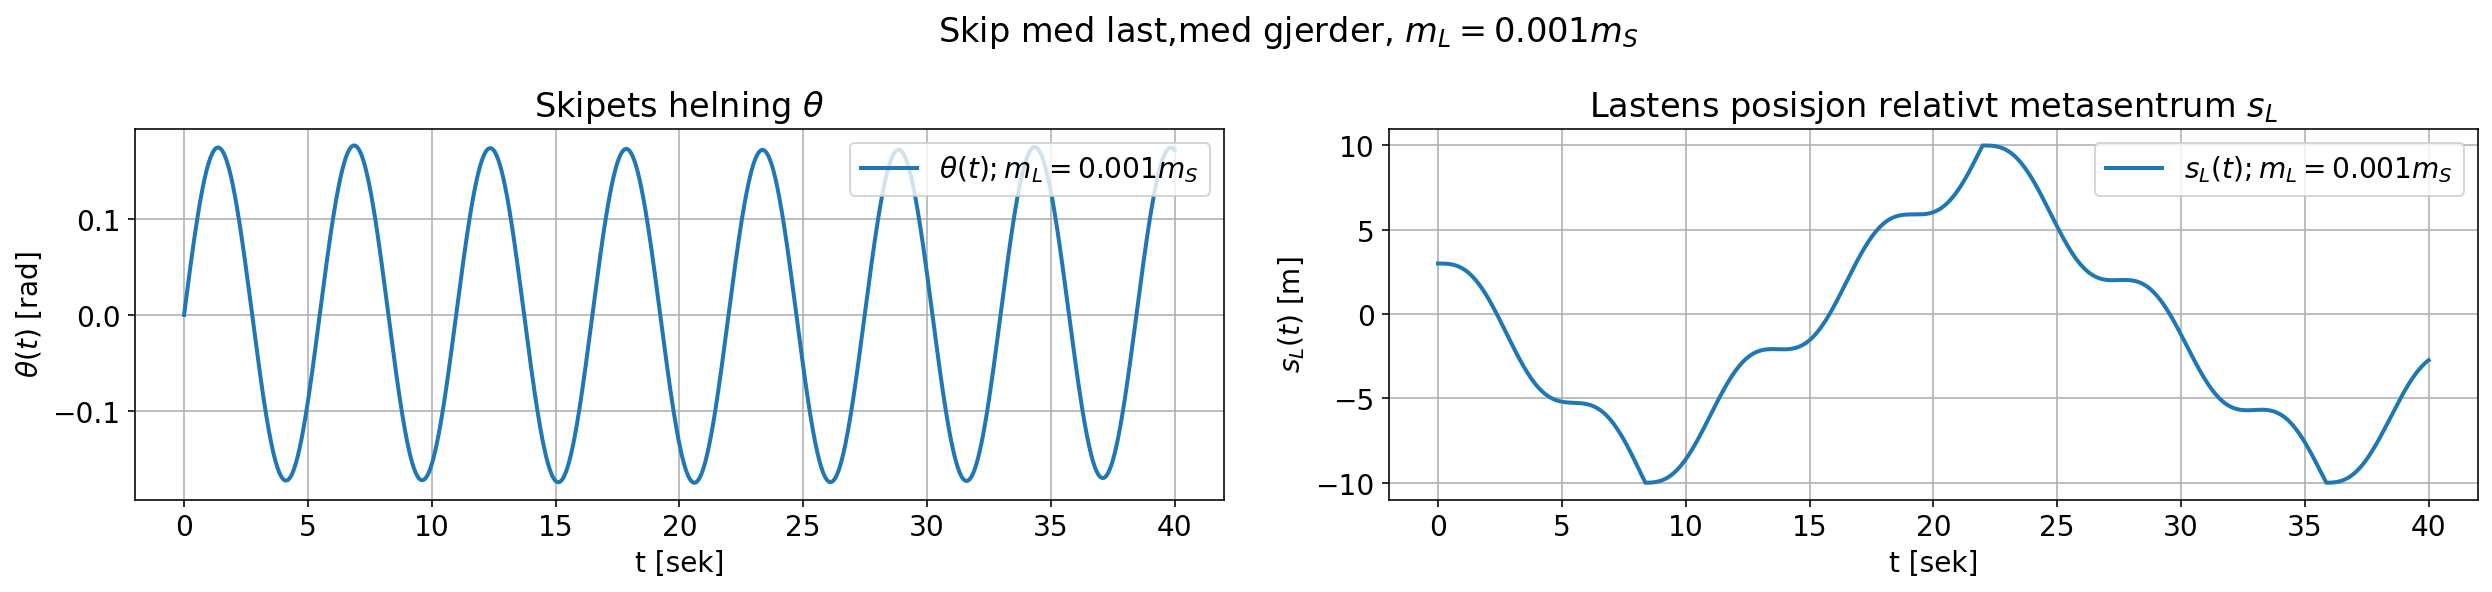

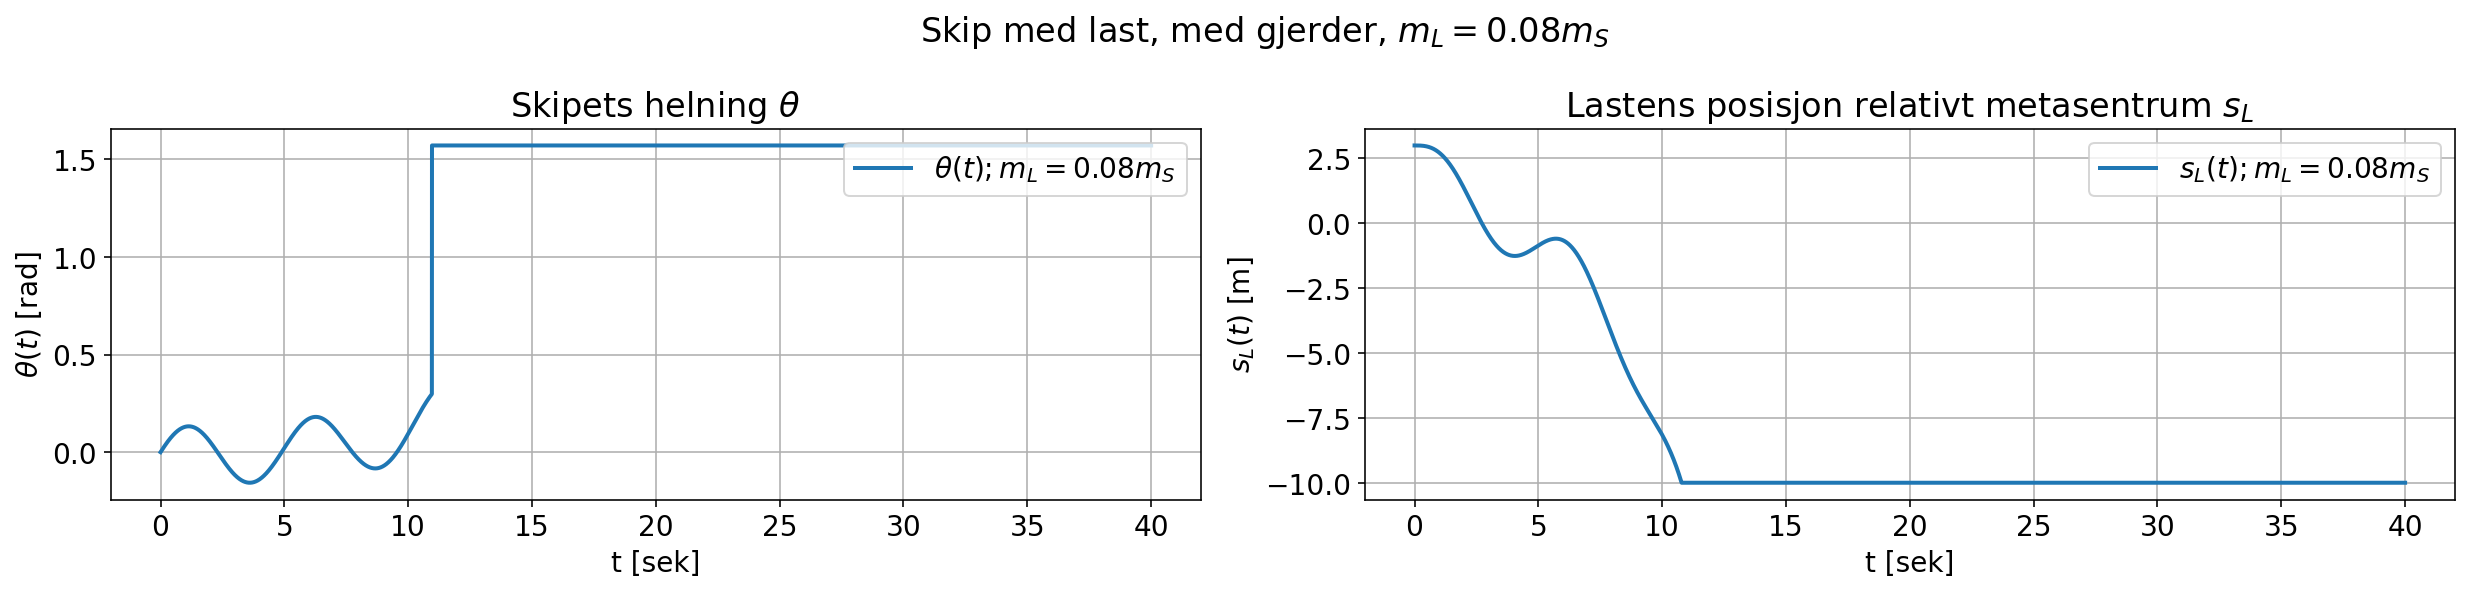

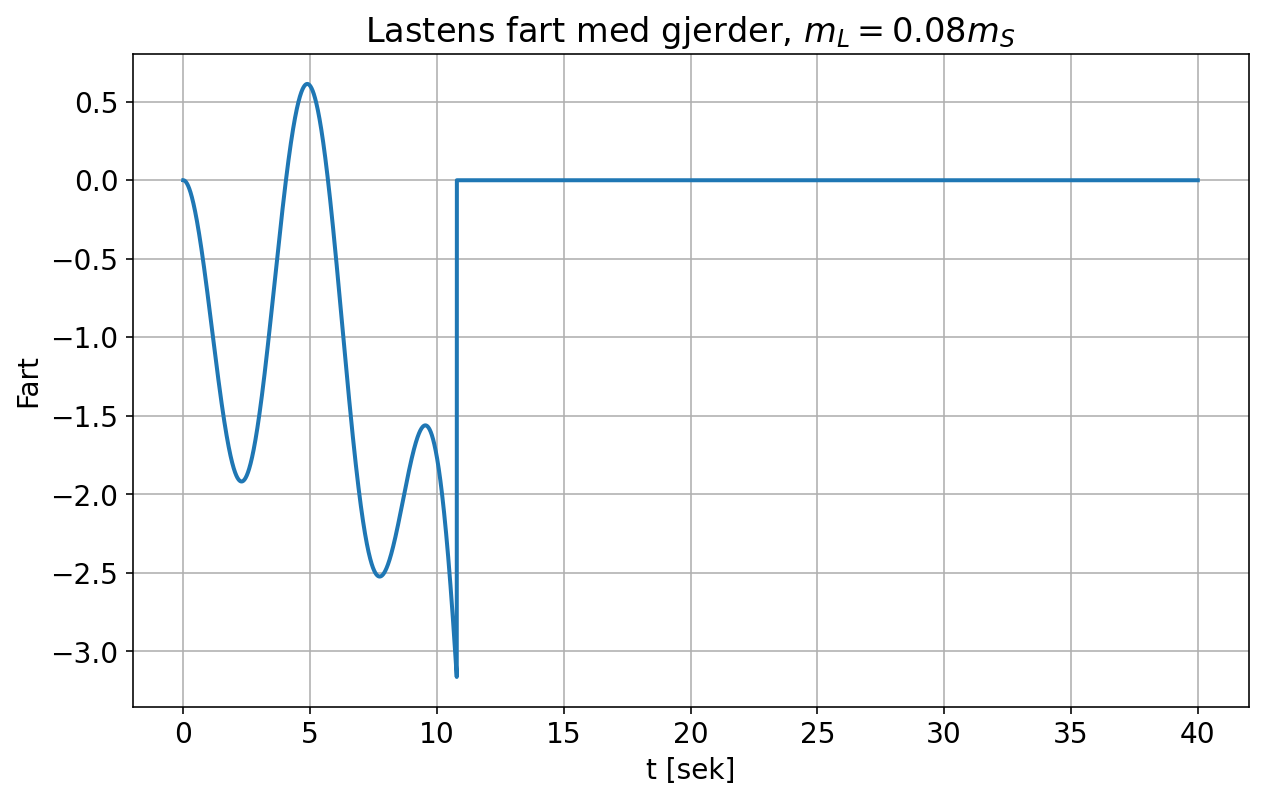

In [25]:
fig, axs = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle(rf"Skip med last,med gjerder, $m_L = {m_L0_2e[0]}m_S$", y=0.85)
fig.tight_layout(pad=3)

axs[0].plot(t1_2e, w1_2e[:, 0], label=rf"$\theta(t); m_L={m_L0_2e[0]}m_S$")
axs[0].set_title(r"Skipets helning $\theta$")
axs[0].set_xlabel("t [sek]")
axs[0].set_ylabel(r"$\theta(t)$ [rad]")
axs[0].legend(loc=1)

axs[1].plot(t1_2e, w1_2e[:, 6], label=rf"$s_L(t); m_L={m_L0_2e[0]}m_S$")
axs[1].set_title(r"Lastens posisjon relativt metasentrum $s_L$")
axs[1].set_xlabel("t [sek]")
axs[1].set_ylabel(r"$s_L(t)$ [m]")
axs[1].legend()

fig, axs = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle(rf"Skip med last, med gjerder, $m_L = {m_L0_2e[1]}m_S$", y=0.85)
fig.tight_layout(pad=3)

axs[0].plot(t2_2e, w2_2e[:, 0], label=rf"$\theta(t); m_L={m_L0_2e[1]}m_S$")
axs[0].set_title(r"Skipets helning $\theta$")
axs[0].set_xlabel("t [sek]")
axs[0].set_ylabel(r"$\theta(t)$ [rad]")
axs[0].legend(loc=1)

axs[1].plot(t2_2e, w2_2e[:, 6], label=rf"$s_L(t); m_L={m_L0_2e[1]}m_S$")
axs[1].set_title(r"Lastens posisjon relativt metasentrum $s_L$")
axs[1].set_xlabel("t [sek]")
axs[1].set_ylabel(r"$s_L(t)$ [m]")
axs[1].legend()

plt.figure()
plt.title(r'Lastens fart med gjerder, $m_L = 0.08m_S$')
plt.plot(t2_2e, w2_2e[:, 7],label = r"$v_L(t), \left[\frac{m}{s}\right]$")
plt.xlabel('t [sek]')
plt.ylabel('Fart')
plt.show()

Før lasten kolliderer med gjerdene er det ingen forskjell fra simuleringene uten gjerder, men etter kollisjonene er resultatene svært forskjellige. Siden den lettere lasten nærmest ikke påvirker skipets dynamikk, vil den holde seg med gjerdet frem til båten heller på en slik måte at lasten akselererer bort fra gjerdet. Deretter beveger den seg mot det andre gjerdet med en noe svingende bevegelse frem til den treffer det andre gjerdet og gjentar dette mønsteret.

Den tyngre lasten påvirker derimot skipet betydelig. I tillegg treffer lasten venstre gjerde omtrent samtidig som båten har et maksimalt utsving $\theta>0$. Disse faktorene resulterer i at skipet kantrer etter kort tid; ca. $11$ sekunder.

Lastens fart stemmer godt med lastens posisjonsplot, i det at den går til 0 idet lasten treffer gjerdet.

### Oppgave 2f

Vi inkluderer friksjonskraften mellom skroget og vannet som en horisontal kraft som virker i skipets dypeste punkt. For siste gang oppdaterer vi $\vec{w}$ til å ta hensyn til alle kreftene vi velger å inkludere. Vi vil se på seks stigende verdier for friksjonskonstanten som virker mellom skrog- og vann-overflaten. Dermed kjører vi et par simuleringer uten last.

Ved Newtons andre lov:

$$\frac{d}{dt}v_C^x=\frac{m_Lg\cos(\theta)-k_fR\gamma\omega+F_0\cos(\omega_wt)}{m}$$

$$\frac{d}{dt}v_C^y=\frac{A\sigma_0g-mg-m_Lg\cos^2(\theta)}{m}$$

$$\frac{d}{dt}\omega=\frac{-A\sigma_0gh\sin(\theta)-m_Lgs_L\cos(\theta)+F_0\cos(\omega_wt)y_C-k_fR\gamma\omega\left(y_C-\left( R\left(\cos\left(\frac{\gamma}{2}\right)-1\right)\right)\right)}{I_C}$$

In [35]:
def f_2f(t, w):
    """
    INPUT:
    t:      float, tidsverdien
    w:      numpy array, alle variablene til systemet
    ---
    ---
    OUTPUT:
    w_diff  numpy array, alle verdiene til den deriverte av w i tidspunktet t
    """
    gamma = 2*arccos(cos(beta/2)-4/(3*pi)*(1-cos(w[0]))+(w[3] - y_C0)/R)
    A = 1/2*R**2*(gamma-sin(gamma))
    return np.array([w[1],
                    (-A*sigma0*g*h_MC*sin(w[0])-m_L*g*w[6]*cos(w[0])+F_0*cos(omega_w*t)*w[3]-k_f*R*gamma*w[1]*(w[3]-(R*(cos(gamma/2)-1))))/I_C,
                    w[4],
                    w[5],
                    (m_L*g*cos(w[0])*sin(w[0])-k_f*R*gamma*w[1]+F_0*cos(omega_w*t))/m,
                    (A*sigma0*g-m*g-m_L*g*cos(w[0])**2)/m,
                    w[7],
                    -g*sin(w[0])])

In [36]:
t_lim_2f = [0, 20]

theta0_2f, omega0_2f, k_f_2f = 0, 0.4, [0, 10, 1000, 5000, 10000, 30000]
w0_2f = w_vec(theta0_2f, omega0_2f)

t_list_2f, w_list_2f = [], []

for k in k_f_2f:
    t_2f, w_2f = main(f_2f, w0_2f, t_lim_2f, fric = k)
    
    t_list_2f.append(t_2f)
    w_list_2f.append(w_2f)

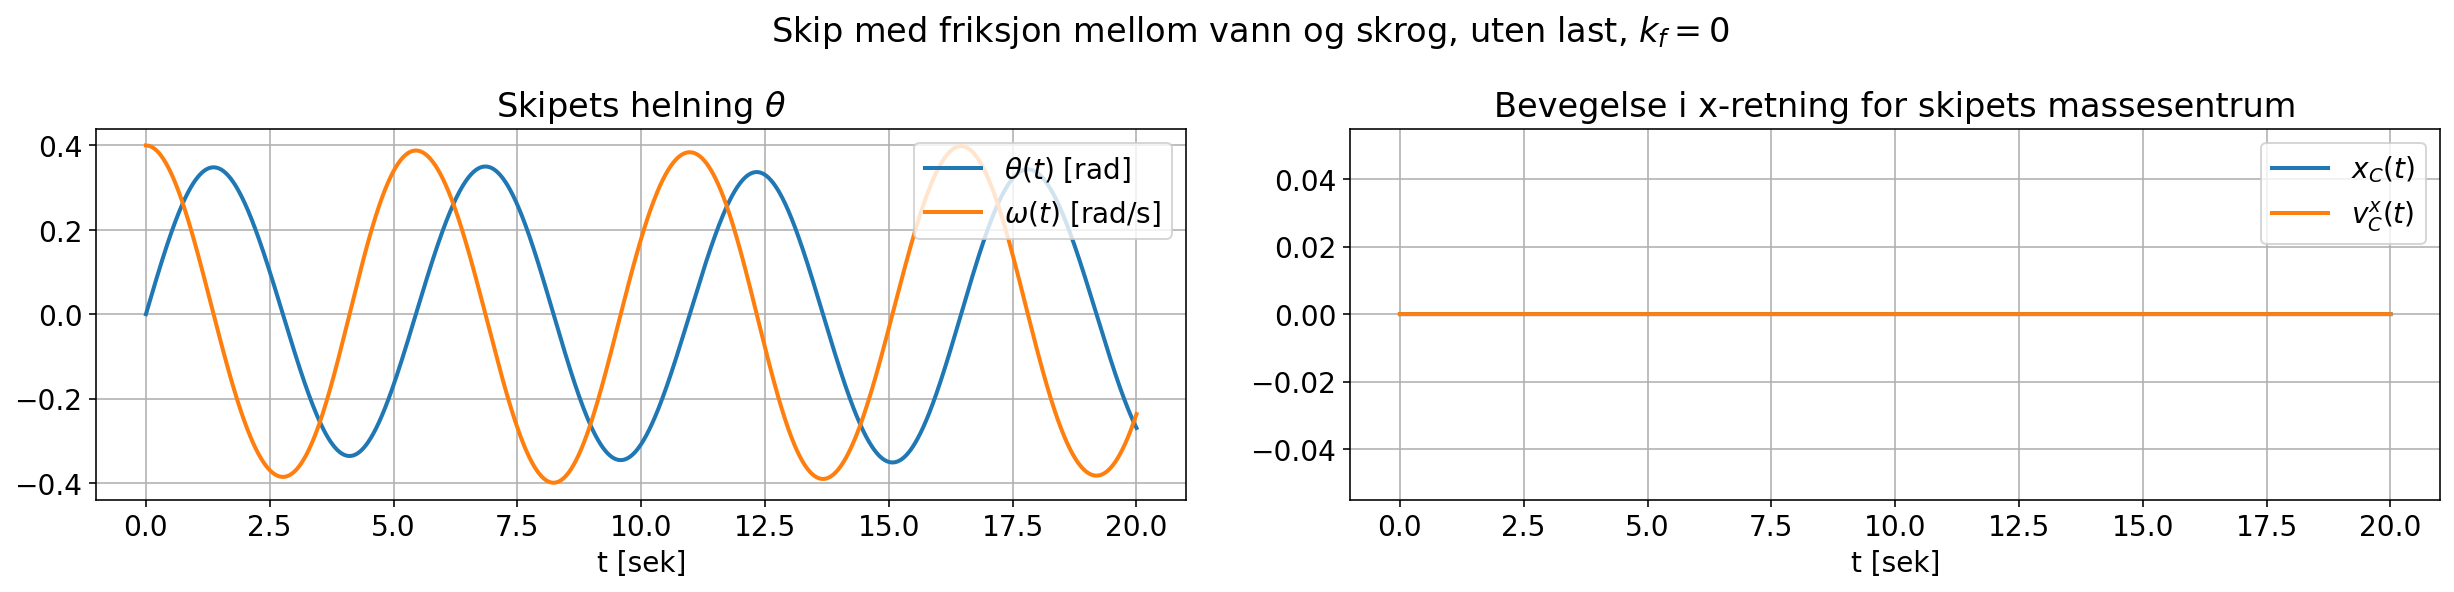

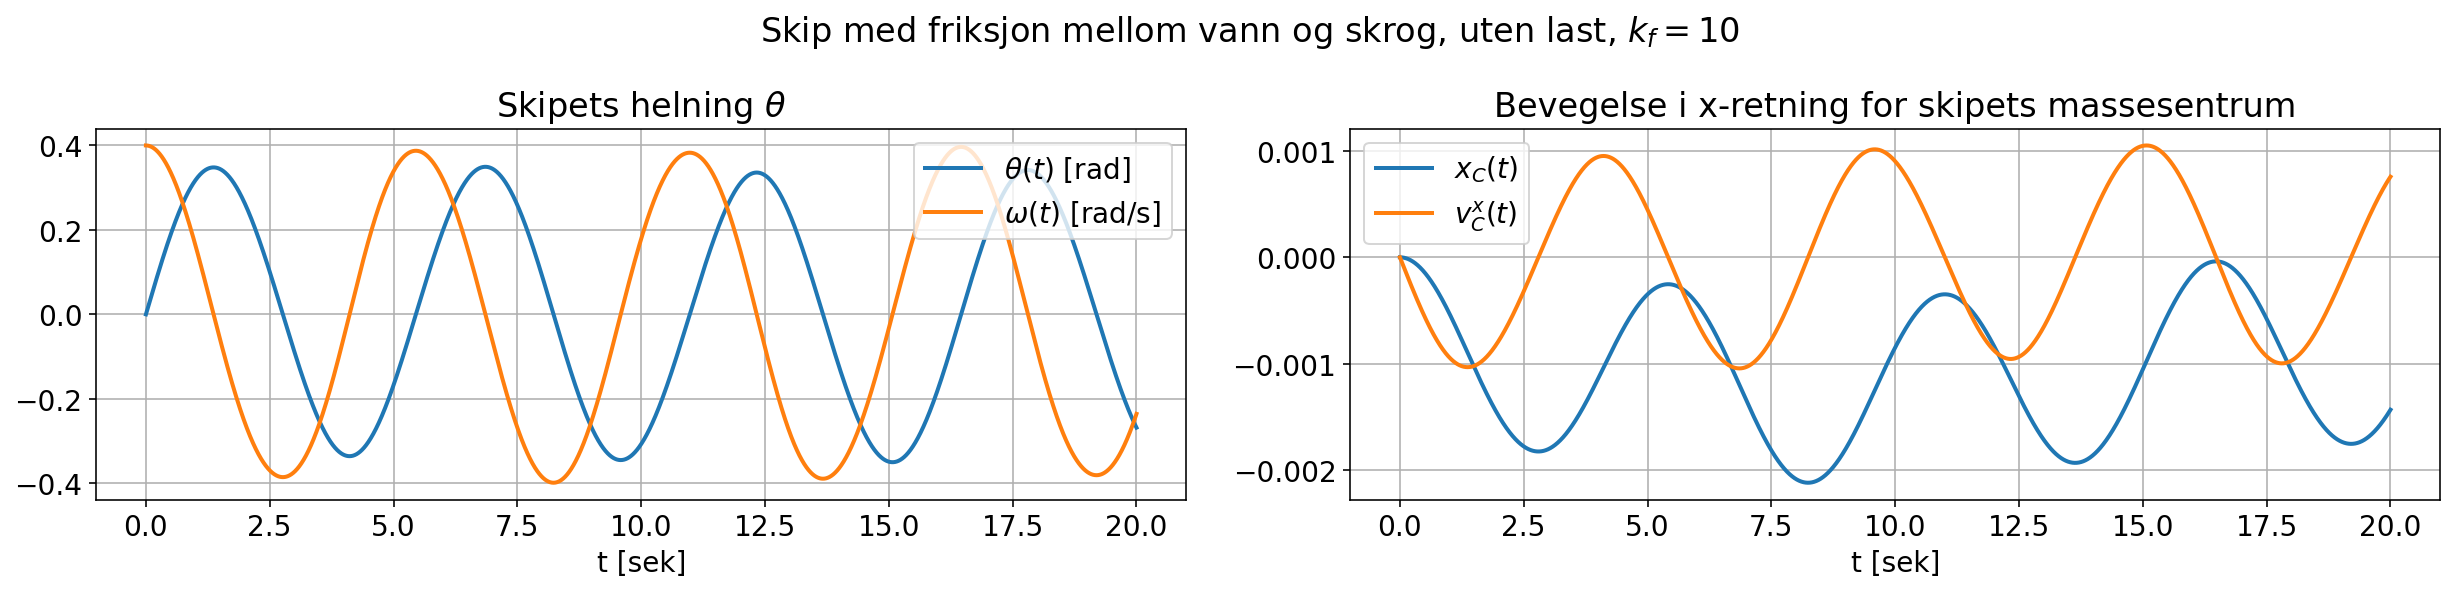

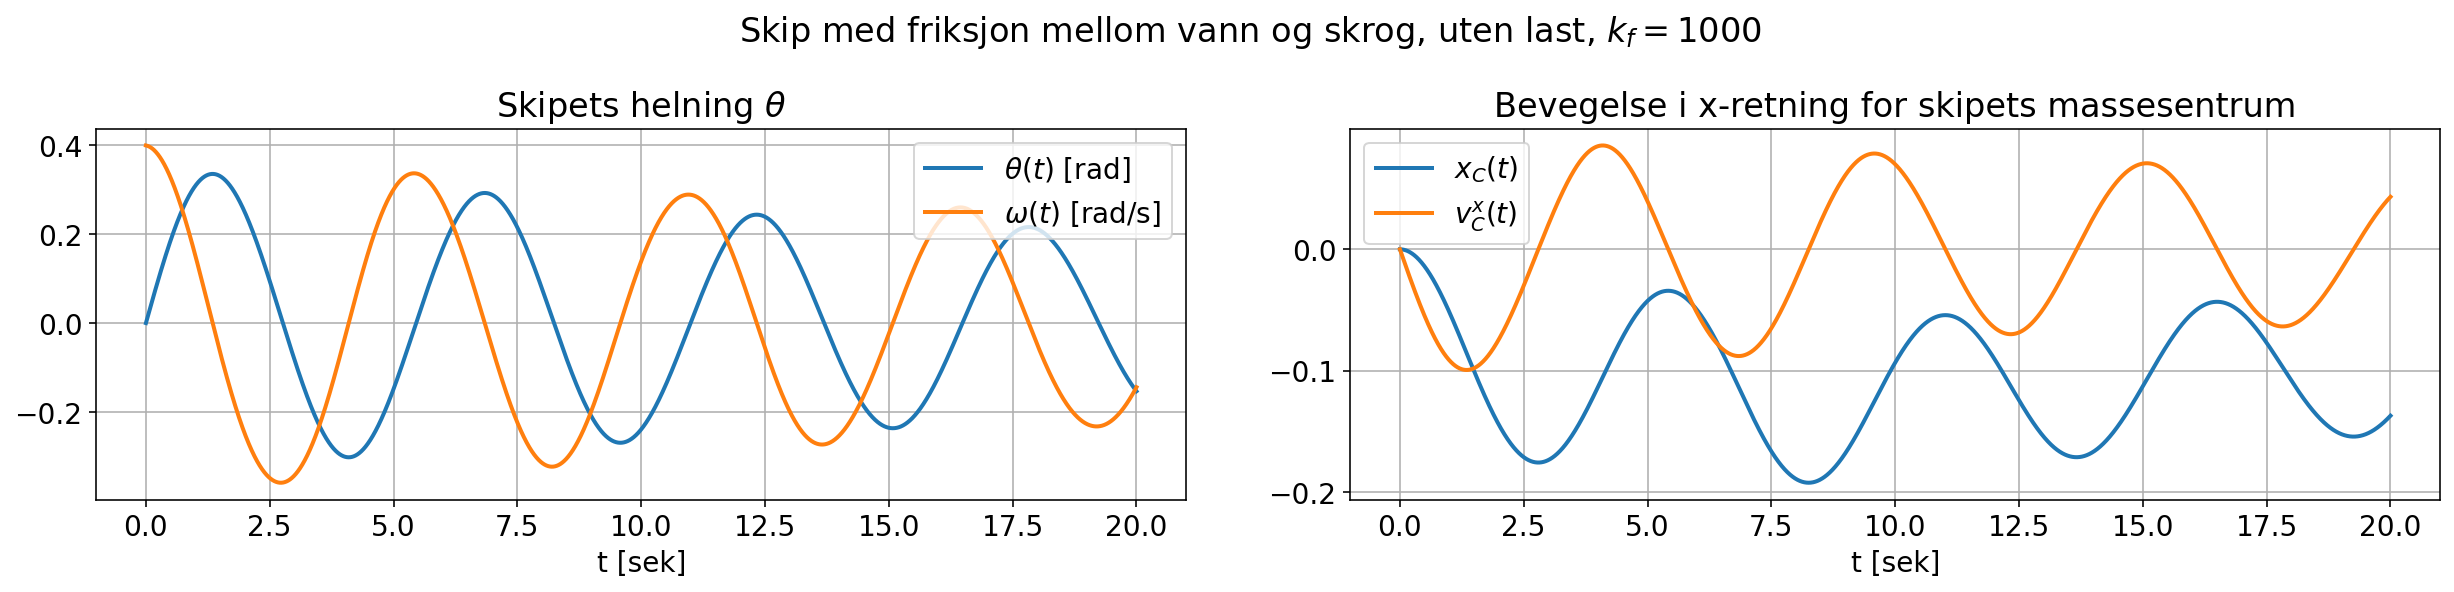

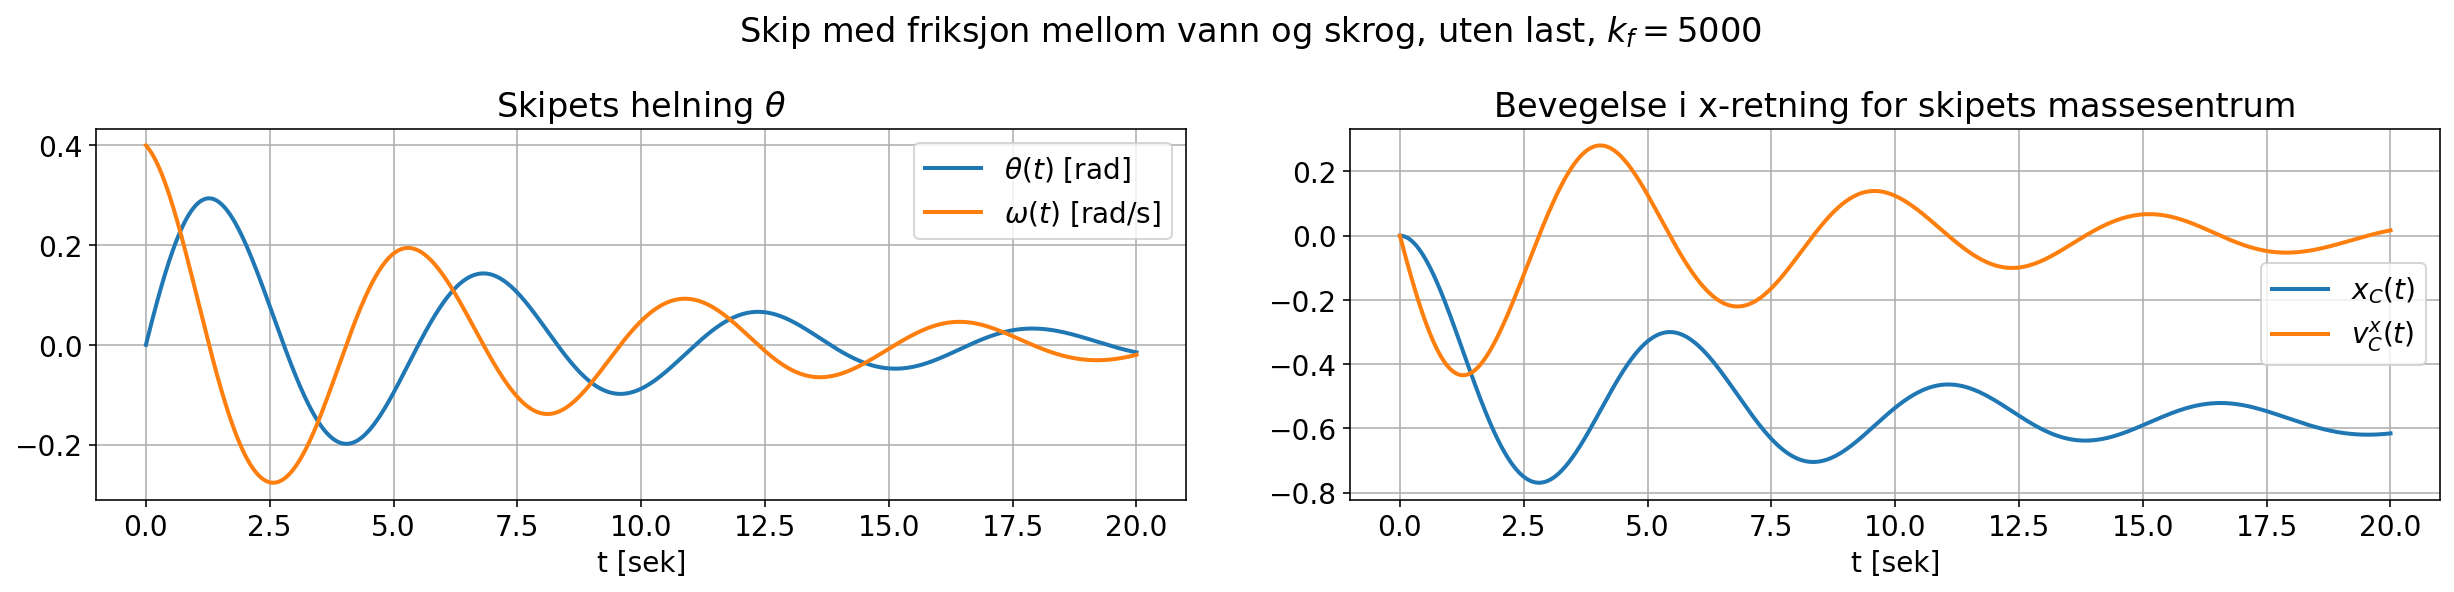

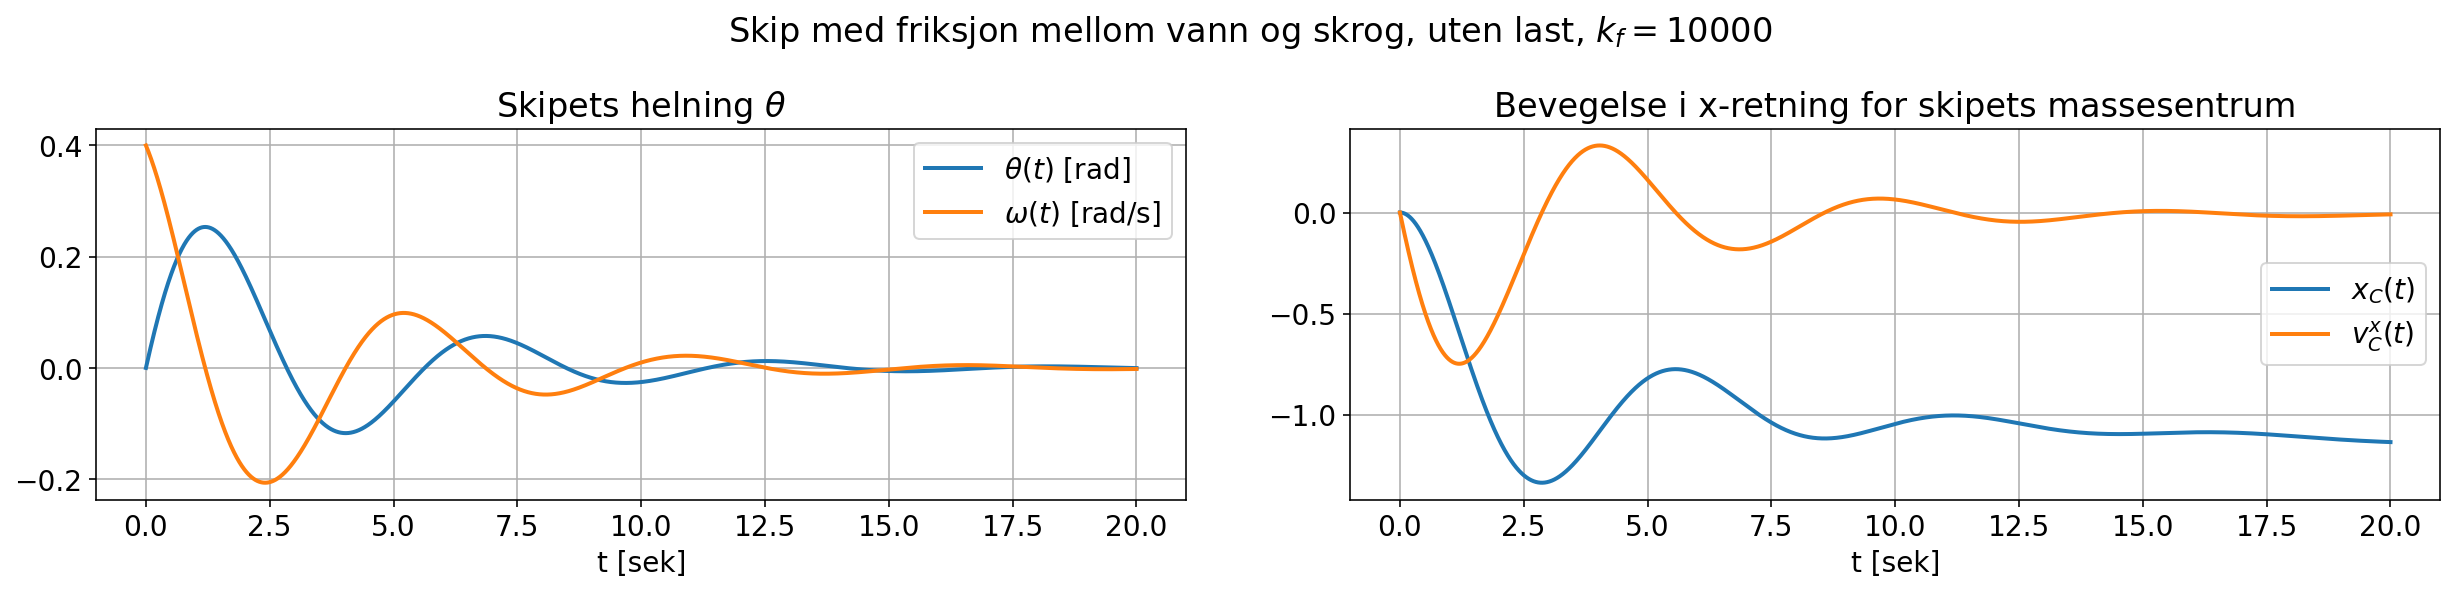

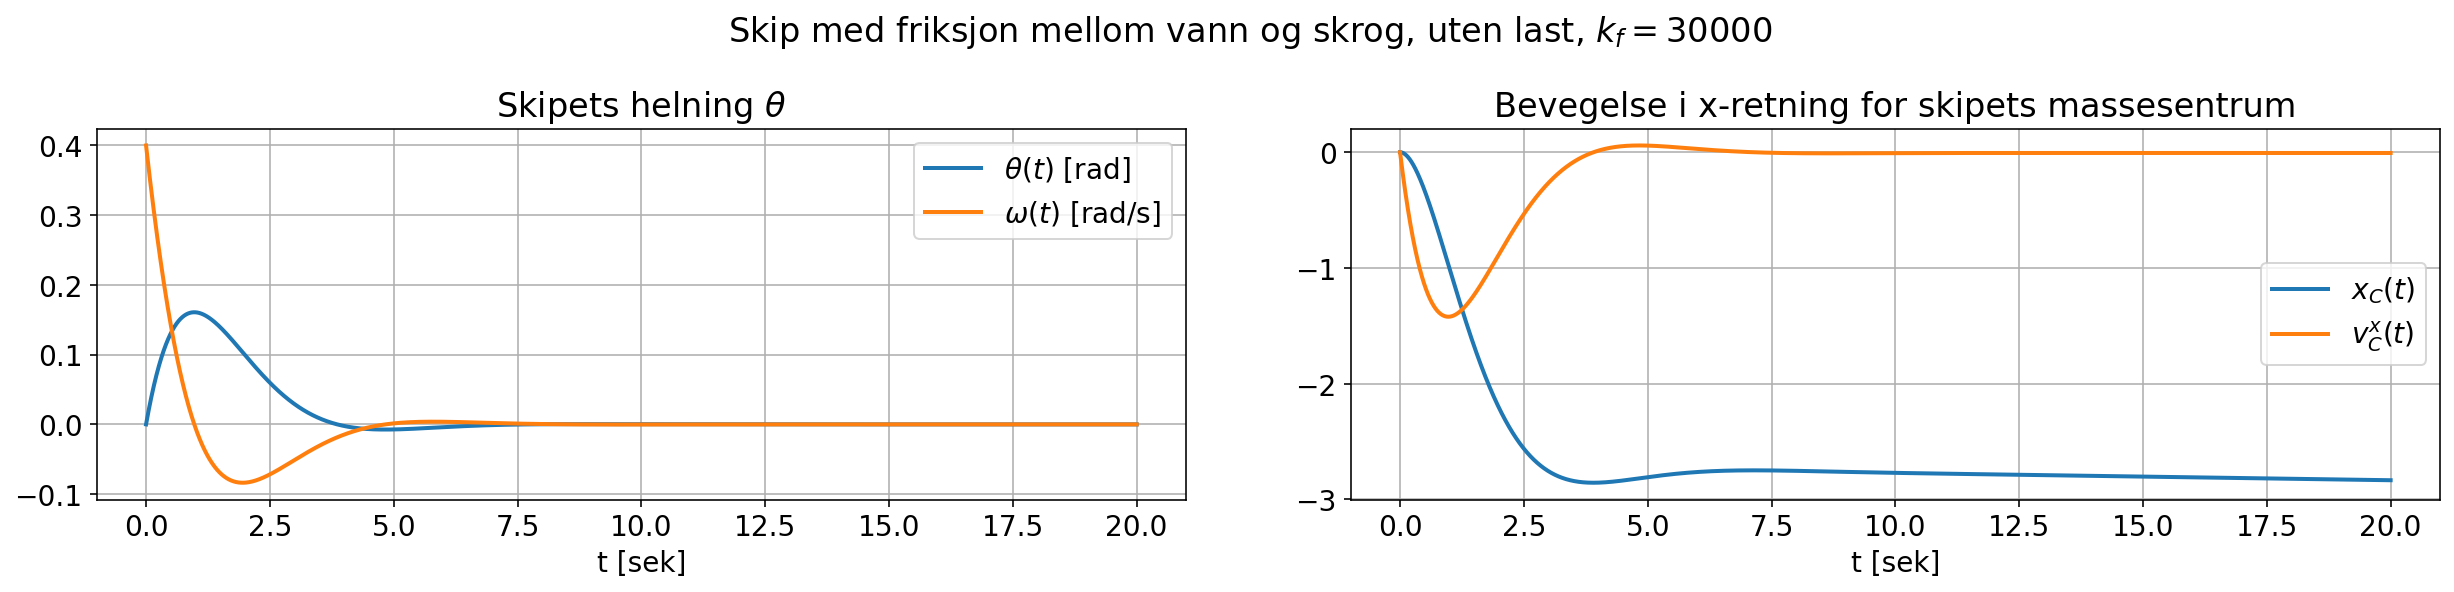

In [37]:
for n, val in enumerate(w_list_2f):
    fig, axs = plt.subplots(1,2, figsize=(18, 5))
    fig.suptitle(rf"Skip med friksjon mellom vann og skrog, uten last, $k_f = {k_f_2f[n]}$", y=0.85)
    fig.tight_layout(pad=3)

    axs[0].plot(t_list_2f[n], val[:, 0:2], label=rf"$\theta(t)$")
    axs[0].set_title(r"Skipets helning $\theta$")
    axs[0].set_xlabel("t [sek]")
    axs[0].legend([r"$\theta(t)$ [rad]", r"$\omega(t)$ [rad/s]"], loc=1)

    axs[1].plot(t_list_2f[n], val[:, 2:5:2])
    axs[1].set_title(r"Bevegelse i x-retning for skipets massesentrum")
    axs[1].set_xlabel("t [sek]")
    axs[1].legend([r"$x_C(t)$", r"$v_C^x(t)$"])

Her får vi se hvordan skipet svingning varierer med økende friksjonskoeffisient. Radene viser vinkelutslag og vinkelhastighet til venstre, og massesenterets forflytning og hastighet i $x$-retning til høyre. Nedover øker koeffisienten, og man ser tydelig at det har stor innvirkning på svingningene. Gradvis dempes vinkelutslaget helt til det såvidt dupper under likevektspunkntet - nesten kritisk demping. I motsatt ende, med koeffisienten lik $0$, kan man se at utslaget nesten ikke blir påvirket, og at massesenteret heller ikke forflytter seg horisontalt. For gradvis større friksjon ser man at alle grafene flater ut over tid. Grunnen til at skipet slår seg til ro ved en viss $x$-verdi kommer av at hastigheten i $x$-retning går mot $0$. Svingningene dempes altså slik at all kinetisk og potensiell energi i båten til slutt er gått over til varmeenergi fra friksjonen.

Ved å se på simuleringene for $k_f=10$ og $k_f=1000$ kan det virke som at posisjon og fart i $x$-retning varierer. Dette er ikke rart for posisjonen da båten vil komme til ro et sted borte fra $x_C=0$. Likevektspunktet for $x_C$ varierer derimot bort fra og mot $x_C=0$. Dette er uforventet siden man ville forventet at farten i $x$-retning ville svinge med en eksponensielt minkende amplitude, slik at akselerasjonen i negativ $x$-retning aldri ville overskride akselerasjon i positiv $x$-retning. Man observerer derimot fra disse to grafene at farten i $x$-retning også svinger om et varierende likevektspunkt. Dette fenomenet forklares mest sannsynlig også ved at skipets vertikale bevegelse påvirker skipets dynamikk i $x$-retning, noe som gir mening siden friksjonskraften mellom skroget og vannet varierer med overflateareal av skroget som er under vann. Dette avhenger av hvor mye av skipet som er under vann, noe som varierer med $y_C$. Dette fenomenet er nok bare tydelig for disse lave friksjonskoeffisientverdiene fordi svingningene dempes sakte nok til at en variasjon i likevektspunkt er synlig ved å se på toppene av grafen. Ved store friksjonskoeffisienter minker amplituden så fort at en liten endring i likevektspunkt ikke synes. Det er derimot tydelig fra grafen for $k_f=1000$ at amplituden uansett minker, altså vil nok massesenterets svingninger horisontalt konvergere.

## Oppgave 2g

Nå ønsker vi å se på hva som ville skjedd dersom vi sendte et skip på åpent hav istedenfor innerst i havna der det ikke er rufsete vind og bølger. Vi simulerer vær- og bølge-bidraget som en harmonisk oscillerende kraft som bidrar i vannhøyden. Vi ser på vinkelutslaget over $4$ minutter med disse parameterne:

- $k_f = 100$ kg/s

- $F_0 = 0.625mg$

- $\omega_w = 0.93\omega_0$

In [38]:
t_lim_2g = [0, 240]

parameter()

theta0_2g, omega0_2g, k_f_2g, F_0_2g, omega_w_2g = 0, np.radians(2), 100, 0.625*m*g, 0.93*sqrt(m*g*h_MC/I_C)
w0_2g = w_vec(theta0_2g, omega0_2g)


t_2g, w_2g = main(f_2f, w0_2g, t_lim_2g, fric = k_f_2g, W = F_0_2g, freq_w = omega_w_2g)

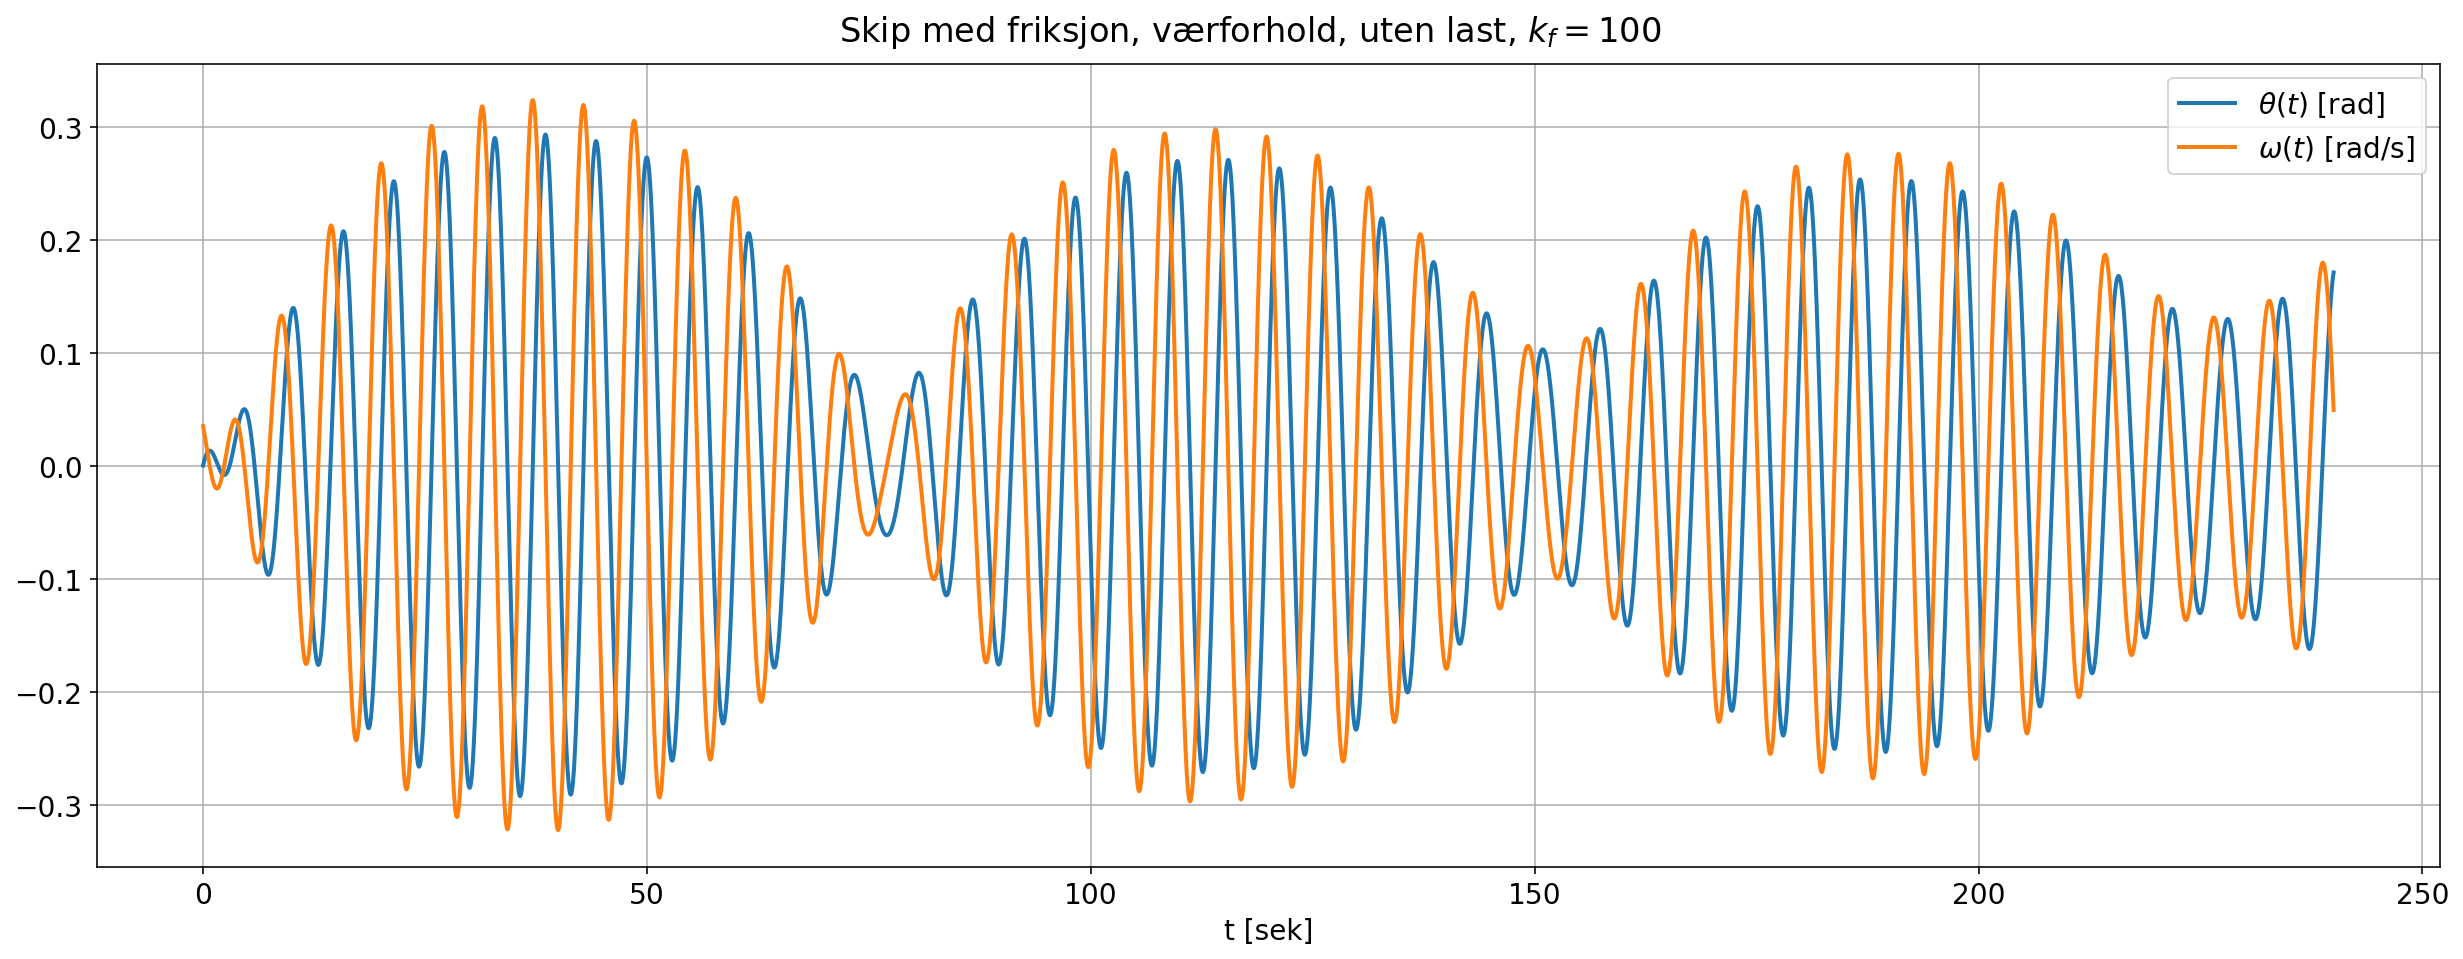

In [39]:
fig, axs = plt.subplots(1,1, figsize=(18, 8))
fig.suptitle(rf"Skip med friksjon, værforhold, uten last, $k_f = {k_f_2g}$", y=0.85)
fig.tight_layout(pad=3)

axs.plot(t_2g, w_2g[:, 0:2])
axs.set_xlabel("t [sek]")
axs.legend([r"$\theta(t)$ [rad]", r"$\omega(t)$ [rad/s]"], loc=1)

Grafen overfor viser tre opphopninger av bølger. Den første har et tydelig skille fra den neste, men deretter ser det ut til at dette skillet blir mer og mer utydelig. I tillegg ser man også at opphopningenes amplitude gradvis synker. Her ser man et tydelig bilde på fenomenet som kalles svevning. Dette er når bølgene selv har egne bølger. Ikke bare ser man av bølgene selv har en periodisk svingning, men de er del av en større bølge som også svinger periodisk. Slik som her kan dette oppstå når to oscillerende krefter virker på et legeme i forskjellig "tempo". Da hender det at de virker med hverandre i det ene øyeblikket, mens mot hverandre i det neste, konstruktiv og destruktiv interferens. Resultatet blir en bevegelse som varierer periodisk. Som vi så tidligere, kommer dempingen fra friksjonskraften som jobber mot bevegelsen og sørger for å kvele utsvinget.

I denne simuleringen ser man tydelig sveving, men at skillene mellom hver bølge for svevingen blir gradvis mindre tydelige. Vi har snakket om sveving i kontekst av to svingninger med forskjellige naturlige moder som danner sveving. I dette tilfellet vil de forskjellige svingningene som er til stede være rotasjon, translasjon og ytre krefter. Siden dynamikken til skipet ikke avhenger av massesenterets $x$-posisjon, vil periodisk bevegelse av massesentrum vertikalt være det translatoriske bidraget til svevingen. Man observerer at skipets vinkelhastighet blir betraktelig større enn dets initiale vinkelhastighet, noe som kommer av de ytre kreftene på skipet. Amplituden varierer derimot periodisk grunnet svevingen forårsaket av skipets og de ytre kreftenes forskjellige moder som interfererer. For å forklare hvorfor skillet mellom bølgene forårsaket av svevingen blir mindre tydelige, kan man se for seg av svevingens bølgelengde interfererer med den siste periodiske bevegelsen, translasjon, og danner sveving mellom seg. Dette ville bety at skillene vi har snakket om til slutt ville blitt tydelige igjen, og fortsatt slik periodisk. Simuleringen måtte derimot vært svært mye lengre for å observere noe slikt.

## Oppgave 2h

Vi skal nå teste en annen adaptiv numerisk metode, Bogacki-Shampine, med orden (2,3). Dette er et metodepar i Runge-Kuttafamilien der den 3. ordens metoden sjekker den 2. ordens metodes utregning og dermed godtar eller avslår steget på bakgrunn av forskjellen mellom de to. Uavhengig av utfall bestemmes så neste steglengde vha feilapproksimasjonen i dette steget. Vi kan derfor kontrollere den lokale feilen. Den globale feilen er det ikke mulig å kontrollere, men da vi kan kontrollere den lokale, og vet at den globale er proporsjonal med den lokale, kan vi indirekte påvirke den globale feilen.

Vi har to frie parametere i denne metoden, feiltoleransen og den såkalte "pessimistfaktoren", en konstant som bestemmer størrelsen på steglengden etter utregning. (Dermed kan man, om man ser for seg at feilen blir stor, sette pessimistfaktoren til en liten verdi.)

Bogacki-Shampine er i prinsippet en 2. ordens metode, da det er den 2. ordens metoden som regner det neste steg og den 3. ordens metoden kun brukes for å sjekke feilen. På grunn av dette vil det kreve en mye mindre steglengde for å oppnå samme presisjon som f.eks. med en fjerde ordens metode. Dette har vi allerede diskutert i oppgave 1h.

Bogacki-Shampine er en av flere metoder som kan utnytte den såkalte First Same As Last, eller FSAL-egenskapen. Dette er en egenskap der den fjerde utregningen i den daværende iterasjonen, `k4`, er den neste iterasjonens første utregning, `k1`. Dette betyr at, om du regner ut én `k1` for startpunktet trenger du kun å regne ut `k2`, `k3` og `k4` for de neste iterasjonene, bare tre av fire. Dette er flott for effektiviseringen av koden!

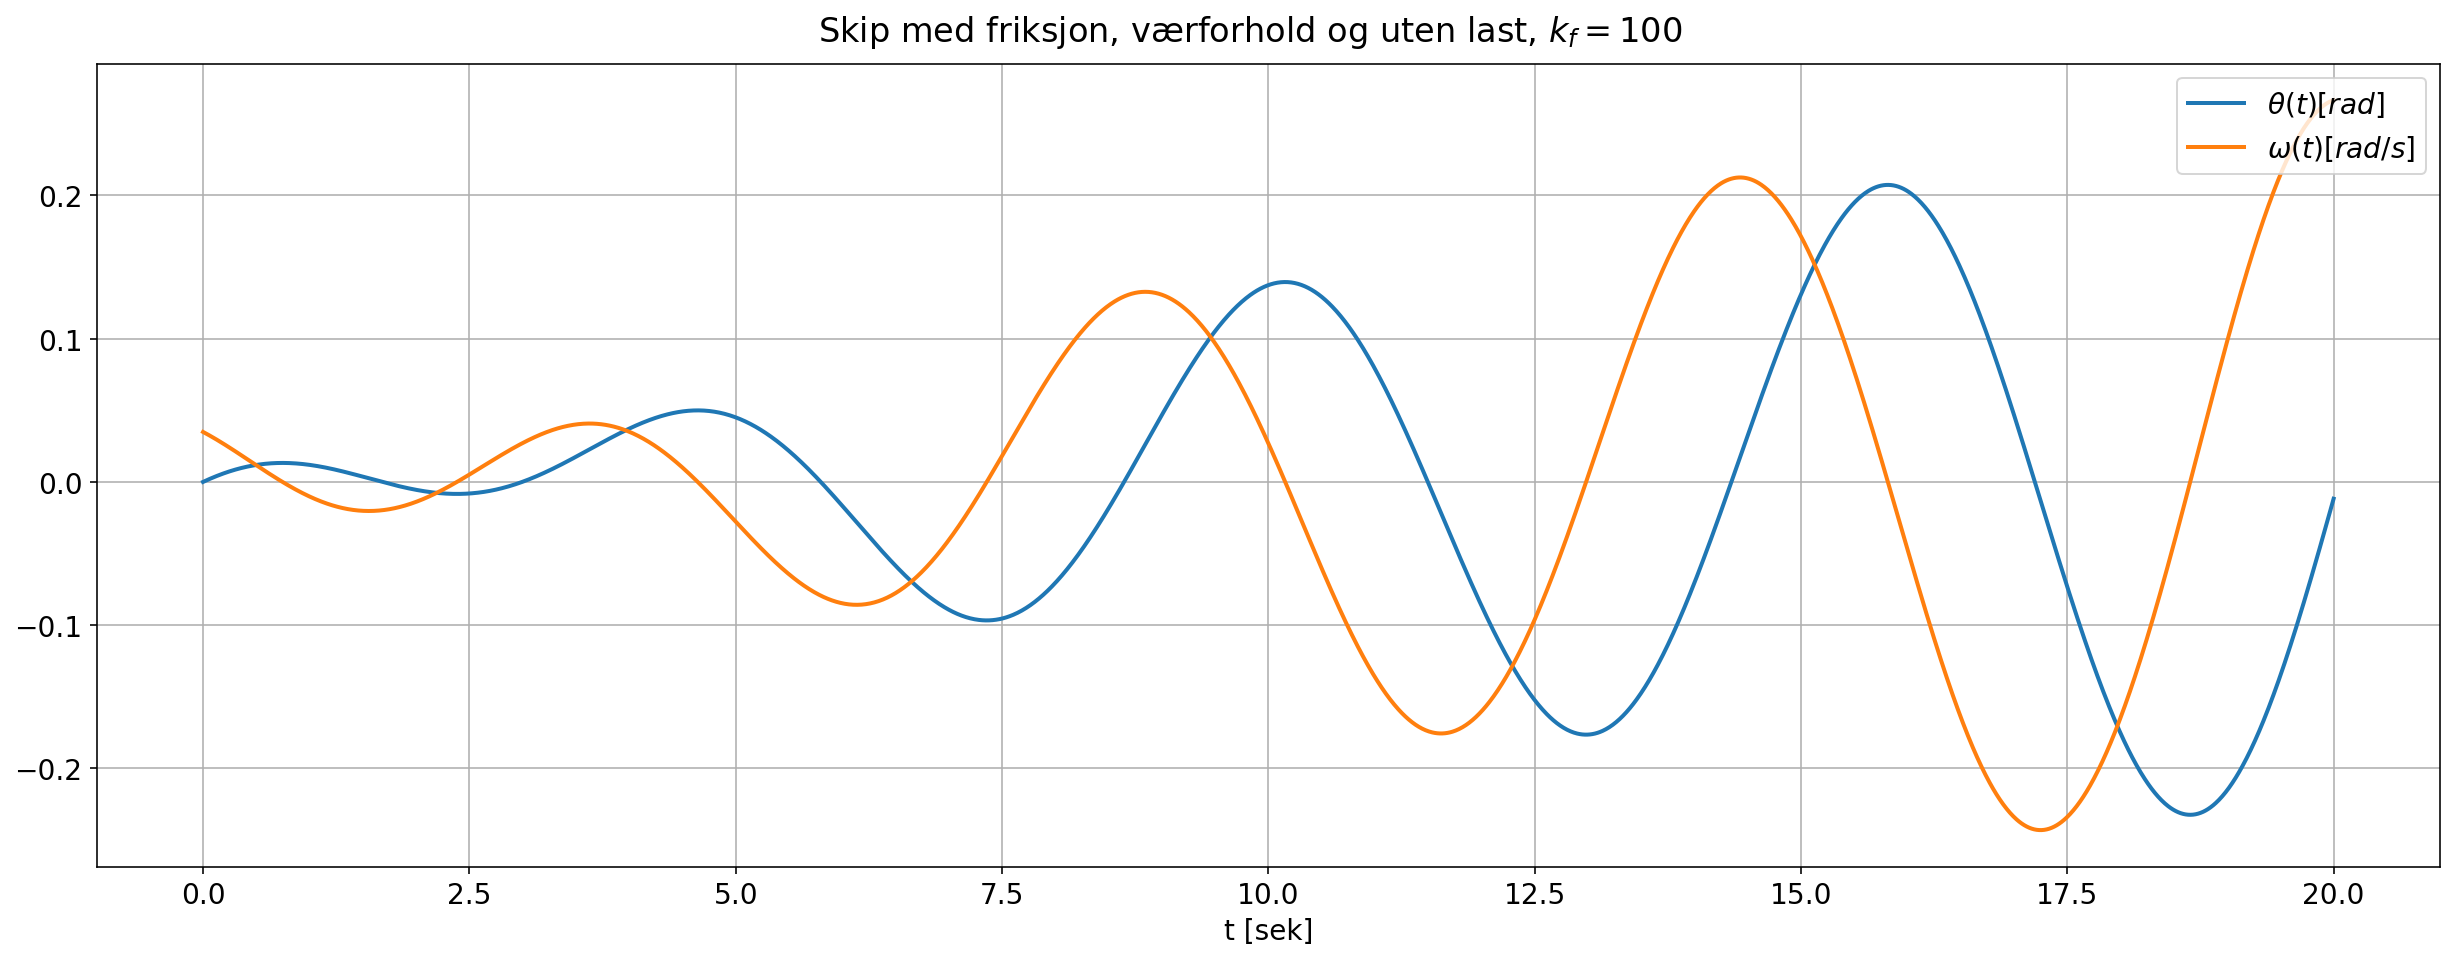

In [40]:
t_lim_2g = [0, 20]

parameter()

theta0_2g, omega0_2g, k_f_2g, F_0_2g, omega_w_2g = 0, np.radians(2), 100, 0.625*m*g, 0.93*sqrt(m*g*h_MC/I_C)
w0_2g = w_vec(theta0_2g, omega0_2g)

t_2g, w_2g = main(f_2f, w0_2g, t_lim_2g, fric = k_f_2g, W = F_0_2g, freq_w = omega_w_2g, method = bogshamp)

fig, axs = plt.subplots(1,1, figsize=(18, 8))
fig.suptitle(rf"Skip med friksjon, værforhold og uten last, $k_f = {k_f_2g}$", y=0.85)
fig.tight_layout(pad=3)

axs.plot(t_2g, w_2g[:, 0:2])
axs.set_xlabel("t [sek]")
axs.legend([r"$\theta(t) [rad]$", r"$\omega(t) [rad/s]$"], loc=1)

Dette gir forventede resultater, men med en toleranse på $10^{-7}$ er det klart at Bogacki-Shampine, som i bunn og grunn er en 2. ordens metode, bruker lenger tid enn RK4, både fordi den må bruke små steglengder, men også fordi den tester for feil flere ganger før et steg går gjennom. Men i motsetning til RK4 har vi nå en måte å implisitt kontrollere feilen!

For å se på hvor mye mindre steglengdene må være for samme presisjon med RK4 og Bogacki-Shampine (B-S) kan vi gjøre som i oppgave 1h:
Vi vet at $||e_n|| \leq Ch^p$, og hvis vi her også for eksempelets skyld antar at $C_{B-S} = C_{RK4} = 1$ kan vi se på steglengden som å til for at vi får en feil på maks $10^{-8}$:
$$
h_{RK4}^4 = 10^{-8} = h_{B-S}^2
$$
$$
h_{B-S} = 10^{-4}, h_{RK4} = 10^{-2}
$$


Fra oppgave 2g ser man at utslaget for $\theta$ blir betydelig mye større enn det man ville forventet om ingen ytre krefter virket på skipet. Det blir da naturlig å spørre hva som skal til for at skipet kantrer selv om startbetingelsene ikke tilsier at det skal gjøre det.

Vi så tidligere at last på dekk kan ha mye å si for om skipet kantrer eller ikke, og det vil være naturlig at skipet kantrer om skipet utsettes for ytre krefter med umenneskelig kraft, altså at $F_0$ er gigantisk. Skipet vil derimot i teorien kunne kantre ved mindre $F_0$ ved at skipet og de ytre periodiske kreftene faller produserer en kraftig konstruktiv interferens. Vi ønsker dermed å se på hvor stor kraft som kreves for å kantre skipet om kraften tilføres periodisk med samme vinkelfrekvens som skipets naturlige vinkelfrekvens:

$$\omega_0=\sqrt{\frac{mgh}{I_C}}$$

In [41]:
t_lim_2h = [0, 70]
theta0_2h, omega0_2h, k_f_2h, F_0_2h, omega_w_2h = 0, np.radians(2), 100, m*g, sqrt(m*g*h_MC/I_C)
w0_2h = w_vec(theta0_2h, omega0_2h)

t1_2h, w1_2h = main(f_2f, w0_2h, t_lim_2h, fric = k_f_2h, W = F_0_2h, freq_w = omega_w_2h, method = bogshamp)
t2_2h, w2_2h = main(f_2f, w0_2h, t_lim_2h, fric = k_f_2h, W = F_0_2h, freq_w = omega_w_2h, method = RK4)

Antall elementer i RK4: 70002
Antall elementer i Bogacki-Shampine: 124600


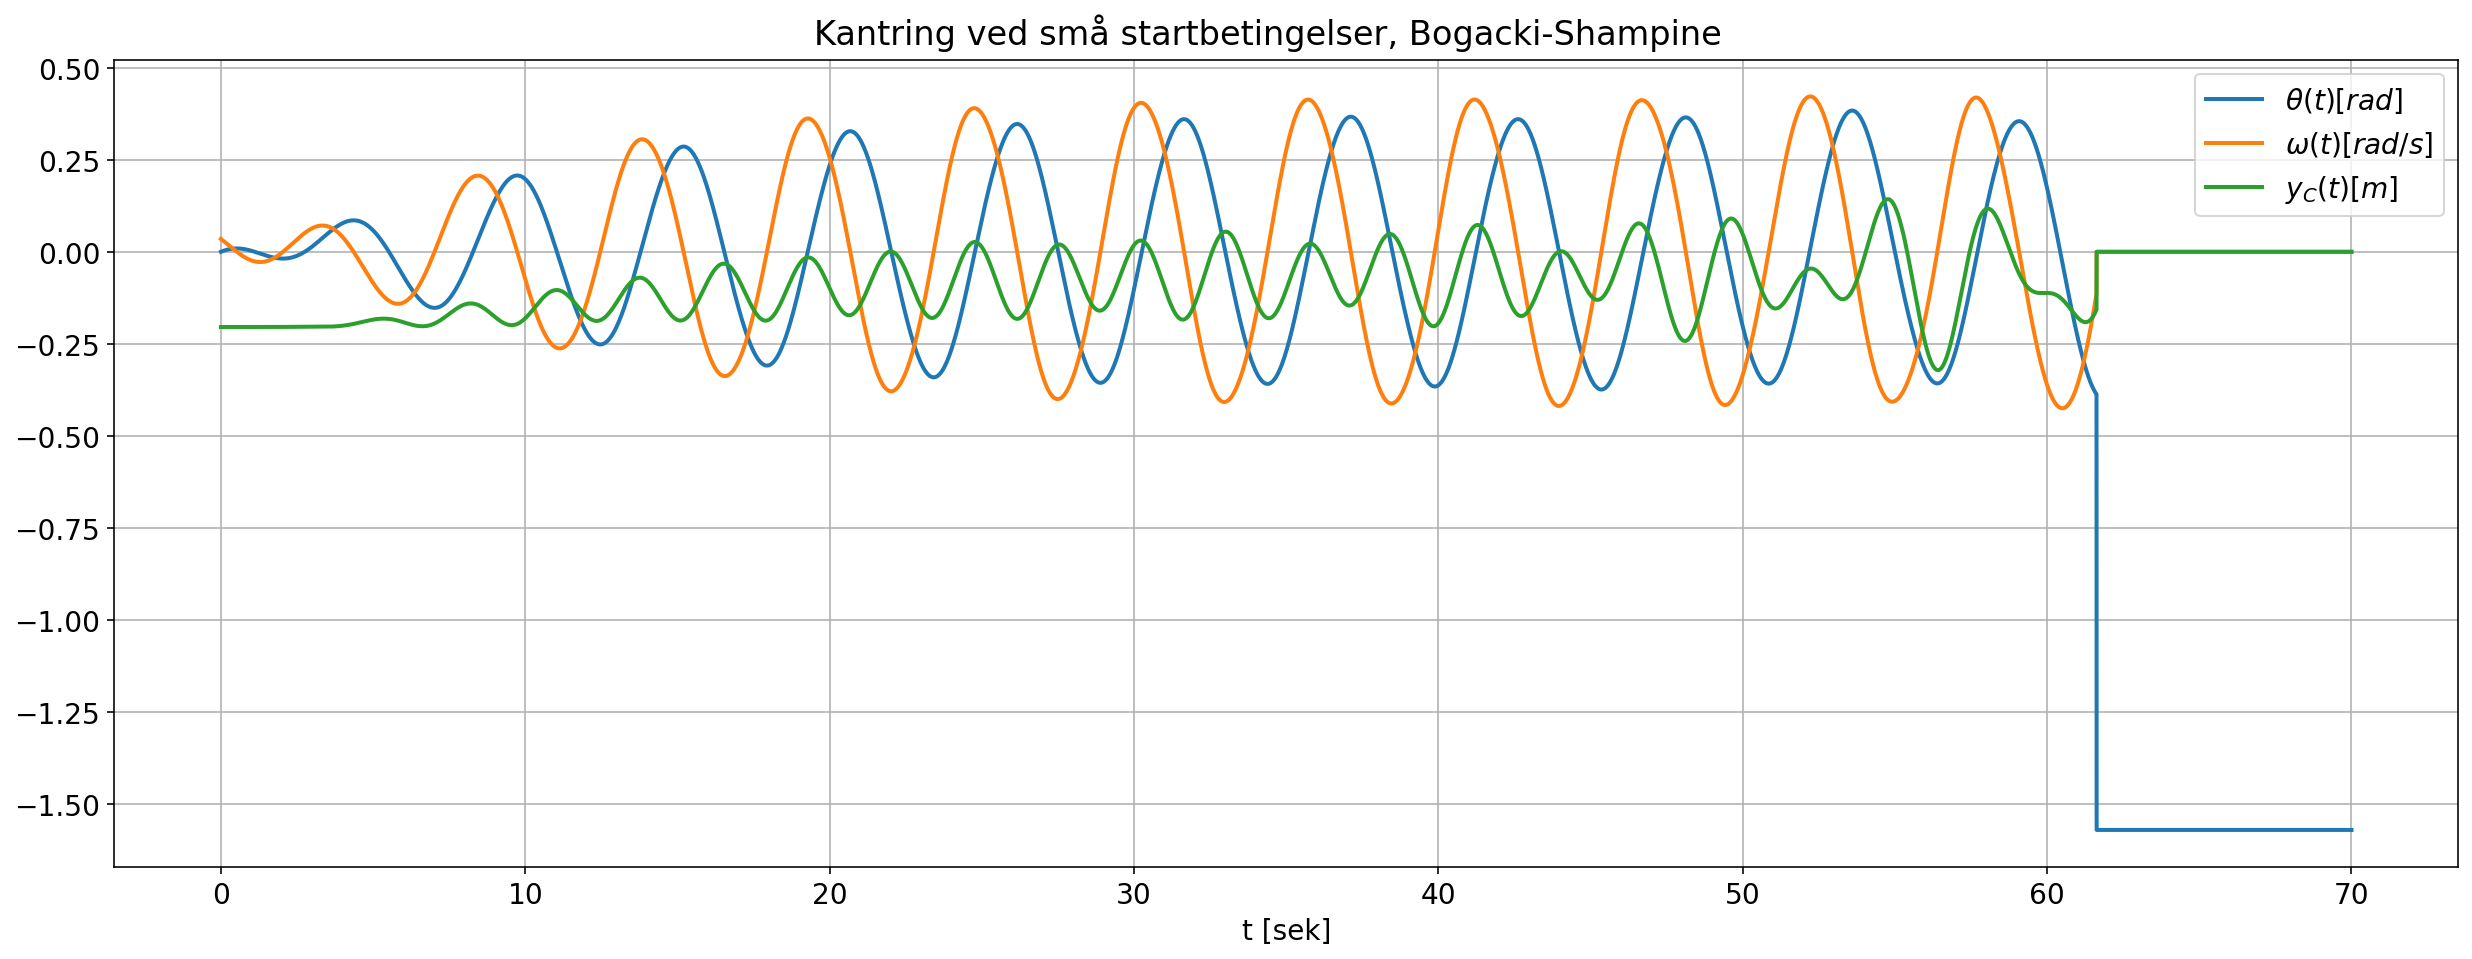

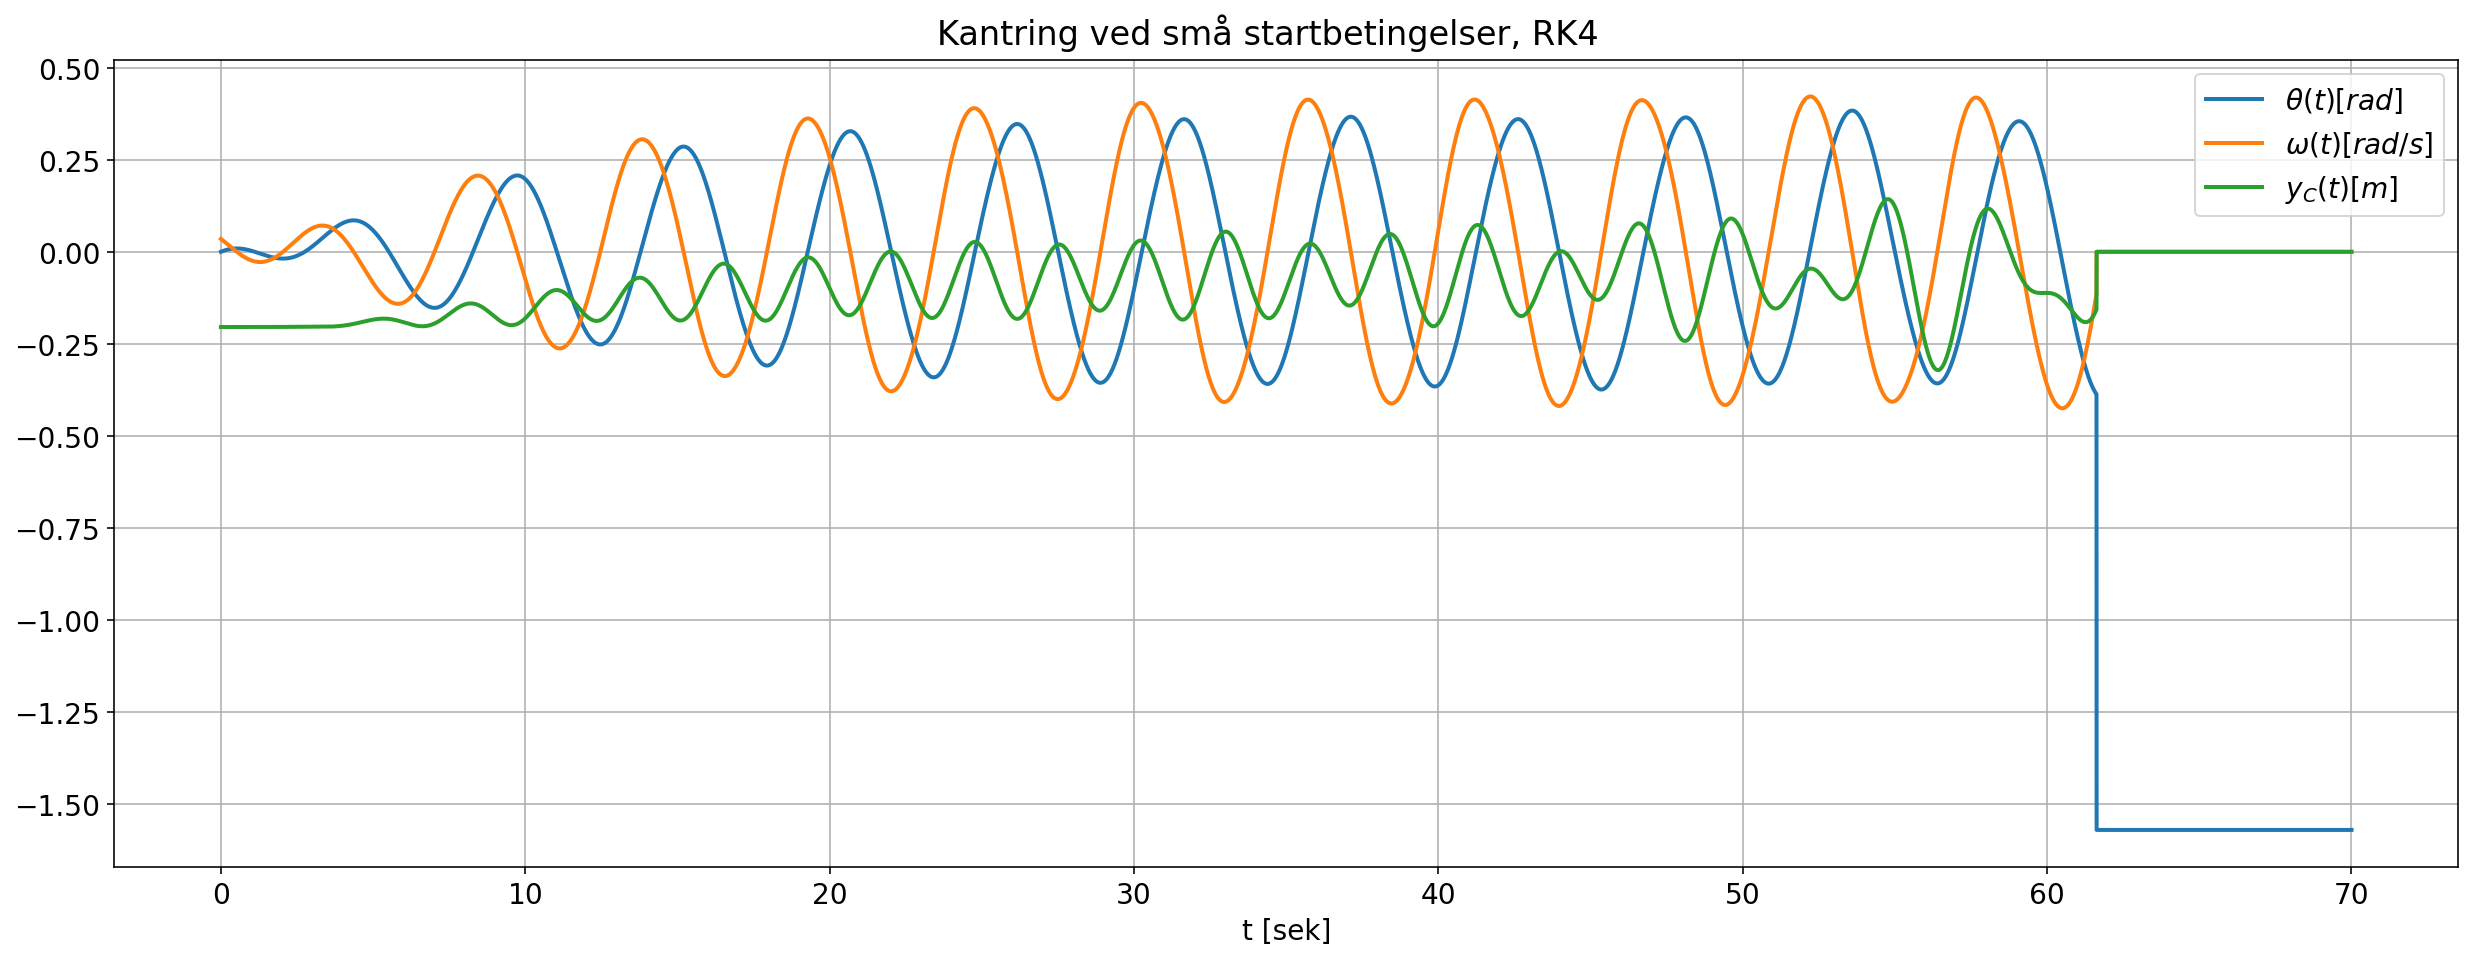

In [42]:
fig, axs = plt.subplots(1,1, figsize=(18, 8))
fig.suptitle(rf"Kantring ved små startbetingelser, Bogacki-Shampine", y=0.85)
fig.tight_layout(pad=3)

axs.plot(t1_2h, w1_2h[:, 0:2])
axs.plot(t1_2h, w1_2h[:, 3])
axs.set_xlabel("t [sek]")
axs.legend([r"$\theta(t) [rad]$", r"$\omega(t) [rad/s]$", r"$y_C(t) [m]$"], loc=1)

fig, axs = plt.subplots(1,1, figsize=(18, 8))
fig.suptitle(rf"Kantring ved små startbetingelser, RK4", y=0.85)
fig.tight_layout(pad=3)

axs.plot(t2_2h, w2_2h[:, 0:2])
axs.plot(t2_2h, w2_2h[:, 3])
axs.set_xlabel("t [sek]")
axs.legend([r"$\theta(t) [rad]$", r"$\omega(t) [rad/s]$", r"$y_C(t) [m]$"], loc=1)

print("Antall elementer i RK4:",len(w2_2h))
print("Antall elementer i Bogacki-Shampine:",len(w1_2h))


Overfor er to plot for to simuleringer på 70 sekunder med startbetingelser $\theta_0=0$ og $\omega_0=2^{\circ}/s$, og parametere $k_f=100$, $F_0=mg$ og $\omega_w=\sqrt{\frac{mgh}{I_C}}$. Den ene simuleringen bruker derimot Bogacki-Shampine og den andre RK4. Etter omtrent 62 sekunder kantrer skipet for begge metoder. Noe å merke seg er at svingningene til skipet når et nærmest stabilt stadie før det tilsynelatende tilfeldigvis kantrer. Dette forklares mest sannsynlig ved at svingningene påvirkes av tilfeldige vertikale bevegelser hos skipet. Ut ifra grafene forekommer det ved ca. 56 sekunder at skipets y-posisjon når et minimum samtidig som skipets vinkelutslag, men skipet kantrer ikke. At dekk er nærmere vannoverflaten vil altså ikke være hele forklaringen, da skipet ikke har en like lav y-posisjon idet det kantrer. Man ser en derimot at det siste toppunktet for skipets utslag er noe lavere enn de før, noe som kan tyde på at nøyaktig denne svingningen er mer påvirket enn andre av annen dynamikk for skipet. Ser man på siste bunnpunkt for skipets vinkelhastighet, er denne lavere enn de tidligere bunnene, noe som betyr at skipet har rotert til en mer ekstrem amplitude som resulterer i kantring, og siden skipet ikke er for langt under vann, motvirker ikke friksjonskrafta dette nok. Denne kantringen skjer uansett med veldig liten margin, og er mulig siden de ytre kreftene produserer utslag som nærmer seg kantring slik at en liten forskjell gjør susen. Det som er imponerende med dette er at de numeriske løserne klarer å registrere denne marginale kantringen, Da spesielt Bogacki-Shampine som ikke er like nøyaktig som RK4. Dette attesterer til disse metodenes nøyaktighet.

Det er også verd å legge merke til at antallet elementer utregnet med de to metodene er svært forskjellige. RK4 ender med $70002$, mens Bogacki-Shampine ender med $124600$, Bogacki-Shampine har dermed $\approx 78\%$ flere elementer enn RK4! Dette kommer antagelig av at den adaptive Bogacki-Shampine får for stor feil med standard steglengde, da funksjonen endrer seg hele veien, og måtte da sette steglengden betydelig ned. RK4 er, i tillegg til å være en fjerde ordens metode, ikke adaptiv, og kan ikke kompensere for dette. Det er nok ikke noe problem, da vi approksimerte over at RK4 metoden antagelig er rundt hundre ganger mer nøyaktig enn Bogacki-Shampine.

Man kan dermed, tenke seg at man kunne argumentere for at så lenge Bogacki-Shampine har under hundre ganger så mange elementer er fortsatt RK4 mer nøyaktig, men dette stemmer ikke nødvendigvis. For eksempel kunne det vært en funksjon som ligger på null fram til et punkt, der den forandrer seg veldig, og deretter tilbake til null. Den adaptive metoden ville antagelig fange opp dette og sette steglengden, som antagelig var stor, veldig liten en kort periode, før den blir stor igjen. Dermed kan man ende opp med en mye mer nøyaktig løsning fra den adaptive metoden som ikke nødvendigvis har mange ganger flere elementer enn løsningen til en ordinær metode.

## Konklusjon

Nå er ventetiden over og vi ønsker, for morohetens skyld, å sende skipet ut på åpent hav med gjerder og løs last - hele pakka. Da blir den påvirket av alle tidligere diskuterte krefter. Et raskt søk på internettet viser at det faktiske Vasaskipet veide rundt $1200$ tonn og hadde $145$ personer som mannskap og $300$ soldater ombord. I tillegg var et også en haug med kanoner og annen last. La oss si at mannskapet og soldatene veier i snitt $80$ kg med rustning som gir en total vekt på ca. $35000$ kg som er rundt $0.029$ av skipets masse. Vi kan med god grunn doble dette fordi en kanon definitivt veier mer enn en person. Vi later som at ingen av overnevnte er bundet fast, og dermed bruker vi $m_L = 0.06m_S$. Ellers bruker vi parameterne fra forrige deloppgave, dermed også den adaptive numeriske ODL-løseren. En flaske med champagne er knust mot skipsmodellens skrog, og vi er klare for å se at den seiler ut fra havna og avgårde på sin ferd.

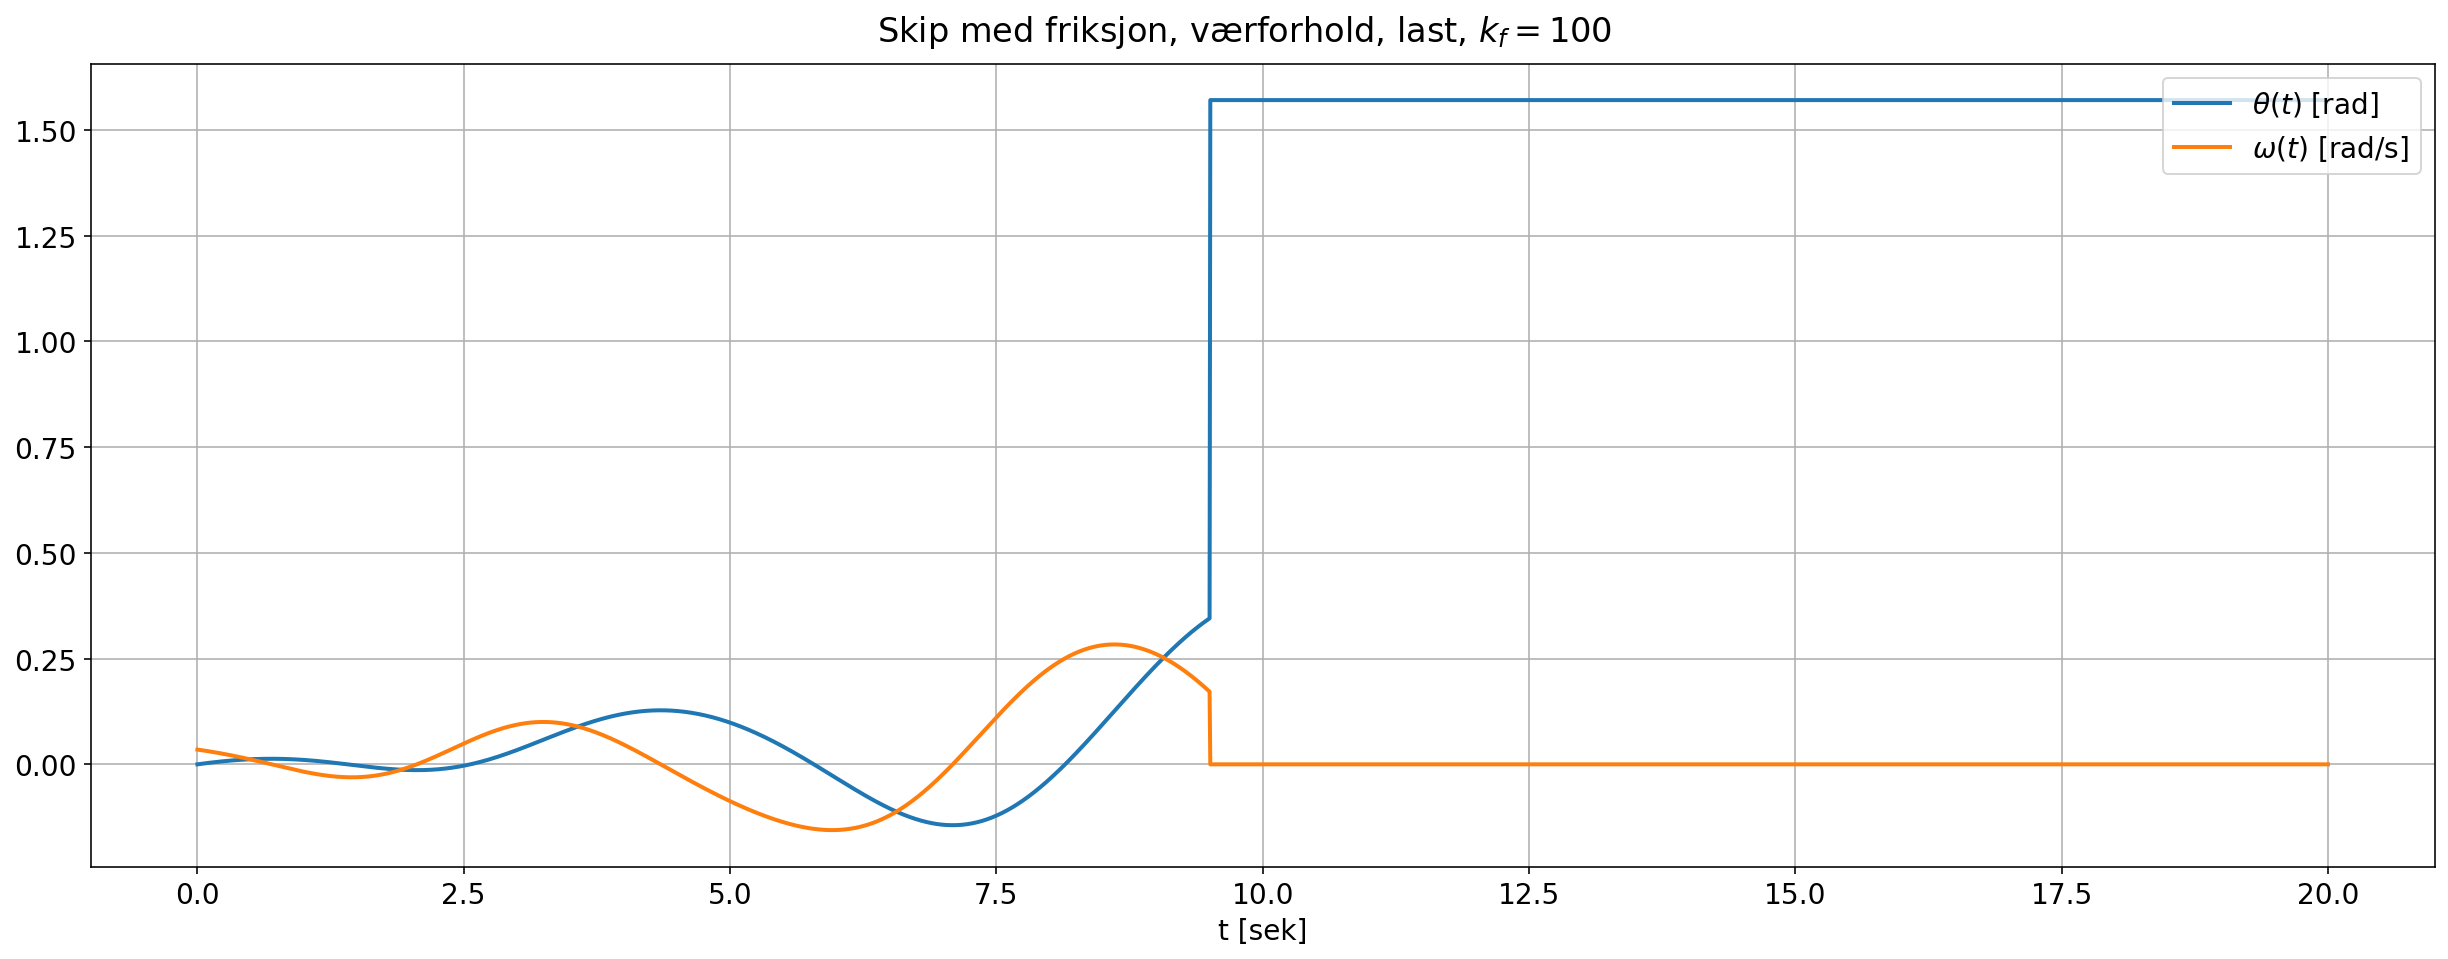

In [43]:
t_lim_konk = [0, 20]
m_L_konk = 0.06

parameter()

theta0_konk, omega0_konk, k_f_konk, F_0_konk, omega_w_konk = 0, np.radians(2), 100, 0.625*m*g, 0.93*sqrt(m*g*h_MC/I_C)
w0_konk = w_vec(theta0_konk, omega0_konk)

t_konk, w_konk = main(f_2f, w0_konk, t_lim_konk, method = bogshamp, last = m_L_konk, gjerder = True, fric = k_f_konk, W = F_0_konk, freq_w = omega_w_konk)

fig, axs = plt.subplots(1,1, figsize=(18, 8))
fig.suptitle(rf"Skip med friksjon, værforhold, last, $k_f = {k_f_konk}$", y=0.85)
fig.tight_layout(pad=3)

axs.plot(t_konk, w_konk[:, 0:2])
axs.set_xlabel("t [sek]")
axs.legend([r"$\theta(t)$ [rad]", r"$\omega(t)$ [rad/s]"], loc=1)

Oisann! Her gikk det riktig så galt. En stor tragedie har funnet sted, men heldigvis bare i Jupyter Notebook. Dersom vi hadde presentert dette for kongen av Sverige på den tiden måtte vi si med sikkerhet at simuleringene ikke gir grunnlag for å sende Vasa ut på åpen hav. Faktisk viser fysikken at skipet hadde kantret lenge før $20$ minutter har passert - dog kan det argumenteres for at modellen vår ikke er nøyaktig nok i forhold til den komplekse strukturen av det faktiske Vasaskipet. Likevel oppsummerer vi det slik: til alle fremtidige konger som ønsker skipet sitt flytende; kjør et par simuleringer først da vel, og husk å binde fast lasten! Ta også resultatet rett til hjertet for å unngå eventuell kantring og dermed sagnomsuste tragedier.